# Оптимизация производственных расходов металлургического комбината «Стальная птица»

**Описание этапа обработки**


Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.


Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.


Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Цель проекта:**
Построить модель, которая будет предстказывать конечную температуру сплава для оптимизации производственных расходов на металлургическом комбинате.

**План проекта:**

1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

**Файл `data_arc_new.csv`**

- `key` — номер партии;
- `Начало нагрева дугой` — время начала нагрева;
- `Конец нагрева дугой` — время окончания нагрева;
- `Активная мощность` — значение активной мощности;
- `Реактивная мощность` — значение реактивной мощности.

**Файл `data_bulk_new.csv`**

- `key` — номер партии;
- `Bulk 1` … `Bulk 15` — объём подаваемого материала.

**Файл `data_bulk_time_new.csv`**

- `key` — номер партии;
- `Bulk 1` … `Bulk 15` — время подачи материала.

**Файл `data_gas_new.csv`**

- `key` — номер партии;
- `Газ 1` — объём подаваемого газа.

**Файл `data_temp_new.csv`**

- `key` — номер партии;
- `Время замера` — время замера;
- `Температура` — значение температуры.

**Файл `data_wire_new.csv`**

- `key` — номер партии;
- `Wire 1` … `Wire 9` — объём подаваемых проволочных материалов.

**Файл `data_wire_time_new.csv`**

- `key` — номер партии;
- `Wire 1` … `Wire 9` — время подачи проволочных материалов.

In [1]:
# Установка catboost
!pip install -q catboost

In [2]:
# Установка phik
!pip install -q phik

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from lightgbm import LGBMRegressor

from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

In [5]:
RANDOM_STATE = 141024
TEST_SIZE = 0.25
UNKNOWN_CATEGORY = -1

## Загрузка данных

### Данные об электродах

In [6]:
# чтение данных data_arc_new
data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')

In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [8]:
data_arc.head(5)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

### Данные о подаче сыпучих материалов (объём)

In [9]:
# чтение данных data_bulk_new
data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

In [10]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [11]:
data_bulk.head(5)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

### Данные о подаче сыпучих материалов (время)

In [12]:
# чтение данных data_bulk_time_new
data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')

In [13]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [14]:
data_bulk_time.head(5)

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

### Данные о продувке сплава газом

In [15]:
# чтение данных data_gas_new
data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

In [16]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [17]:
data_gas.head(5)

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

### Результаты измерения температуры

In [18]:
# чтение данных data_temp_new
data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')

In [19]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [20]:
data_temp.head(20)

key         Время замера  Температура
0     1  2019-05-03 11:02:04       1571.0
1     1  2019-05-03 11:07:18       1604.0
2     1  2019-05-03 11:11:34       1618.0
3     1  2019-05-03 11:18:04       1601.0
4     1  2019-05-03 11:25:59       1606.0
5     1  2019-05-03 11:30:38       1613.0
6     2  2019-05-03 11:34:04       1581.0
7     2  2019-05-03 11:38:40       1577.0
8     2  2019-05-03 11:46:09       1589.0
9     2  2019-05-03 11:49:38       1604.0
10    2  2019-05-03 11:55:09       1602.0
11    3  2019-05-03 12:06:44       1596.0
12    3  2019-05-03 12:13:42       1597.0
13    3  2019-05-03 12:18:46       1598.0
14    3  2019-05-03 12:25:33       1599.0
15    3  2019-05-03 12:31:04       1600.0
16    3  2019-05-03 12:35:57       1599.0
17    4  2019-05-03 12:39:27       1601.0
18    4  2019-05-03 12:44:37       1623.0
19    4  2019-05-03 12:48:04       1618.0

### Данные о проволочных материалах (объём)

In [21]:
# чтение данных data_wire_new
data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

In [22]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [23]:
data_wire.head(5)

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

### Данные о проволочных материалах (время)

In [24]:
# чтение данных data_wire_time_new
data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [25]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [26]:
data_wire_time.head(5)

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

### Выовды:
- Проведена загрузка данных;
- Данные соответствуют описанию?
- Найдены пропуски в данных.

## Исследовательский анализ и предобработка данных

- data_arc_new — данные об электродах;
- data_bulk_new — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new — данные о подаче сыпучих материалов (время);
- data_gas_new — данные о продувке сплава газом;
- data_temp_new — результаты измерения температуры;
- data_wire_new — данные о проволочных материалах (объём);
- data_wire_time_new — данные о проволочных материалах (время).

In [27]:
# Подготовка функции для исследования количественных и дискретных признаков
def viz_num_variable(df, column):
    sns.set(rc={"figure.figsize": (15, 7)})

    # Проверка количества уникальных значений в признаке
    unique_values = df[column].nunique()

    if unique_values <= 15:  # Если количество уникальных значений <= 15, считаем признак дискретным
        sns.countplot(x=df[column], palette='Set2')
        plt.ylabel('Частота')
        plt.xlabel(column)
        plt.title(f'Распределение {column} (дискретный признак)')
    else:  # Иначе считаем признак количественным
        fig, axes = plt.subplots(1, 2)

        sns.histplot(data=df[column], bins=20, ax=axes[0], kde=True)
        axes[0].set(ylabel='Частота', xlabel=column)

        sns.boxplot(x=df[column], ax=axes[1])
        axes[1].set(xlabel=column)

        plt.suptitle(f'Распределение {column} (количественный признак)')

    plt.show()

### Данные об электродах

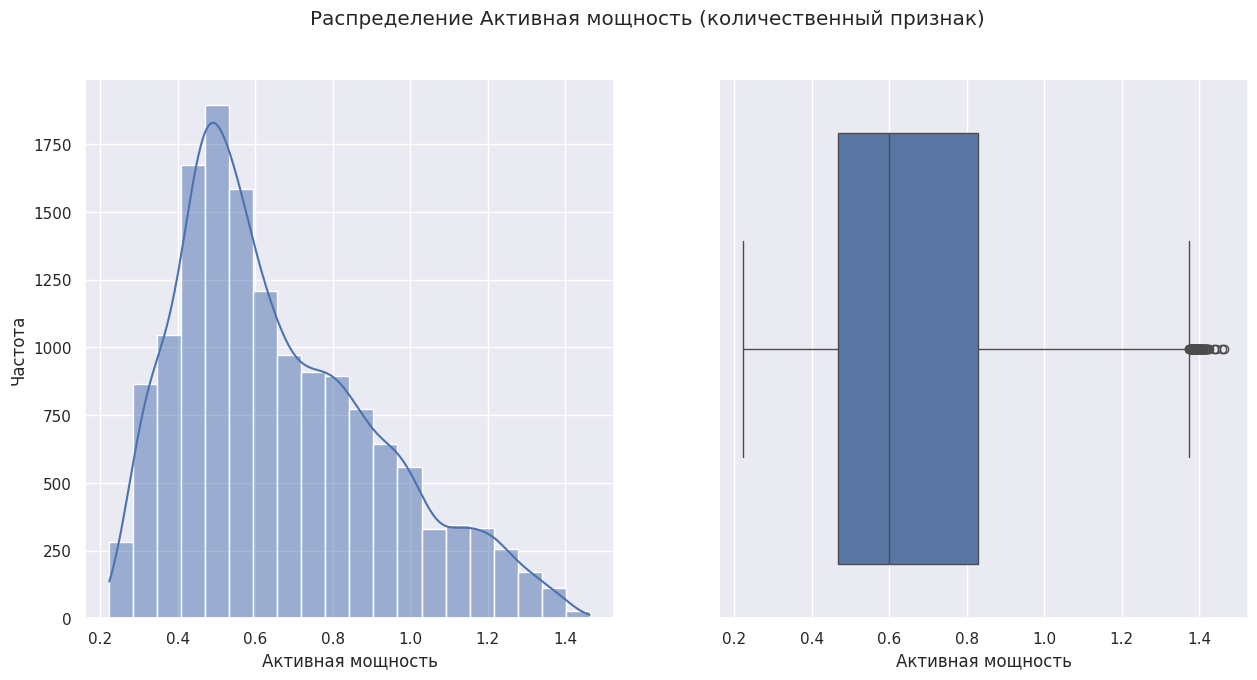

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64


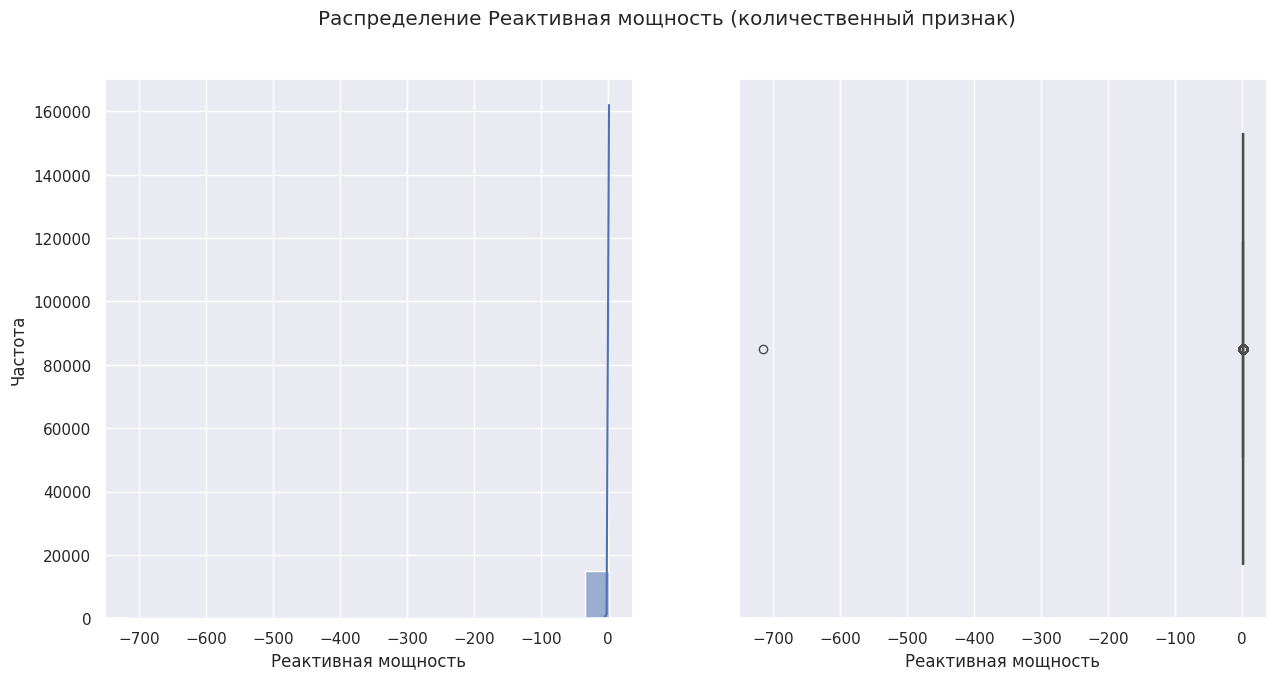

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64


In [28]:
# Анализ данных об электродах
for name in data_arc.select_dtypes(include=['float64', 'int64']).columns.tolist():
    if name != 'key':
        viz_num_variable(data_arc, name)
        print(data_arc[name].describe())

In [29]:
# Изучение аномалии
data_arc[data_arc['Реактивная мощность'] < 0]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57           0.705344   

      Реактивная мощность  
9780          -715.479924

In [30]:
# Изучение аномальных партий
data_arc[data_arc['key'] == 2116]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9778  2116  2019-07-28 02:07:12  2019-07-28 02:09:14           0.787549   
9779  2116  2019-07-28 02:13:10  2019-07-28 02:15:25           0.580263   
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57           0.705344   
9781  2116  2019-07-28 02:29:11  2019-07-28 02:30:18           0.563641   

      Реактивная мощность  
9778             0.693881  
9779             0.411498  
9780          -715.479924  
9781             0.408513

In [31]:
# Удаление номального процесса
data_arc = data_arc[data_arc['key'] != 2116]

In [32]:
data_arc.columns

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')

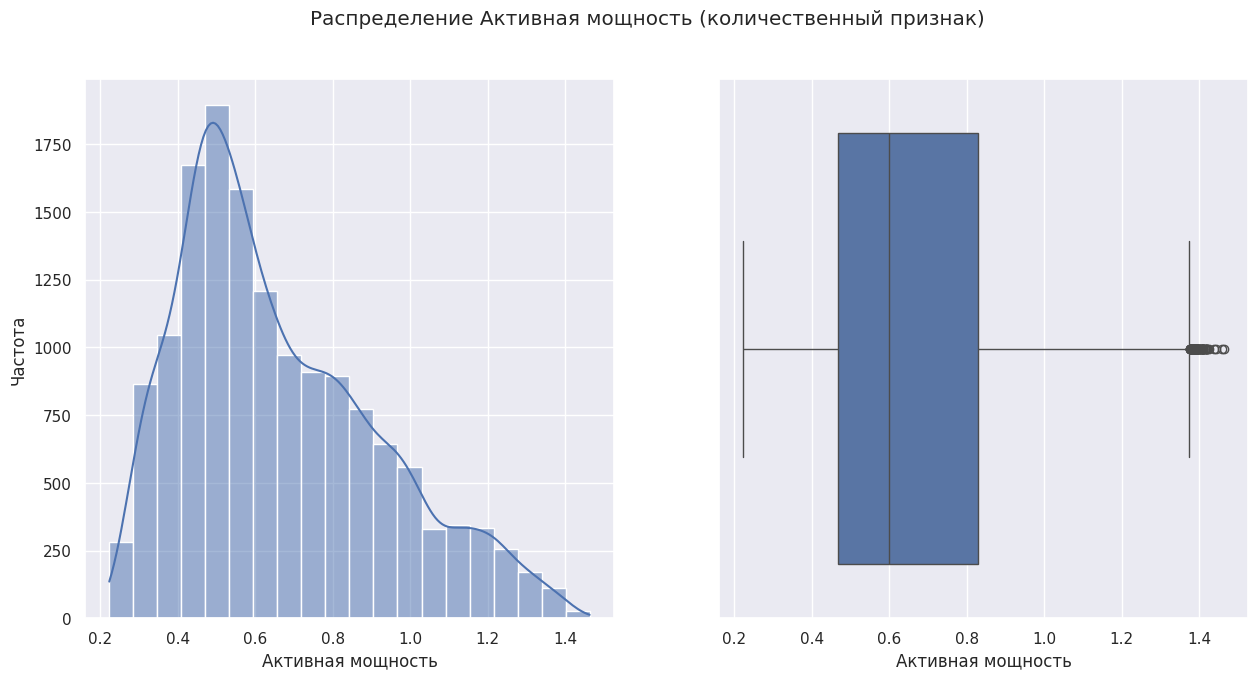

count    14872.000000
mean         0.662753
std          0.258916
min          0.223120
25%          0.467114
50%          0.599587
75%          0.830314
max          1.463773
Name: Активная мощность, dtype: float64


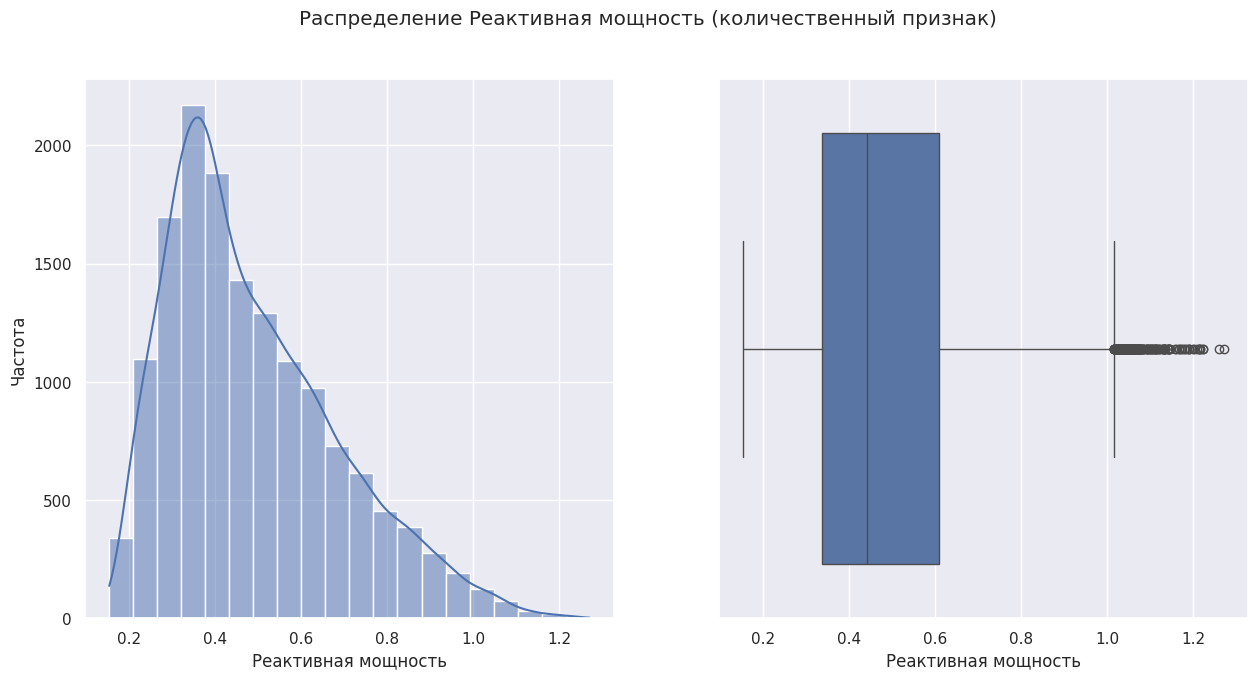

count    14872.000000
mean         0.487112
std          0.197623
min          0.153777
25%          0.337175
50%          0.441667
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64


In [33]:
# Проверка данных
for name in data_arc.select_dtypes(include=['float64', 'int64']).columns.tolist():
    if name != 'key':
        viz_num_variable(data_arc, name)
        print(data_arc[name].describe())

In [34]:
# Копирование датафрейма
data_arc_main = data_arc.copy()

# Создание новых признаков
data_arc_main['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc_main['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc_main['Полная мощность'] = (    data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**(0.5)
data_arc_main['Время нагрева дугой'] = (data_arc_main['Конец нагрева дугой'] - data_arc_main['Начало нагрева дугой'])\
    .dt.total_seconds().astype(int)
data_arc_main['Затраты электроэнергии'] = data_arc_main['Полная мощность'] * data_arc_main['Время нагрева дугой']

In [35]:
# Групировка данных
data_arc_main_columns = {
    'key': 'count',
    'Начало нагрева дугой': 'min',
    'Конец нагрева дугой': 'max',
    'Активная мощность': 'mean',
    'Реактивная мощность': 'mean',
    'Полная мощность': 'mean',
    'Время нагрева дугой': 'sum',
    'Затраты электроэнергии': 'sum'
}
data_arc_main = data_arc_main.groupby('key')\
    .agg(data_arc_main_columns).rename(columns={'key':'Количество циклов нагрева'})

# Удаление лишних колонок
data_arc_main.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis= 1 , inplace= True )

In [36]:
data_arc_main.head(20)

Количество циклов нагрева  Активная мощность  Реактивная мощность  \
key                                                                      
1                            5           0.607346             0.428564   
2                            4           0.534852             0.363339   
3                            5           0.812728             0.587491   
4                            4           0.676622             0.514248   
5                            4           0.563238             0.421998   
6                            4           0.681319             0.470328   
7                            4           0.656719             0.490105   
8                            4           0.669739             0.524238   
9                            5           0.704164             0.505473   
10                           6           0.519796             0.359157   
11                           5           0.600676             0.473785   
12                           4           0.559173             0.411624   
13                           6           0.571949             0.430354   
14                           6           0.718418             0.568734   
15                           5           0.554413             0.380989   
16                           3           0.518628             0.378790   
17                           5           0.925957             0.711557   
18                           5           0.708731             0.519032   
19                           3           0.792497             0.550456   
20                           5           0.613863             0.449178   

     Полная мощность  Время нагрева дугой  Затраты электроэнергии  
key                                                                
1           0.743747                 1098              770.282114  
2           0.647087                  811              481.760005  
3           1.003845                  655              722.837668  
4           0.850010                  741              683.455597  
5           0.704245                  869              512.169934  
6           0.828269                  952              839.231310  
7           0.820978                  673              613.576982  
8           0.851489                  913              619.129542  
9           0.867052                  625              570.113675  
10          0.631834                  825              533.482050  
11          0.765546                  627              437.897690  
12          0.694797                  739              580.426837  
13          0.716264                 1027              744.415352  
14          0.917409                 1235             1182.253053  
15          0.672868                  714              457.872635  
16          0.642473                  894              582.270410  
17          1.169537                  714              897.684569  
18          0.880208                  842              681.527178  
19          0.964935                  321              313.650413  
20          0.761283                  735              518.808550

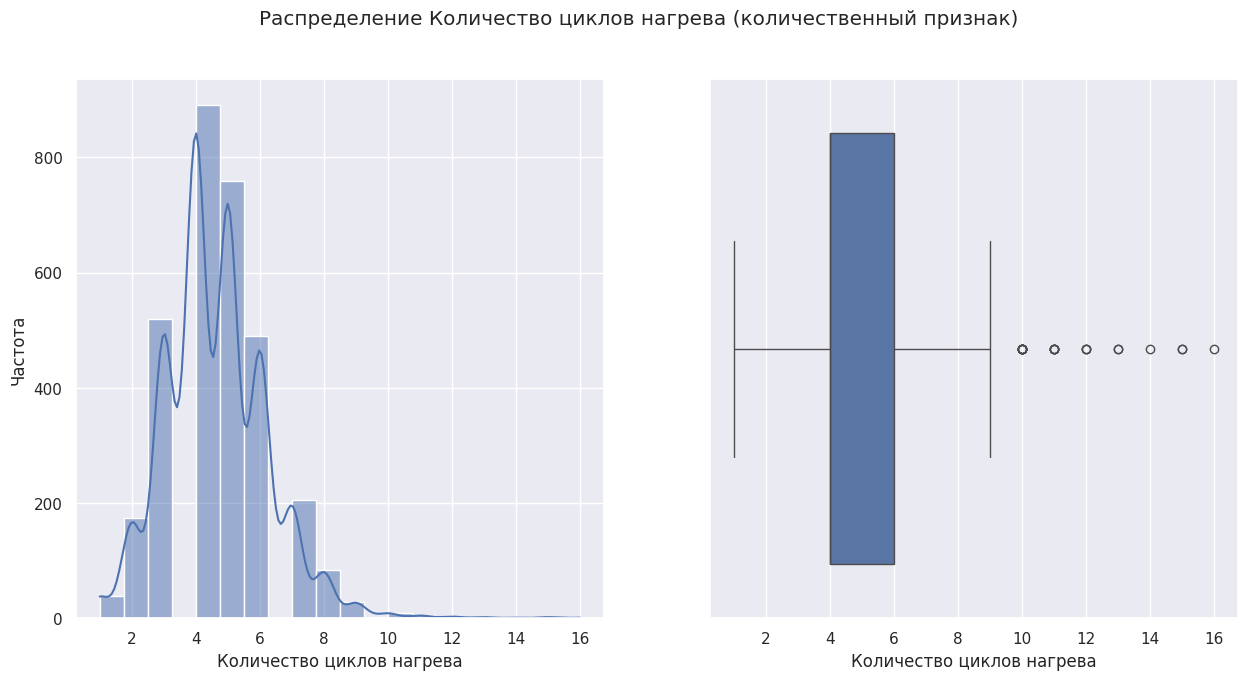

count    3213.000000
mean        4.628696
std         1.608860
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: Количество циклов нагрева, dtype: float64


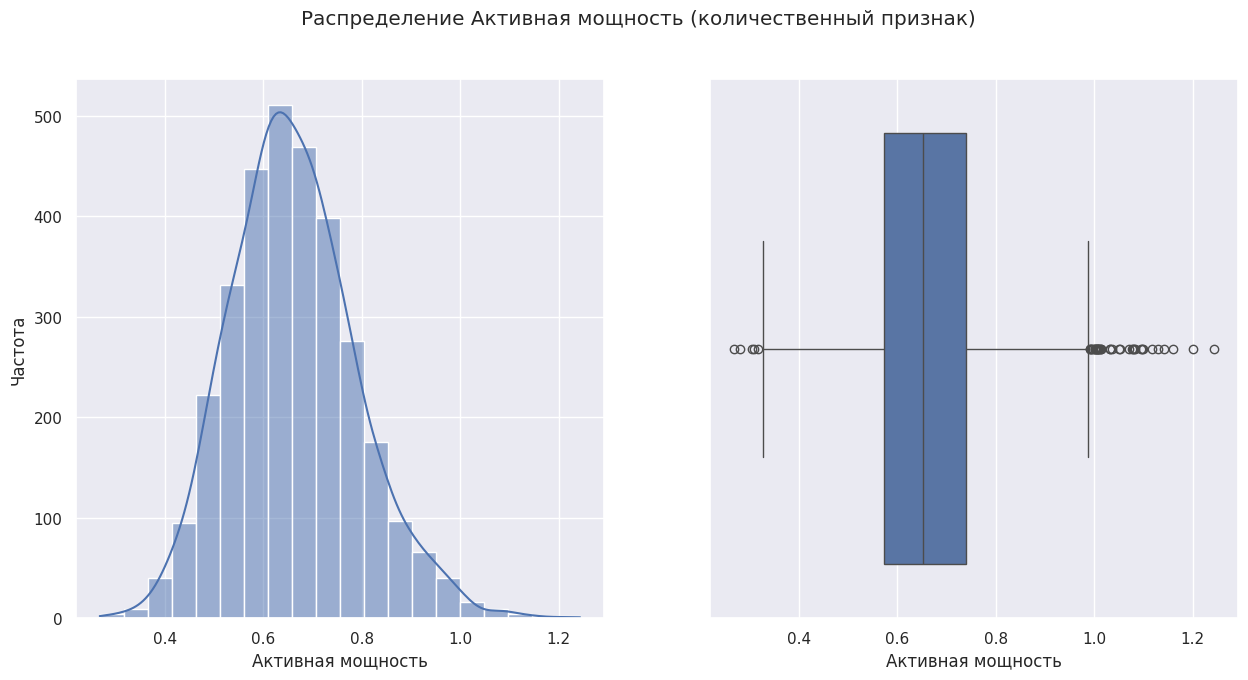

count    3213.000000
mean        0.661332
std         0.128392
min         0.267676
25%         0.573010
50%         0.652864
75%         0.739401
max         1.243889
Name: Активная мощность, dtype: float64


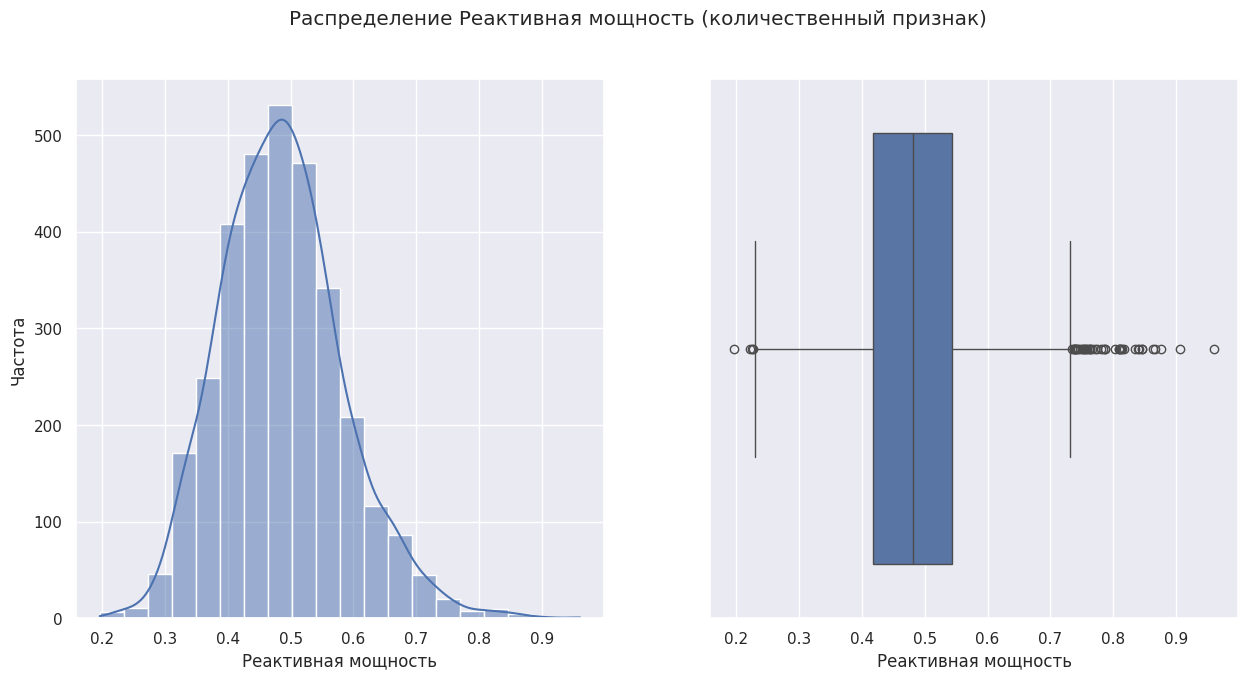

count    3213.000000
mean        0.485966
std         0.097600
min         0.196228
25%         0.417393
50%         0.481626
75%         0.543327
max         0.960763
Name: Реактивная мощность, dtype: float64


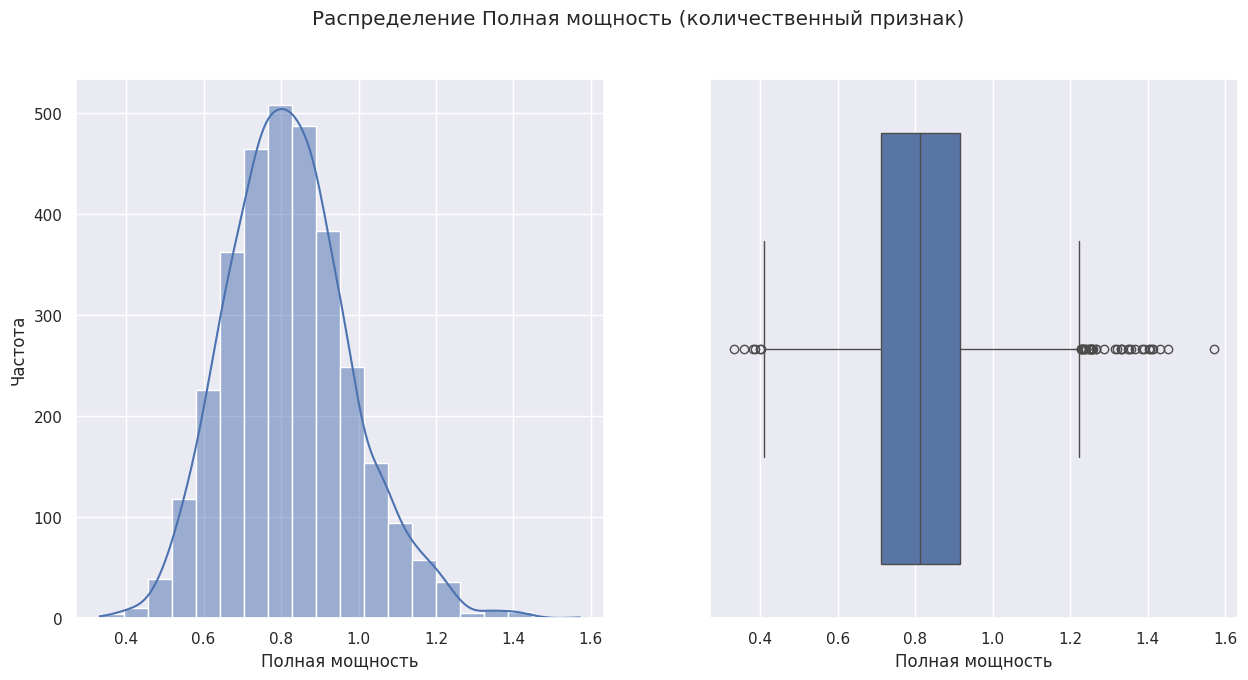

count    3213.000000
mean        0.821565
std         0.160135
min         0.331897
25%         0.711188
50%         0.812374
75%         0.916626
max         1.572238
Name: Полная мощность, dtype: float64


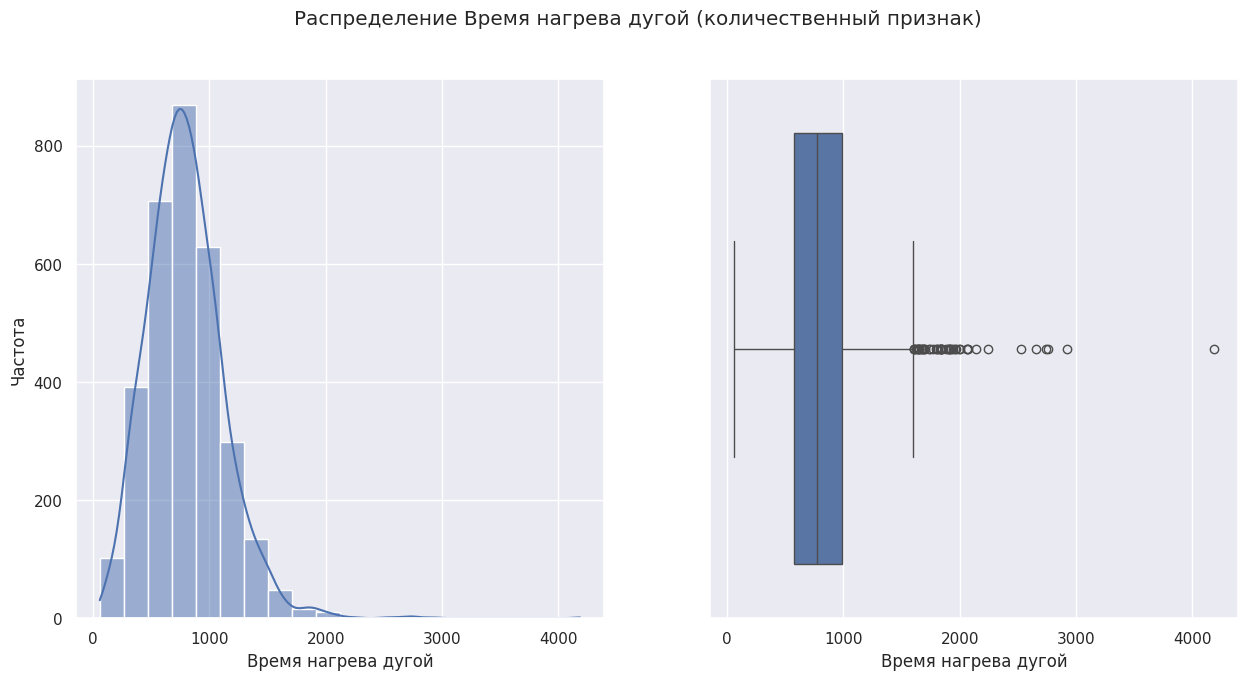

count    3213.000000
mean      794.691566
std       332.439136
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      4189.000000
Name: Время нагрева дугой, dtype: float64


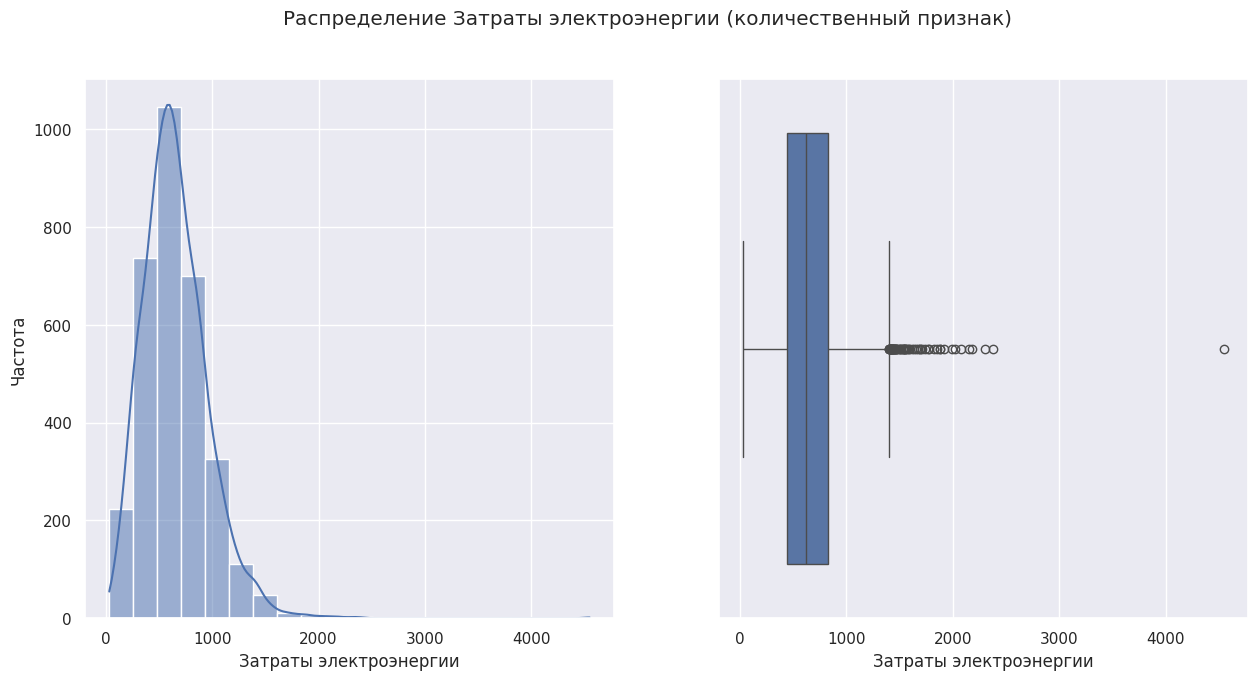

count    3213.000000
mean      655.688884
std       308.950188
min        33.430208
25%       444.864502
50%       620.111140
75%       827.784614
max      4546.405812
Name: Затраты электроэнергии, dtype: float64


In [37]:
# Анализ полученных даных
for name in data_arc_main.select_dtypes(include=['float64', 'int64']).columns.tolist():
    if name != 'key':
        viz_num_variable(data_arc_main, name)
        print(data_arc_main[name].describe())

In [38]:
# Изучение аномалии
data_arc_main[data_arc_main['Время нагрева дугой'] > 3000]

Количество циклов нагрева  Активная мощность  Реактивная мощность  \
key                                                                       
1689                         15           0.825042             0.596603   

      Полная мощность  Время нагрева дугой  Затраты электроэнергии  
key                                                                 
1689         1.019218                 4189             4546.405812

In [39]:
# Удаление аномальных партий
data_arc_main = data_arc_main[data_arc_main['Время нагрева дугой'] < 3000]

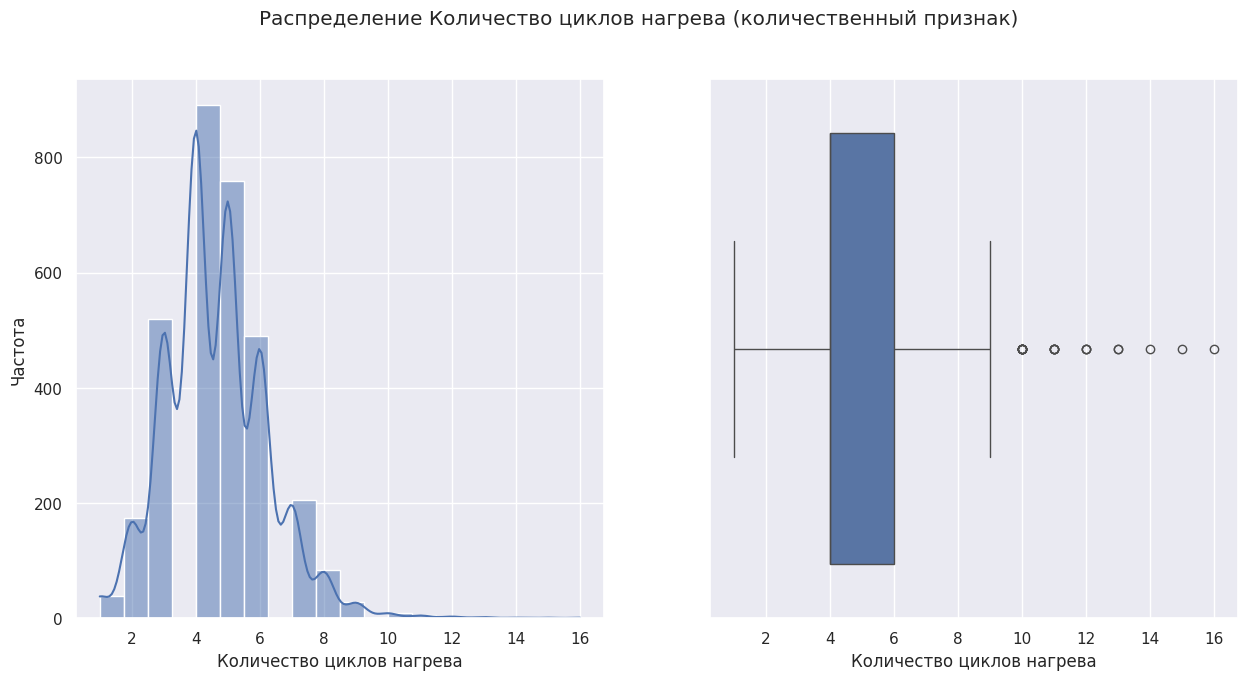

count    3212.000000
mean        4.625467
std         1.598664
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: Количество циклов нагрева, dtype: float64


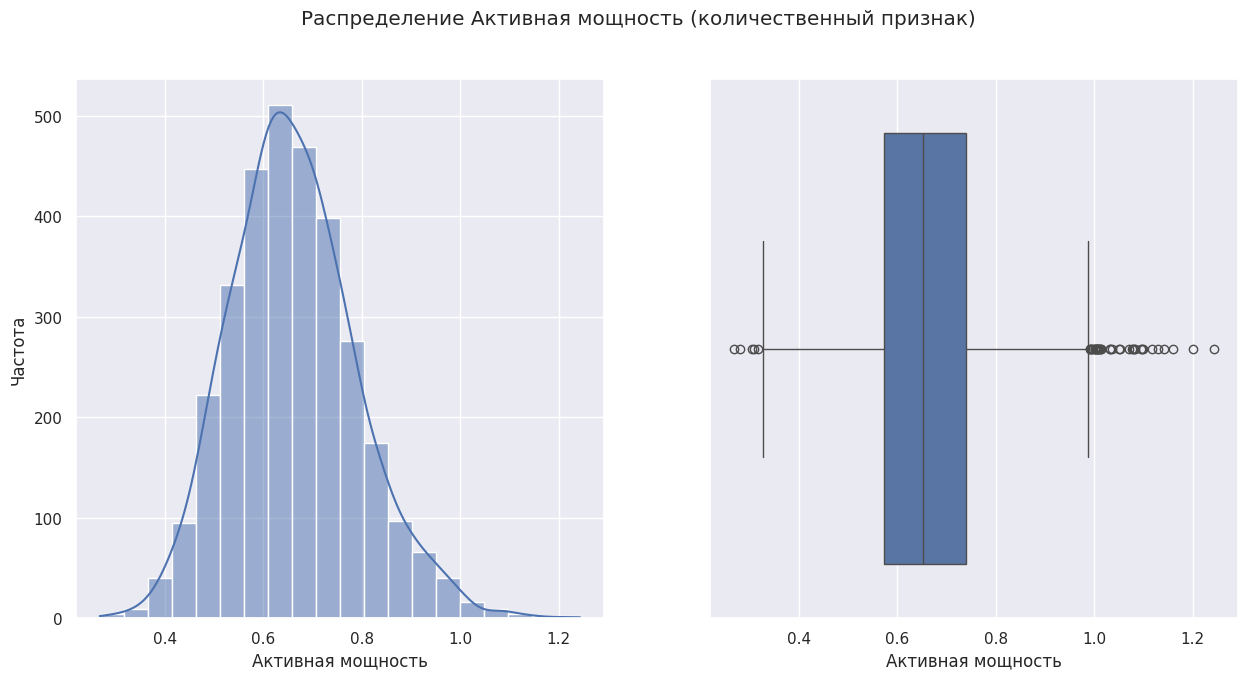

count    3212.000000
mean        0.661281
std         0.128379
min         0.267676
25%         0.572991
50%         0.652732
75%         0.739362
max         1.243889
Name: Активная мощность, dtype: float64


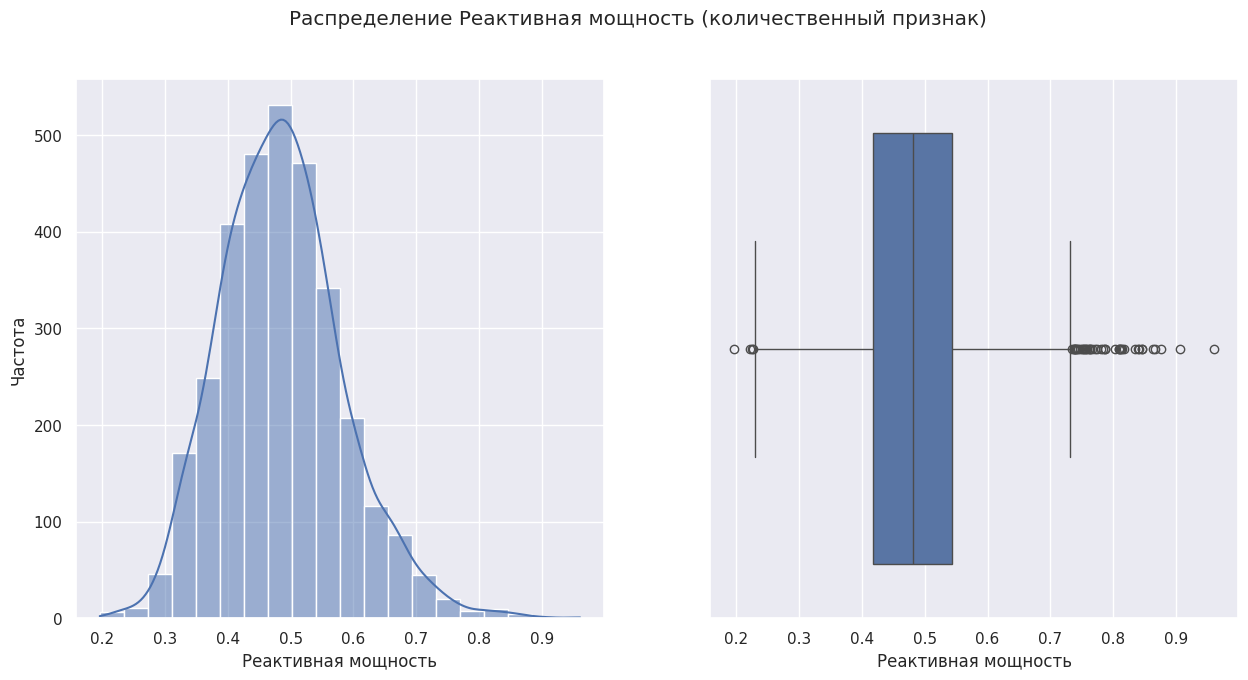

count    3212.000000
mean        0.485931
std         0.097596
min         0.196228
25%         0.417362
50%         0.481508
75%         0.543280
max         0.960763
Name: Реактивная мощность, dtype: float64


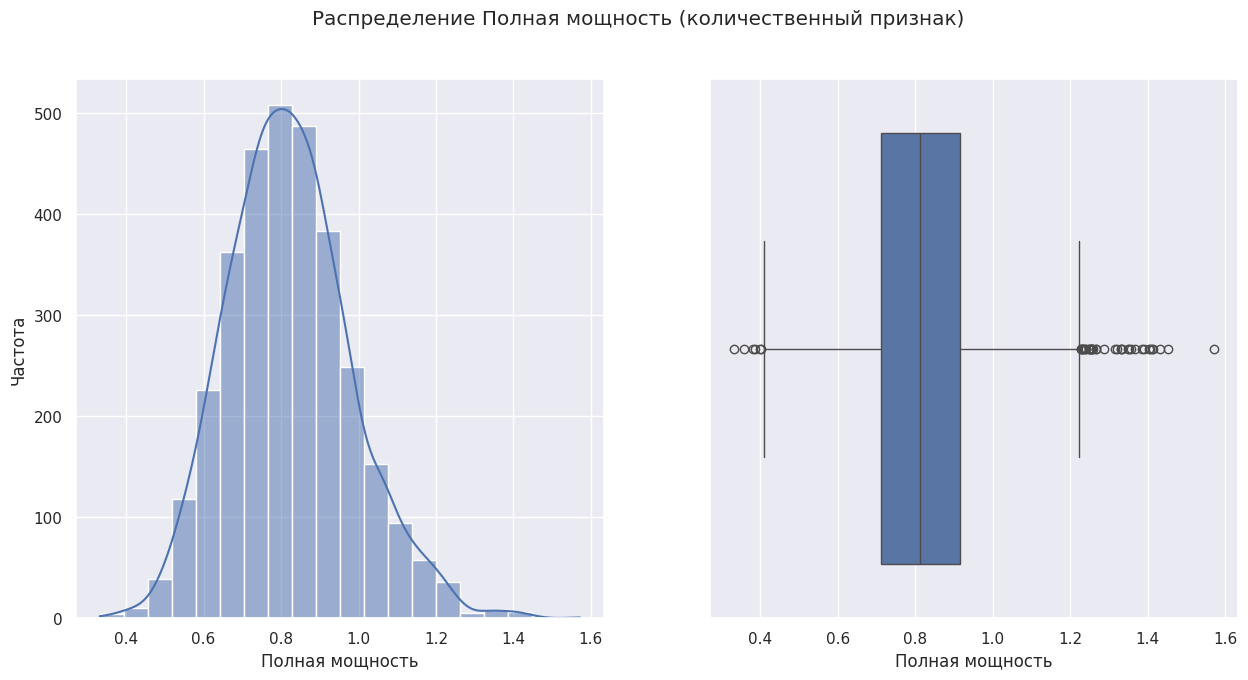

count    3212.000000
mean        0.821503
std         0.160122
min         0.331897
25%         0.711159
50%         0.812341
75%         0.916554
max         1.572238
Name: Полная мощность, dtype: float64


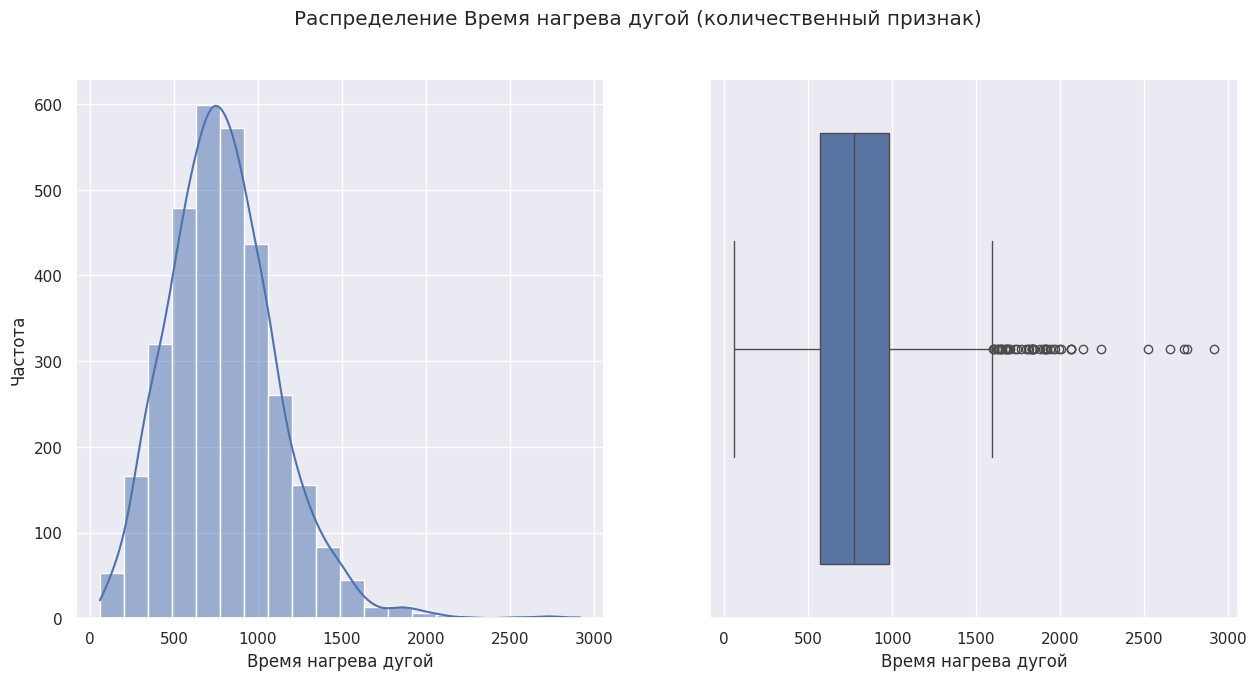

count    3212.000000
mean      793.634807
std       327.048924
min        57.000000
25%       571.000000
50%       770.000000
75%       983.000000
max      2919.000000
Name: Время нагрева дугой, dtype: float64


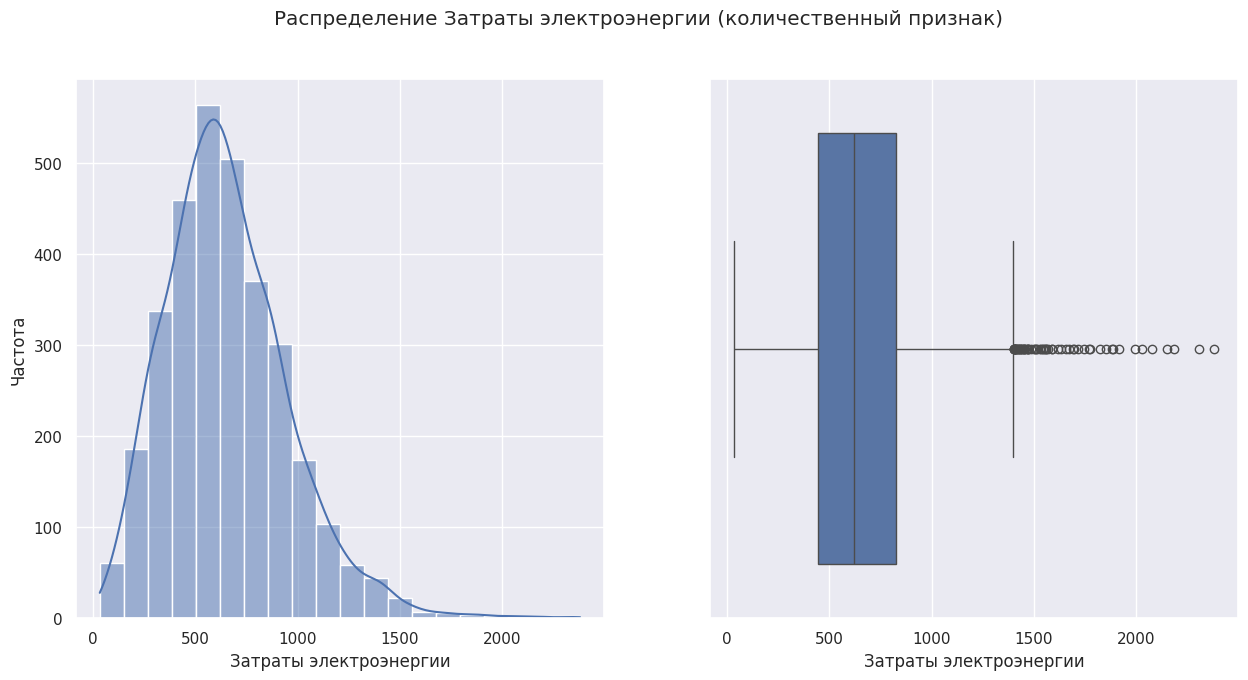

count    3212.000000
mean      654.477577
std       301.270905
min        33.430208
25%       444.785195
50%       620.101427
75%       827.446306
max      2380.879281
Name: Затраты электроэнергии, dtype: float64


In [40]:
# Проверка данных
for name in data_arc_main.select_dtypes(include=['float64', 'int64']).columns.tolist():
    if name != 'key':
        viz_num_variable(data_arc_main, name)
        print(data_arc_main[name].describe())

### Данные о подаче сыпучих материалов (объём)

In [41]:
# Заполнение недостоющих данных
data_bulk = data_bulk.fillna(0)

In [42]:
# Добавление признака с суммой сыпучих материалов
data_bulk['Bulk sum'] = data_bulk.sum(axis=1)
data_bulk = data_bulk.astype(int)

In [43]:
# Изучение даных о подаче сыпучих материалов
data_bulk.head(20)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0     1       0       0       0      43       0       0       0       0   
1     2       0       0       0      73       0       0       0       0   
2     3       0       0       0      34       0       0       0       0   
3     4       0       0       0      81       0       0       0       0   
4     5       0       0       0      78       0       0       0       0   
5     6       0       0       0     117       0       0       0       0   
6     7       0       0       0     117       0       0       0       0   
7     8       0       0       0      99       0       0       0       0   
8     9       0       0       0     117       0       0       0       0   
9    10       0       0       0       0       0       0       0       0   
10   11       0       0       0      69       0       0       0       0   
11   12      46       0       0      34       0       0       0       0   
12   13       0       0       0       0       0      72       0       0   
13   14       0       0      71       0       0       0       0       0   
14   15       0       0       0       0       0      77       0       0   
15   16       0       0       0       0       0       0       0       0   
16   17       0       0       0       0       0       0       0       0   
17   18       0       0       0       0       0      76       0       0   
18   19       0       0       0       0       0     219       0       0   
19   20       0       0       0       0       0       0       0       0   

    Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  Bulk sum  
0        0        0        0      206        0      150      154       554  
1        0        0        0      206        0      149      154       584  
2        0        0        0      205        0      152      153       547  
3        0        0        0      207        0      153      154       599  
4        0        0        0      203        0      151      152       589  
5        0        0        0      204        0      201      154       682  
6        0        0        0      204        0      152      154       634  
7        0        0        0      410        0      252      153       922  
8        0        0        0      107        0       99      203       535  
9        0        0        0      203        0      102      204       519  
10       0        0        0      207        0      101      202       590  
11       0        0        0      618        0      406      203      1319  
12       0        0        0      410        0      151      204       850  
13       0        0        0      204        0      152      203       644  
14       0        0        0        0        0      251      203       546  
15       0        0        0      206        0      100      203       525  
16       0        0        0        0        0      153      202       372  
17       0        0        0      206        0      103      203       606  
18       0        0        0        0        0        0        0       238  
19       0        0        0        0        0      249        0       269

### Данные о продувке сплава газом

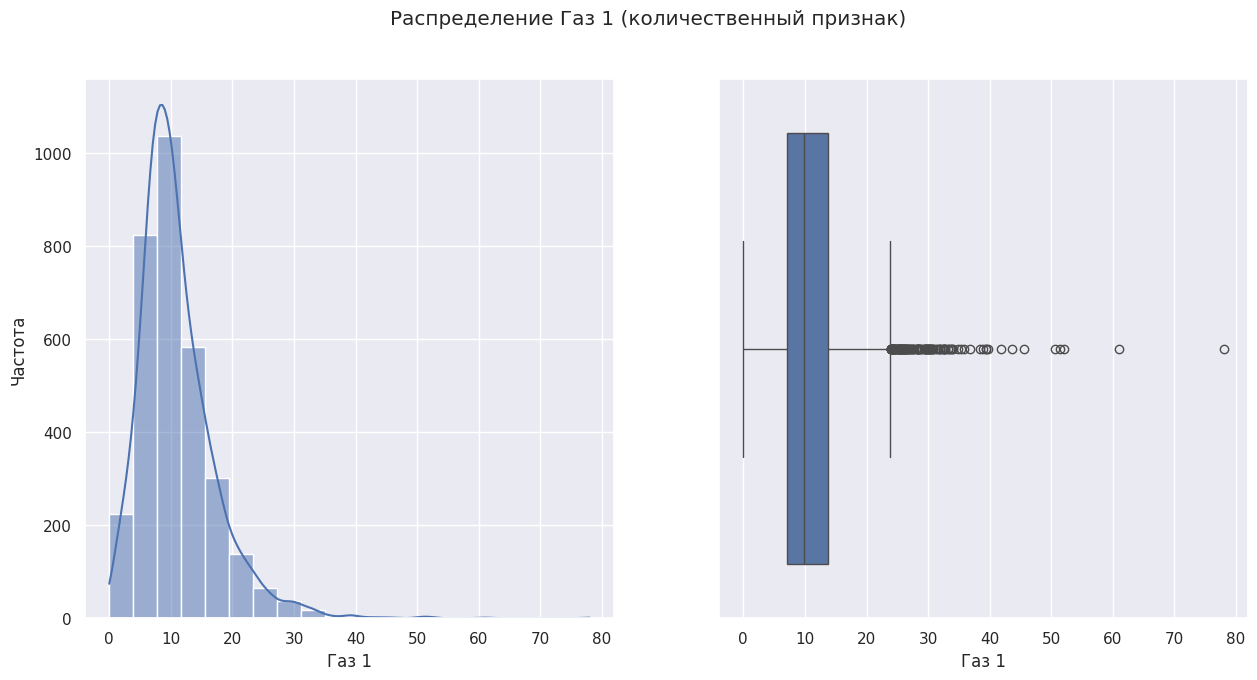

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64


In [44]:
# Изучение данных о продувке сплава газом
for name in data_gas.select_dtypes(include=['float64', 'int64']).columns.tolist():
    if name != 'key':
        viz_num_variable(data_gas, name)
        print(data_gas[name].describe())

### Результаты измерения температуры

In [45]:
# Удаление партий с пропусками измерния температуры
data_temp = data_temp[~data_temp['key'].isin(data_temp[data_temp['Температура'].isna()]['key'].tolist())]

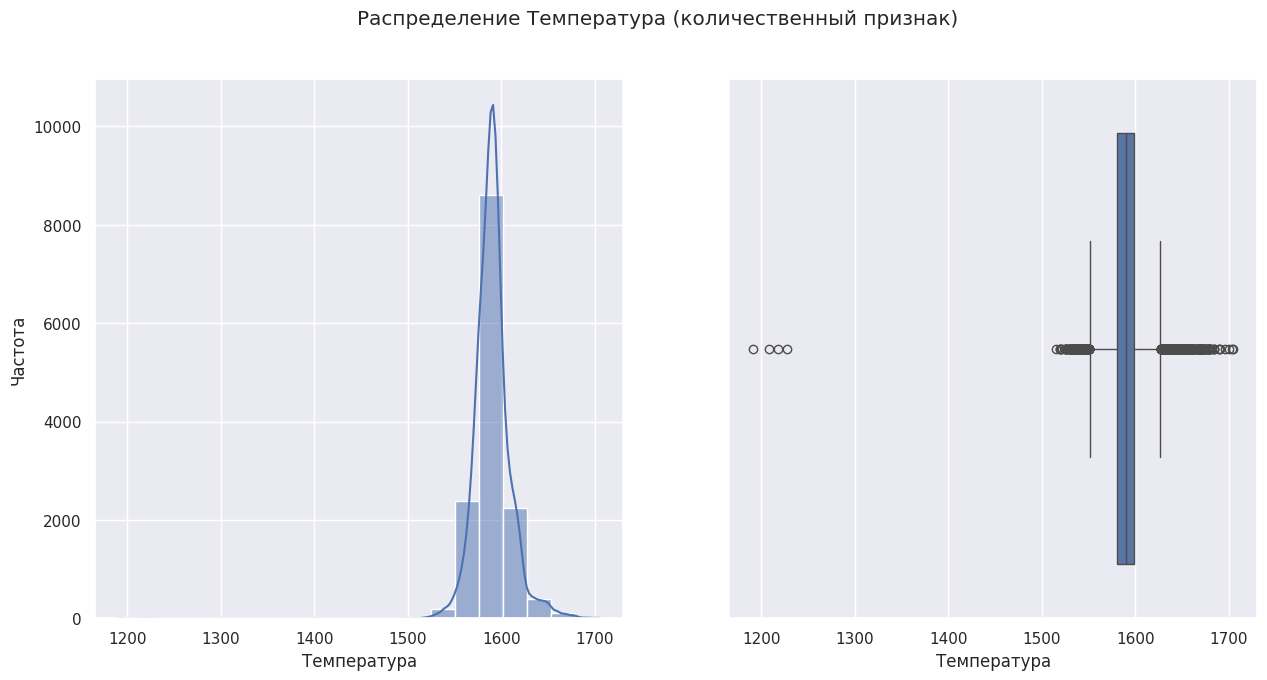

count    13926.000000
mean      1590.802671
std         19.845377
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64


In [46]:
# Изучение данных о измерении температуры
for name in data_temp.select_dtypes(include=['float64', 'int64']).columns.tolist():
    if name != 'key':
        viz_num_variable(data_temp, name)
        print(data_temp[name].describe())

In [47]:
data_temp[data_temp['key'].isin(data_temp[data_temp['Температура'] < 1500]['key'].tolist())]

key         Время замера  Температура
4883    867  2019-06-06 08:03:39       1191.0
4884    867  2019-06-06 08:18:52       1575.0
4885    867  2019-06-06 08:22:38       1576.0
4886    867  2019-06-06 08:25:11       1571.0
4887    867  2019-06-06 08:29:49       1600.0
4888    867  2019-06-06 08:36:49       1522.0
4889    867  2019-06-06 08:43:02       1521.0
4890    867  2019-06-06 08:48:23       1599.0
6784   1214  2019-06-18 08:01:03       1208.0
6785   1214  2019-06-18 08:17:56       1608.0
6786   1214  2019-06-18 08:31:10       1608.0
6787   1214  2019-06-18 08:43:56       1591.0
9050   1619  2019-07-03 02:34:41       1218.0
9051   1619  2019-07-03 02:39:29       1623.0
9052   1619  2019-07-03 02:43:59       1590.0
11495  2052  2019-07-25 08:49:15       1227.0
11496  2052  2019-07-25 08:54:39       1592.0
11497  2052  2019-07-25 09:03:59       1590.0
11498  2052  2019-07-25 09:07:19       1591.0
11499  2052  2019-07-25 09:20:11       1515.0
11500  2052  2019-07-25 09:27:03       1592.0

In [48]:
# Удаление партий с аномльно низкой температурой
data_temp = data_temp[~data_temp['key'].isin(data_temp[data_temp['Температура'] < 1500]['key'].tolist())]

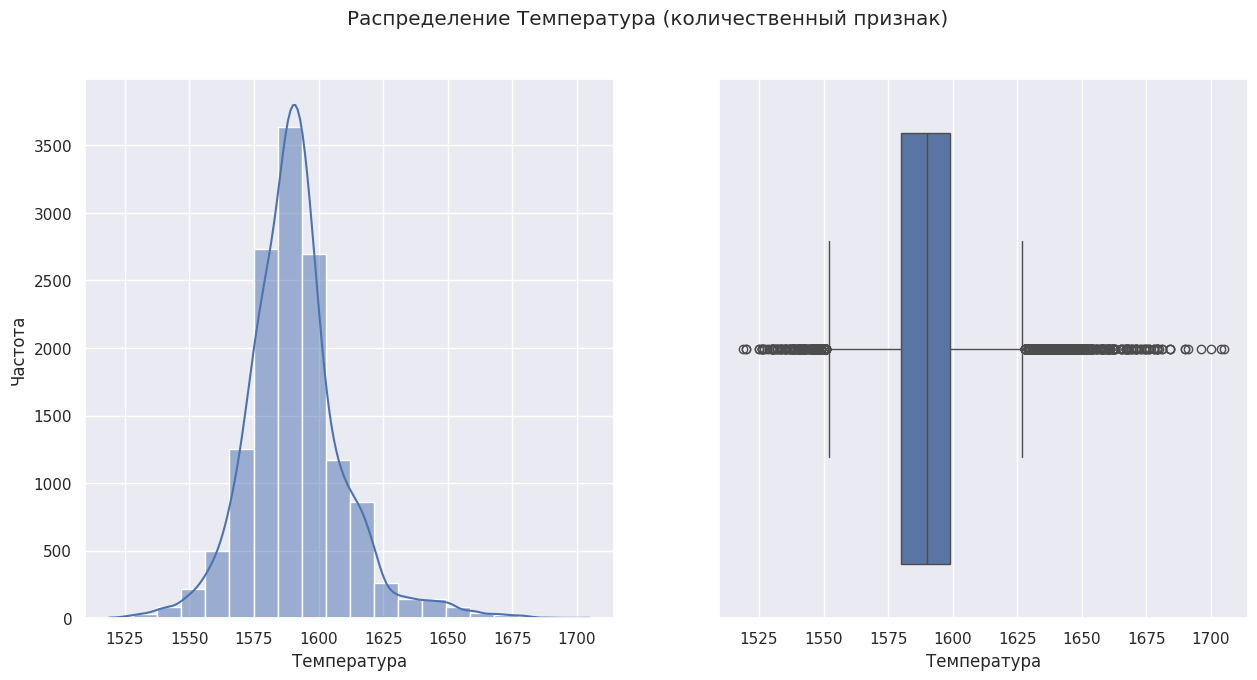

count    13905.000000
mean      1590.924847
std         18.750314
min       1519.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64


In [49]:
# Проверка данных о измерении температуры
for name in data_temp.select_dtypes(include=['float64', 'int64']).columns.tolist():
    if name != 'key':
        viz_num_variable(data_temp, name)
        print(data_temp[name].describe())

In [50]:
# Копирование датафрейма
data_temp_main = data_temp.copy()

# Добавление признаков
data_temp_main['Начальная температура'] = data_temp_main['Температура']
data_temp_main['Конечная температура'] = data_temp_main['Температура']

# Группирвка данных
data_temp_main = data_temp_main.groupby('key').agg(
    {'Начальная температура' : 'first',
     'Конечная температура' : 'last'}
)

data_temp_main['Начальная температура'] = data_temp_main['Начальная температура'].astype(int)
data_temp_main['Конечная температура'] = data_temp_main['Конечная температура'].astype(int)

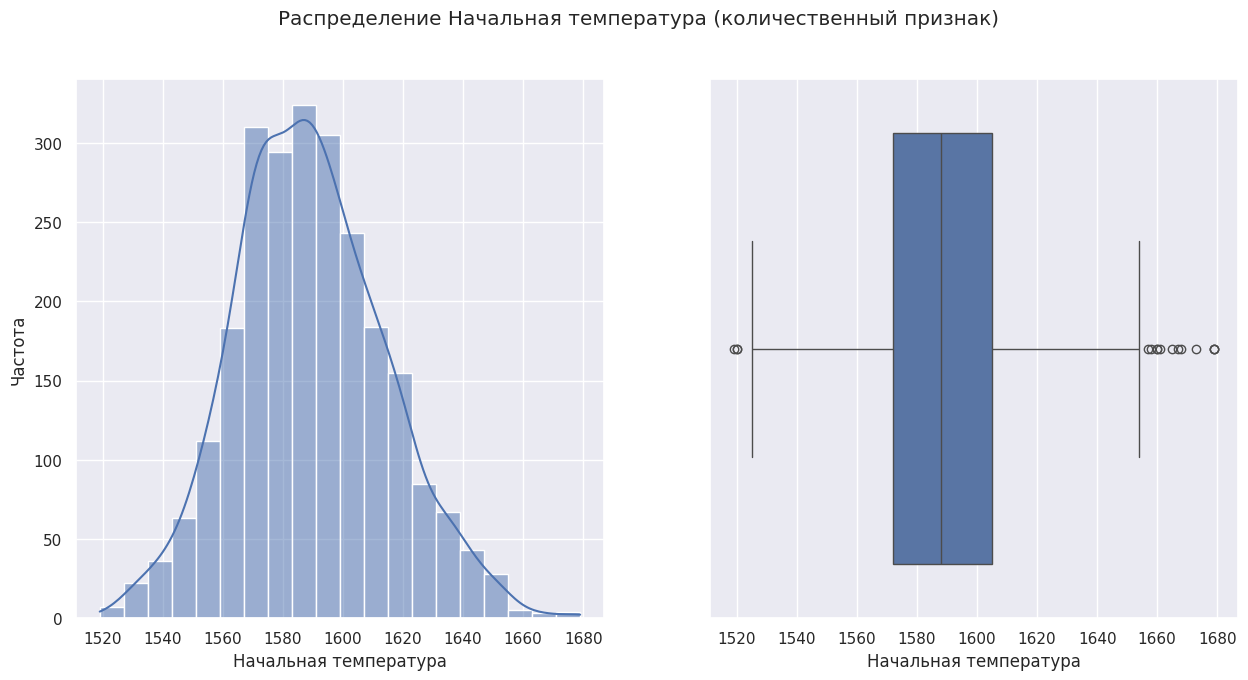

count    2473.000000
mean     1589.016175
std        24.996127
min      1519.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: Начальная температура, dtype: float64


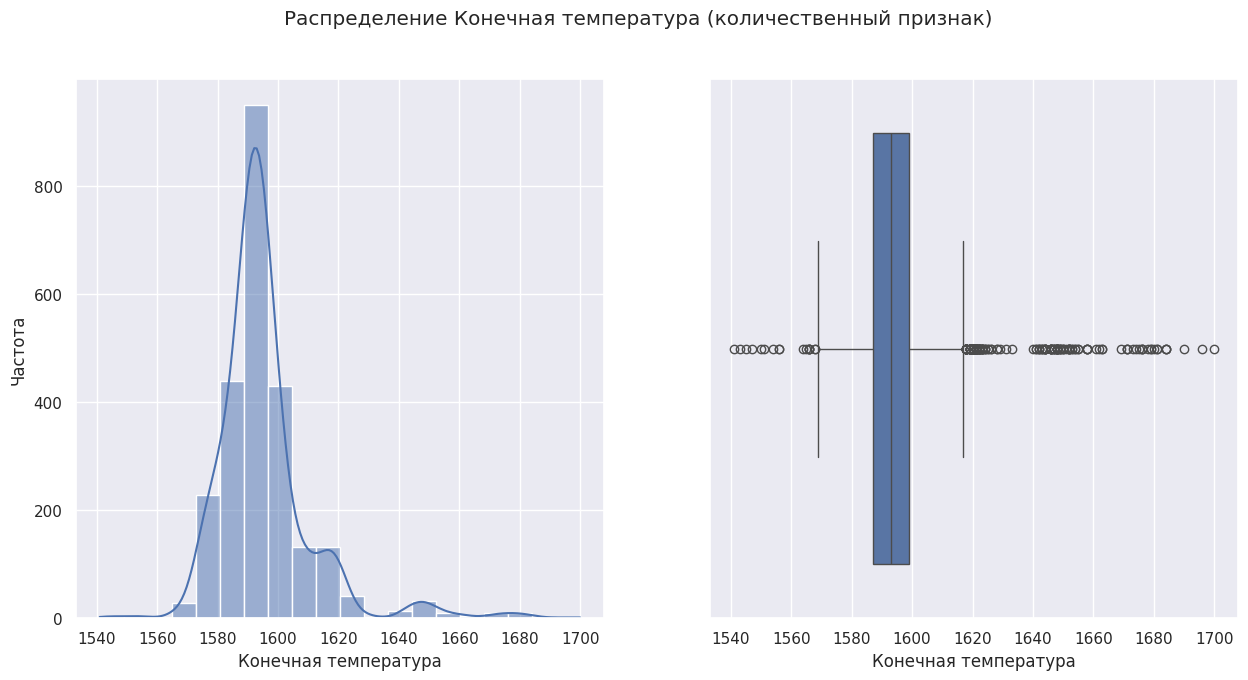

count    2473.000000
mean     1595.338051
std        16.031388
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: Конечная температура, dtype: float64


In [51]:
# Изучение данных о измерении температуры
for name in data_temp_main.select_dtypes(include=['float64', 'int64']).columns.tolist():
    if name != 'key':
        viz_num_variable(data_temp_main, name)
        print(data_temp_main[name].describe())

In [52]:
data_temp_main.head()

Начальная температура  Конечная температура
key                                             
1                     1571                  1613
2                     1581                  1602
3                     1596                  1599
4                     1601                  1625
5                     1576                  1602

### Данные о проволочных материалах (объём)

In [53]:
# Заполнение недостоющих данных
data_wire = data_wire.fillna(0)

In [54]:
# Изучение даных о проволочных материалах
data_wire.head(20)

key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0     1   60.059998   0.000000     0.0     0.0     0.0     0.0     0.0   
1     2   96.052315   0.000000     0.0     0.0     0.0     0.0     0.0   
2     3   91.160157   0.000000     0.0     0.0     0.0     0.0     0.0   
3     4   89.063515   0.000000     0.0     0.0     0.0     0.0     0.0   
4     5   89.238236   9.114560     0.0     0.0     0.0     0.0     0.0   
5     6   99.109917   9.114560     0.0     0.0     0.0     0.0     0.0   
6     7   98.061600   0.000000     0.0     0.0     0.0     0.0     0.0   
7     8  155.282394   0.000000     0.0     0.0     0.0     0.0     0.0   
8     9  113.393279   9.143681     0.0     0.0     0.0     0.0     0.0   
9    10   81.244796  12.376000     0.0     0.0     0.0     0.0     0.0   
10   11   99.197281   0.000000     0.0     0.0     0.0     0.0     0.0   
11   12  153.578873   0.000000     0.0     0.0     0.0     0.0     0.0   
12   13   77.269920  52.416003     0.0     0.0     0.0     0.0     0.0   
13   14  120.251038  37.826881     0.0     0.0     0.0     0.0     0.0   
14   15   71.285759  52.095680     0.0     0.0     0.0     0.0     0.0   
15   16  100.114563  43.097599     0.0     0.0     0.0     0.0     0.0   
16   17  110.204636  50.144638     0.0     0.0     0.0     0.0     0.0   
17   18   88.233596  32.148487     0.0     0.0     0.0     0.0     0.0   
18   19  113.218552  75.304322     0.0     0.0     0.0     0.0     0.0   
19   20  105.137756  72.275840     0.0     0.0     0.0     0.0     0.0   

    Wire 8  Wire 9  
0      0.0     0.0  
1      0.0     0.0  
2      0.0     0.0  
3      0.0     0.0  
4      0.0     0.0  
5      0.0     0.0  
6      0.0     0.0  
7      0.0     0.0  
8      0.0     0.0  
9      0.0     0.0  
10     0.0     0.0  
11     0.0     0.0  
12     0.0     0.0  
13     0.0     0.0  
14     0.0     0.0  
15     0.0     0.0  
16     0.0     0.0  
17     0.0     0.0  
18     0.0     0.0  
19     0.0     0.0

In [55]:
data_wire.describe()

key       Wire 1       Wire 2       Wire 3       Wire 4  \
count  3081.000000  3081.000000  3081.000000  3081.000000  3081.000000   
mean   1623.426485   100.044411    17.712733     3.874524     0.261019   
std     932.996726    42.841120    33.517734    30.310417     4.293865   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%     823.000000    70.281120     0.000000     0.000000     0.000000   
50%    1619.000000   100.114563     0.000000     0.000000     0.000000   
75%    2434.000000   125.798405    23.162880     0.000000     0.000000   
max    3241.000000   330.314424   282.780152   385.008668   113.231044   

            Wire 5       Wire 6       Wire 7       Wire 8       Wire 9  
count  3081.000000  3081.000000  3081.000000  3081.000000  3081.000000  
mean      0.004911     1.137695     0.035842     0.330697     0.321492  
std       0.272615     8.958111     0.774190     4.392677     3.806904  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max      15.132000   180.454575    32.847674   102.762401    90.053604

### Выводы:
- Исследованы данные, необходимые для обучения модели;
- Обработаны пропуски и аномалии в данных;
- Созданы новые признаки в данных о электродах и изменении температуры;
- Данные объеденены в группы по партиям;
- Удалены партии с температурой ниже 1400°С и пропусками в замерах;
- Получено целевое значение - Конечная температура.


## Объединение данных

In [56]:
# Объединение данных
df_list = [data_bulk, data_gas, data_temp_main, data_wire]
data_all = data_arc_main.copy()

for data in df_list:
    data_all = data_all.merge(data, on=['key'], how='inner')

In [57]:
data_all.head(20)

key  Количество циклов нагрева  Активная мощность  Реактивная мощность  \
0     1                          5           0.607346             0.428564   
1     2                          4           0.534852             0.363339   
2     3                          5           0.812728             0.587491   
3     4                          4           0.676622             0.514248   
4     5                          4           0.563238             0.421998   
5     6                          4           0.681319             0.470328   
6     7                          4           0.656719             0.490105   
7     8                          4           0.669739             0.524238   
8     9                          5           0.704164             0.505473   
9    10                          6           0.519796             0.359157   
10   11                          5           0.600676             0.473785   
11   12                          4           0.559173             0.411624   
12   13                          6           0.571949             0.430354   
13   14                          6           0.718418             0.568734   
14   15                          5           0.554413             0.380989   
15   16                          3           0.518628             0.378790   
16   17                          5           0.925957             0.711557   
17   18                          5           0.708731             0.519032   
18   19                          3           0.792497             0.550456   
19   20                          5           0.613863             0.449178   

    Полная мощность  Время нагрева дугой  Затраты электроэнергии  Bulk 1  \
0          0.743747                 1098              770.282114       0   
1          0.647087                  811              481.760005       0   
2          1.003845                  655              722.837668       0   
3          0.850010                  741              683.455597       0   
4          0.704245                  869              512.169934       0   
5          0.828269                  952              839.231310       0   
6          0.820978                  673              613.576982       0   
7          0.851489                  913              619.129542       0   
8          0.867052                  625              570.113675       0   
9          0.631834                  825              533.482050       0   
10         0.765546                  627              437.897690       0   
11         0.694797                  739              580.426837      46   
12         0.716264                 1027              744.415352       0   
13         0.917409                 1235             1182.253053       0   
14         0.672868                  714              457.872635       0   
15         0.642473                  894              582.270410       0   
16         1.169537                  714              897.684569       0   
17         0.880208                  842              681.527178       0   
18         0.964935                  321              313.650413       0   
19         0.761283                  735              518.808550       0   

    Bulk 2  Bulk 3  ...  Конечная температура      Wire 1     Wire 2  Wire 3  \
0        0       0  ...                  1613   60.059998   0.000000     0.0   
1        0       0  ...                  1602   96.052315   0.000000     0.0   
2        0       0  ...                  1599   91.160157   0.000000     0.0   
3        0       0  ...                  1625   89.063515   0.000000     0.0   
4        0       0  ...                  1602   89.238236   9.114560     0.0   
5        0       0  ...                  1596   99.109917   9.114560     0.0   
6        0       0  ...                  1599   98.061600   0.000000     0.0   
7        0       0  ...                  1598  155.282394   0.000000     0.0   
8        0       0  ...                  1592  1

In [58]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2323 entries, 0 to 2322
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        2323 non-null   int64  
 1   Количество циклов нагрева  2323 non-null   int64  
 2   Активная мощность          2323 non-null   float64
 3   Реактивная мощность        2323 non-null   float64
 4   Полная мощность            2323 non-null   float64
 5   Время нагрева дугой        2323 non-null   int64  
 6   Затраты электроэнергии     2323 non-null   float64
 7   Bulk 1                     2323 non-null   int64  
 8   Bulk 2                     2323 non-null   int64  
 9   Bulk 3                     2323 non-null   int64  
 10  Bulk 4                     2323 non-null   int64  
 11  Bulk 5                     2323 non-null   int64  
 12  Bulk 6                     2323 non-null   int64  
 13  Bulk 7                     2323 non-null   int64

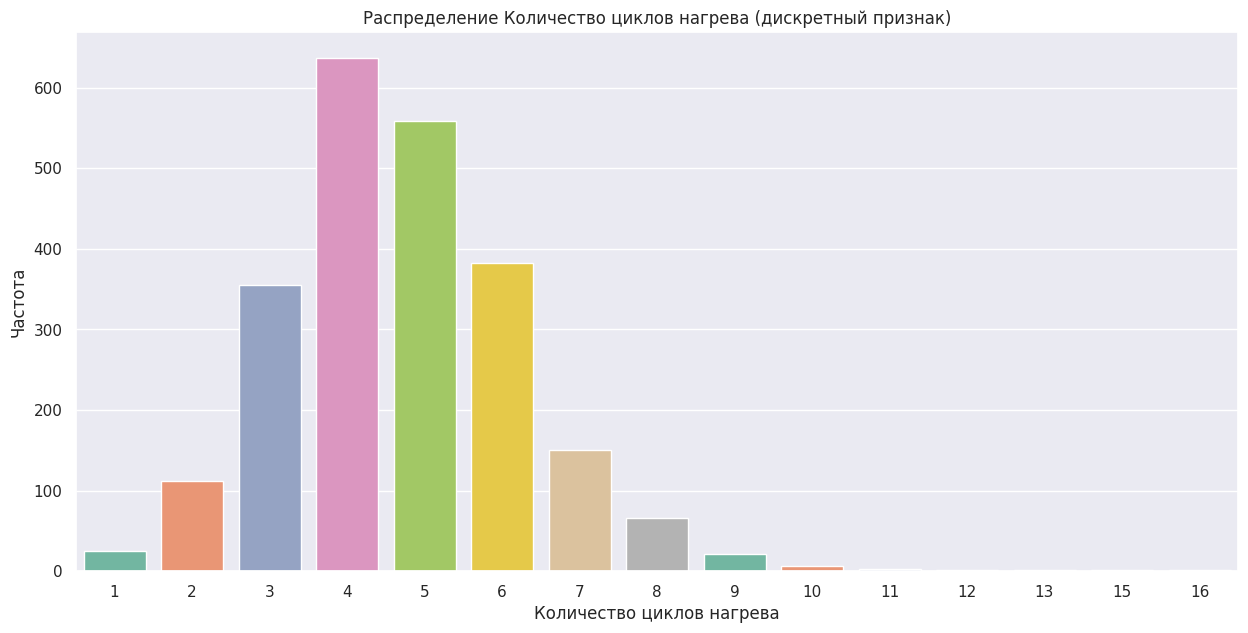

count    2323.000000
mean        4.692208
std         1.592257
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        16.000000
Name: Количество циклов нагрева, dtype: float64


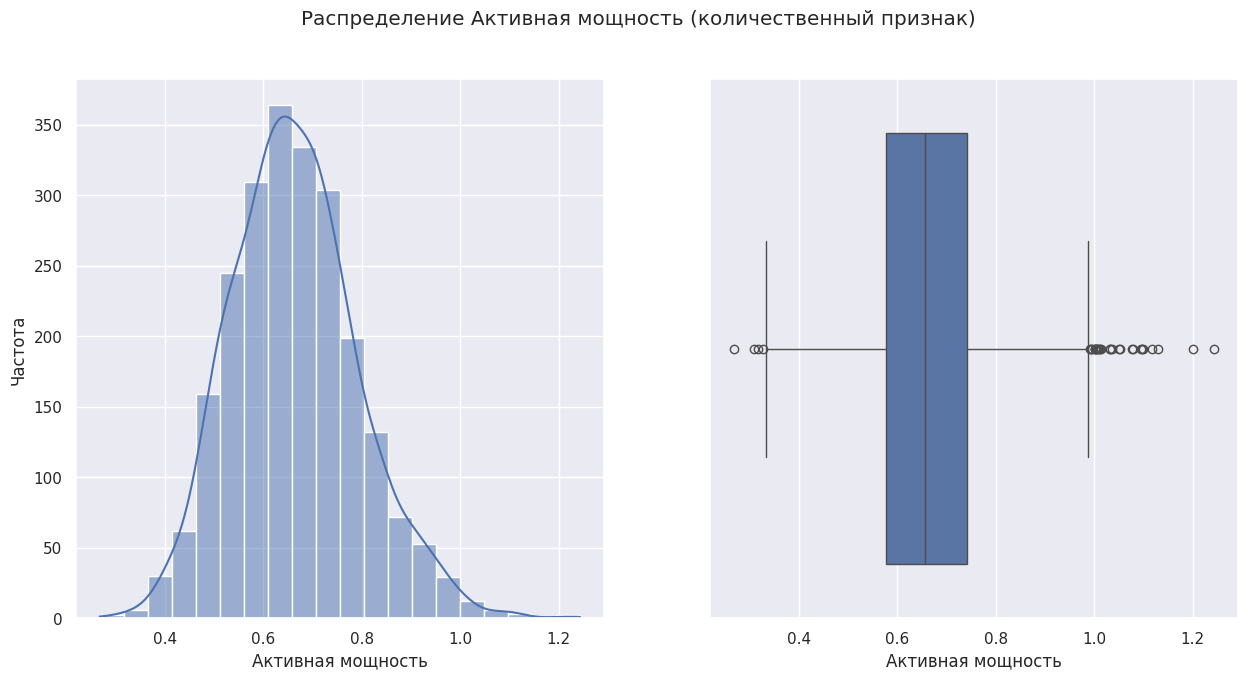

count    2323.000000
mean        0.664139
std         0.128403
min         0.267676
25%         0.576069
50%         0.655642
75%         0.741717
max         1.243889
Name: Активная мощность, dtype: float64


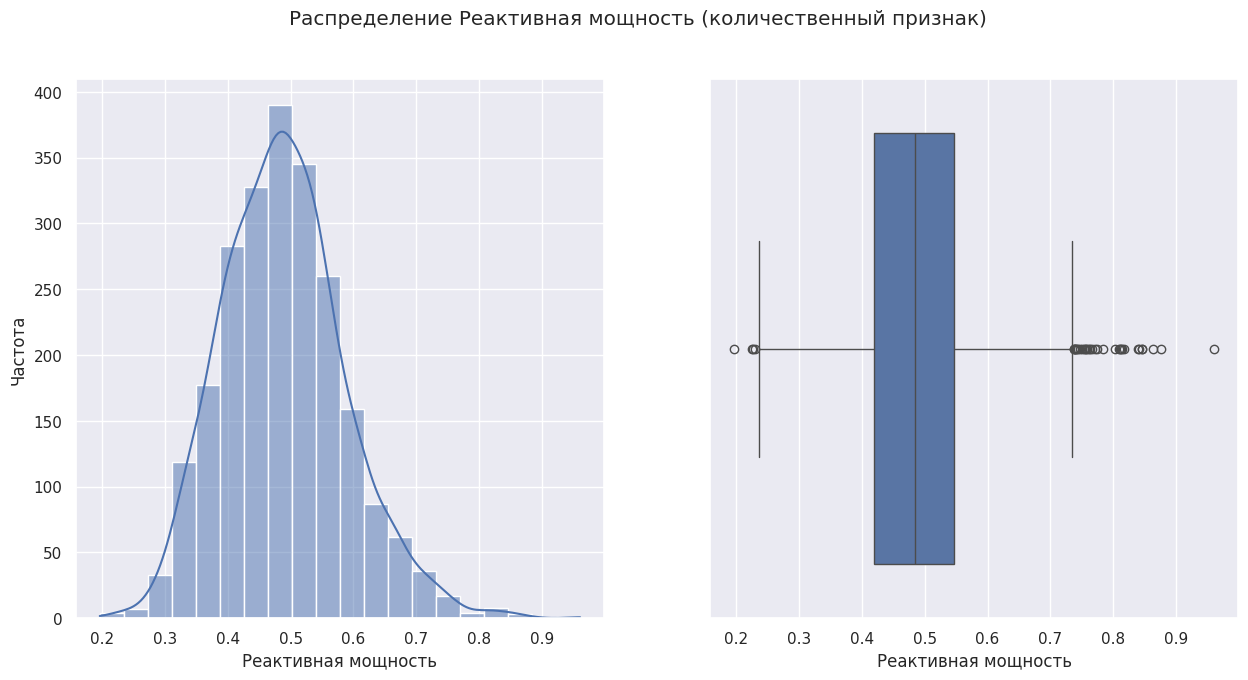

count    2323.000000
mean        0.488875
std         0.098020
min         0.196228
25%         0.420028
50%         0.484647
75%         0.546588
max         0.960763
Name: Реактивная мощность, dtype: float64


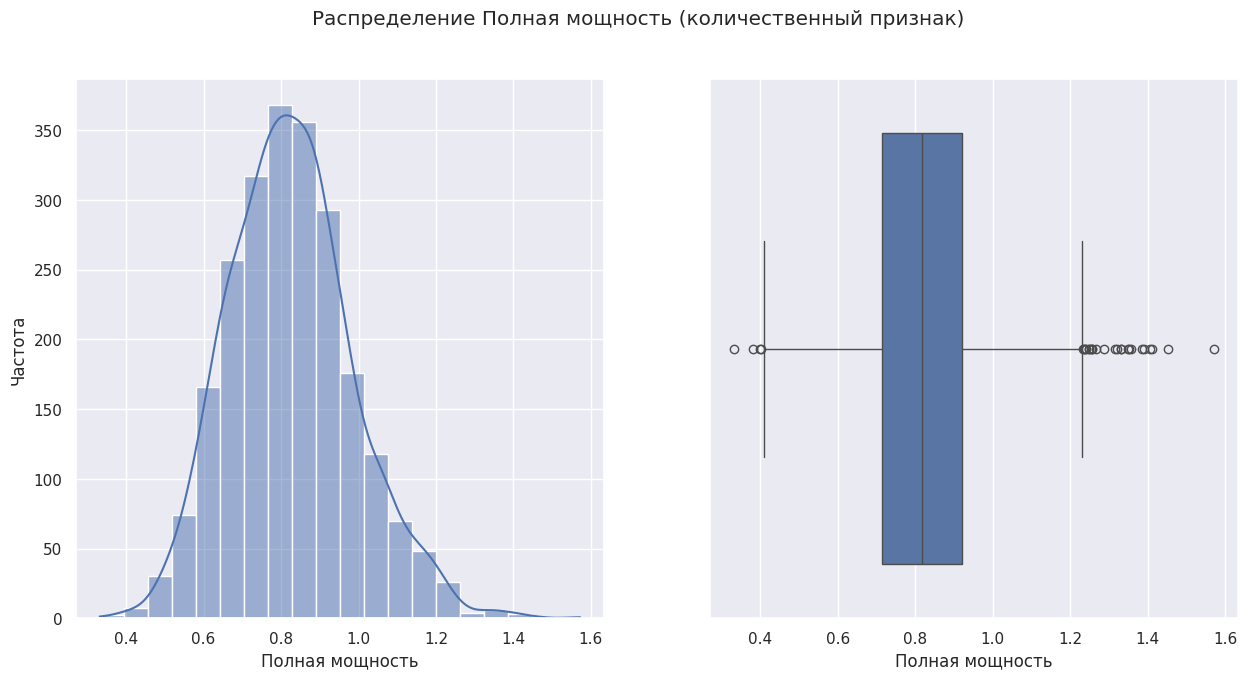

count    2323.000000
mean        0.825558
std         0.160395
min         0.331897
25%         0.714224
50%         0.818226
75%         0.921191
max         1.572238
Name: Полная мощность, dtype: float64


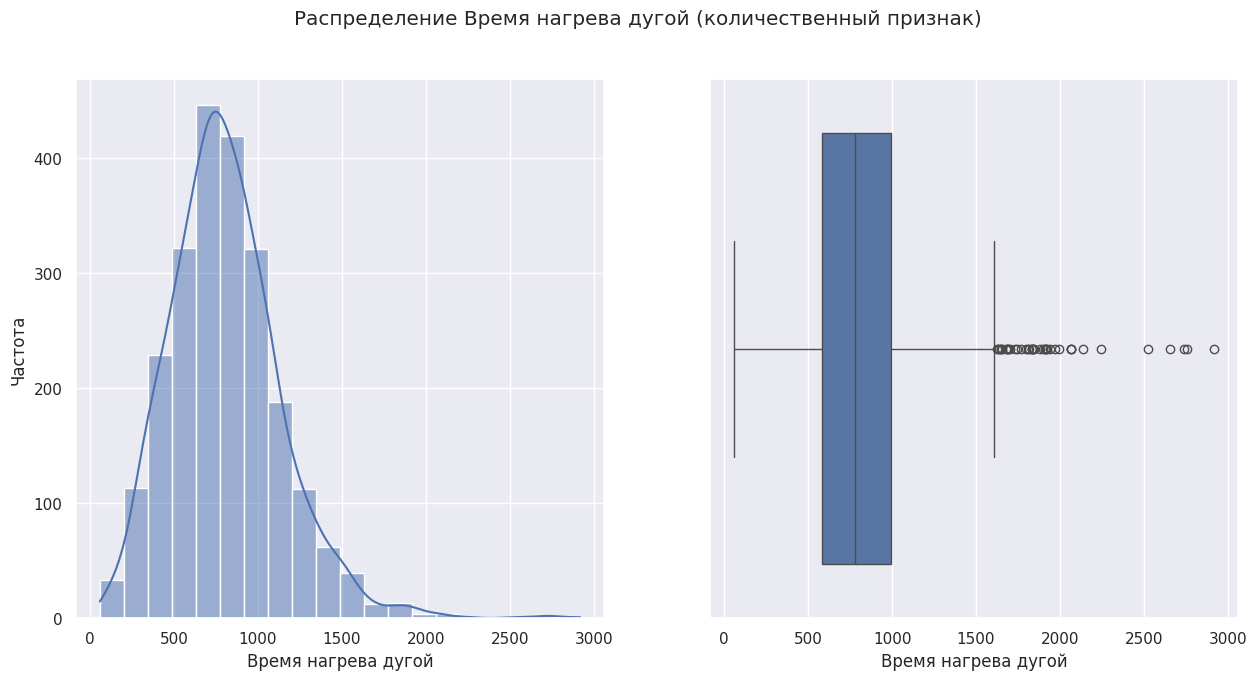

count    2323.000000
mean      806.741283
std       333.585913
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      2919.000000
Name: Время нагрева дугой, dtype: float64


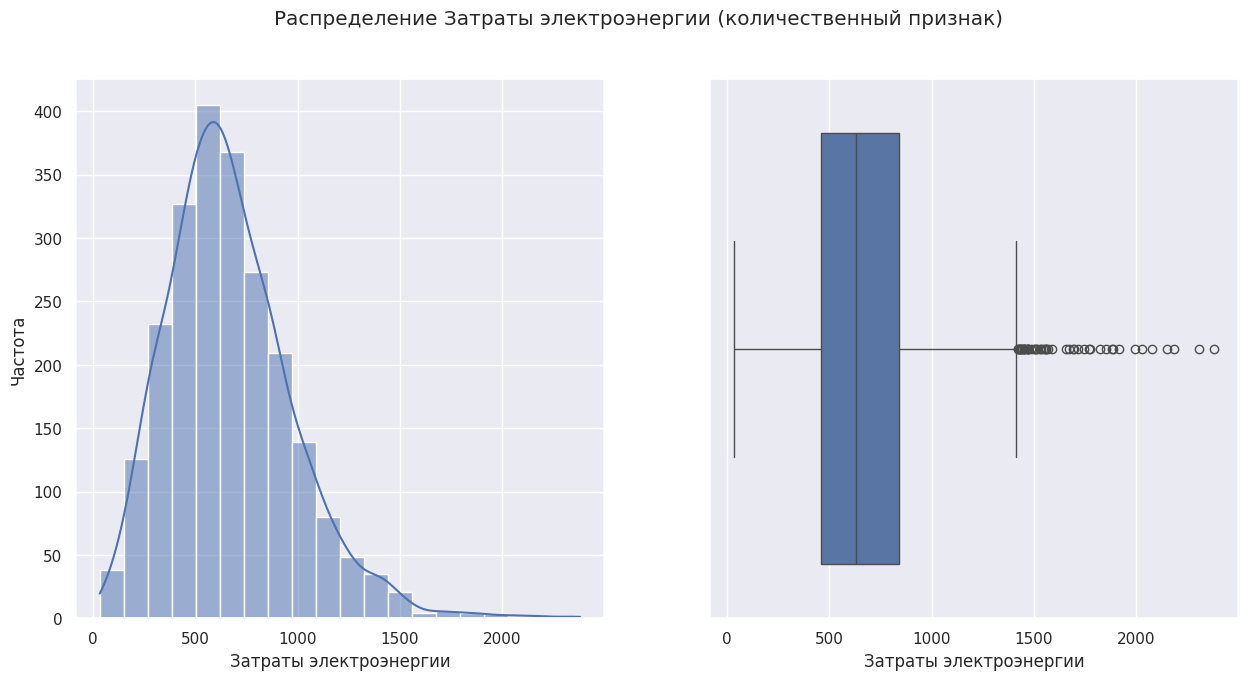

count    2323.000000
mean      668.563789
std       309.302290
min        33.430208
25%       457.907538
50%       630.913482
75%       841.521174
max      2380.879281
Name: Затраты электроэнергии, dtype: float64


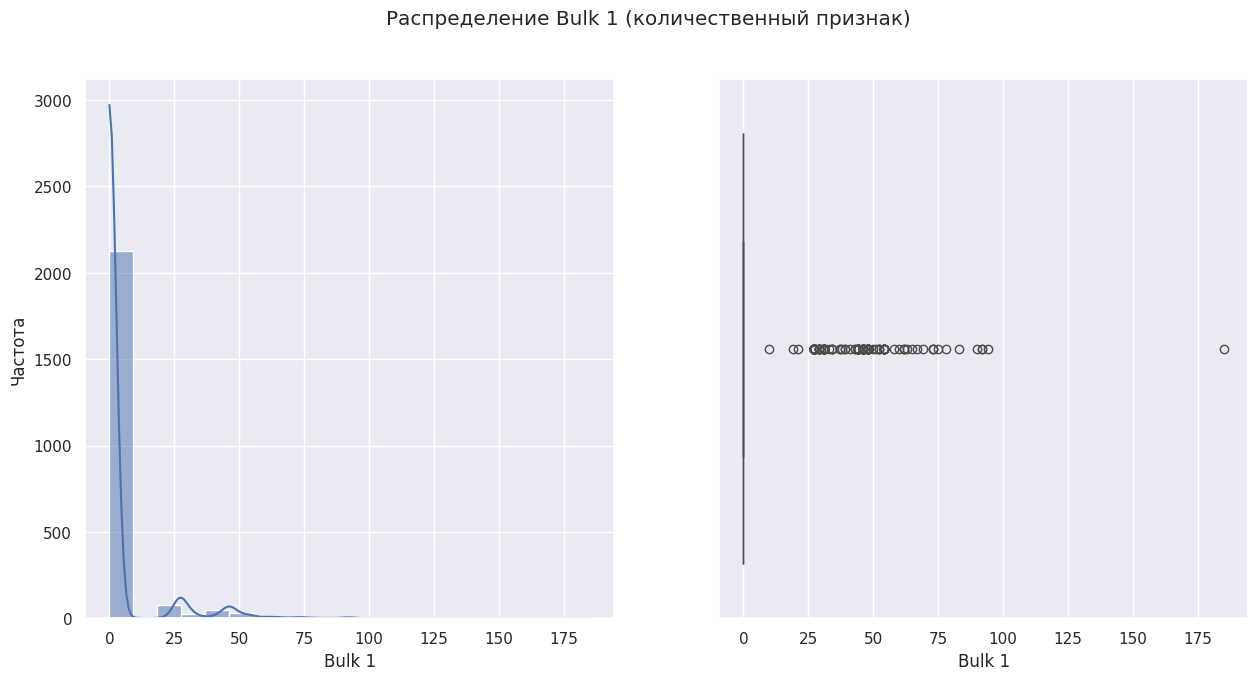

count    2323.000000
mean        3.436505
std        12.426933
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       185.000000
Name: Bulk 1, dtype: float64


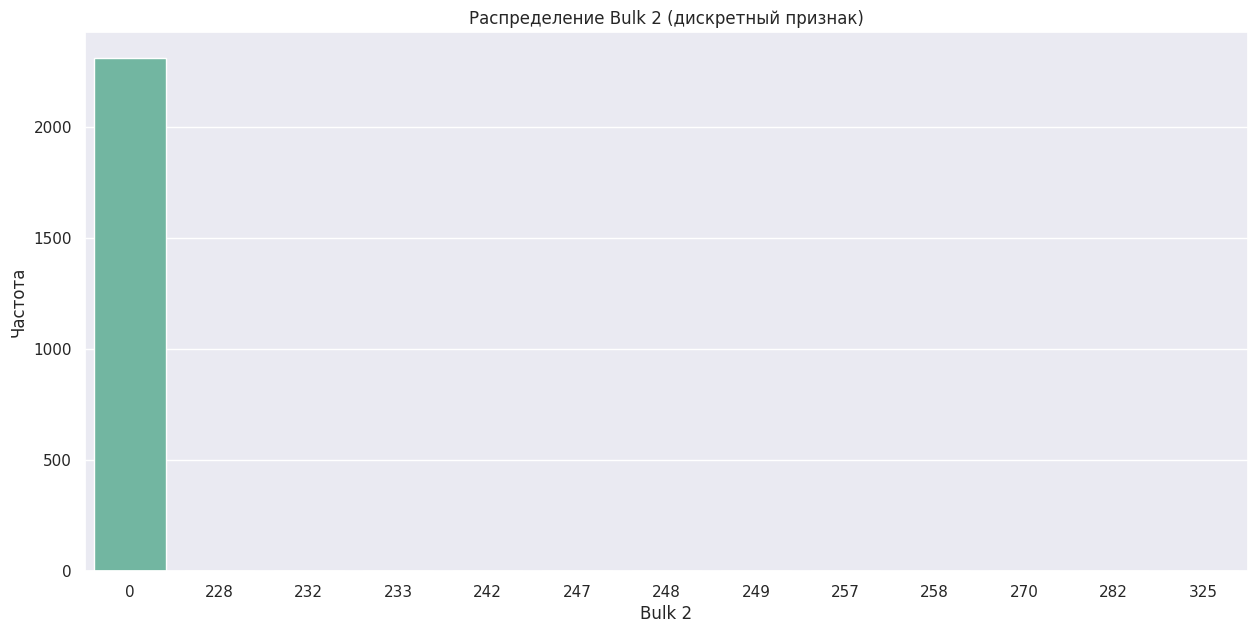

count    2323.000000
mean        1.426173
std        19.106620
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       325.000000
Name: Bulk 2, dtype: float64


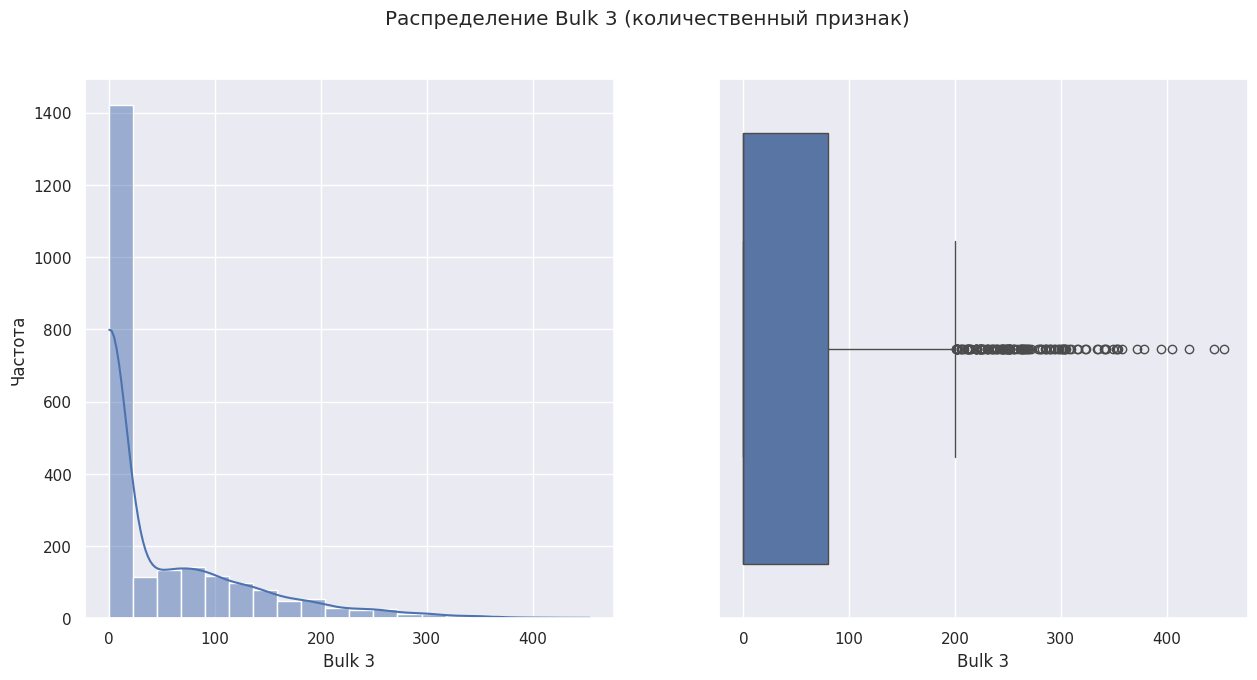

count    2323.000000
mean       47.337495
std        75.247840
min         0.000000
25%         0.000000
50%         0.000000
75%        80.000000
max       454.000000
Name: Bulk 3, dtype: float64


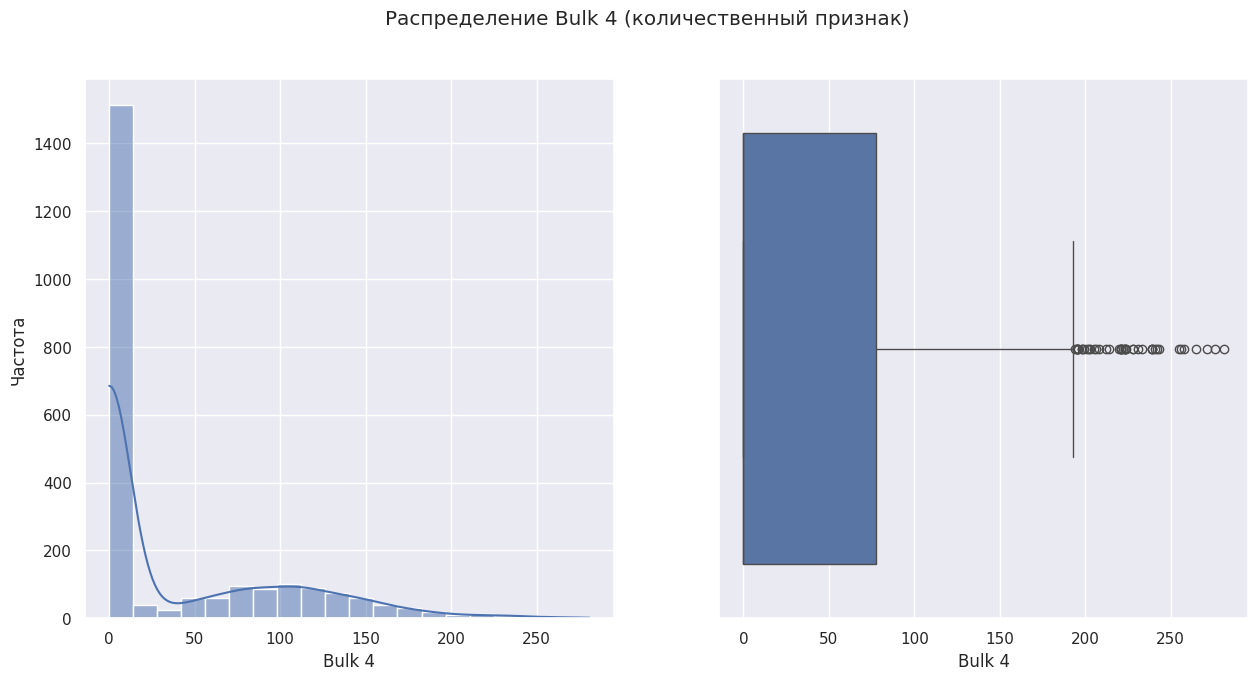

count    2323.000000
mean       37.363754
std        58.685404
min         0.000000
25%         0.000000
50%         0.000000
75%        77.500000
max       281.000000
Name: Bulk 4, dtype: float64


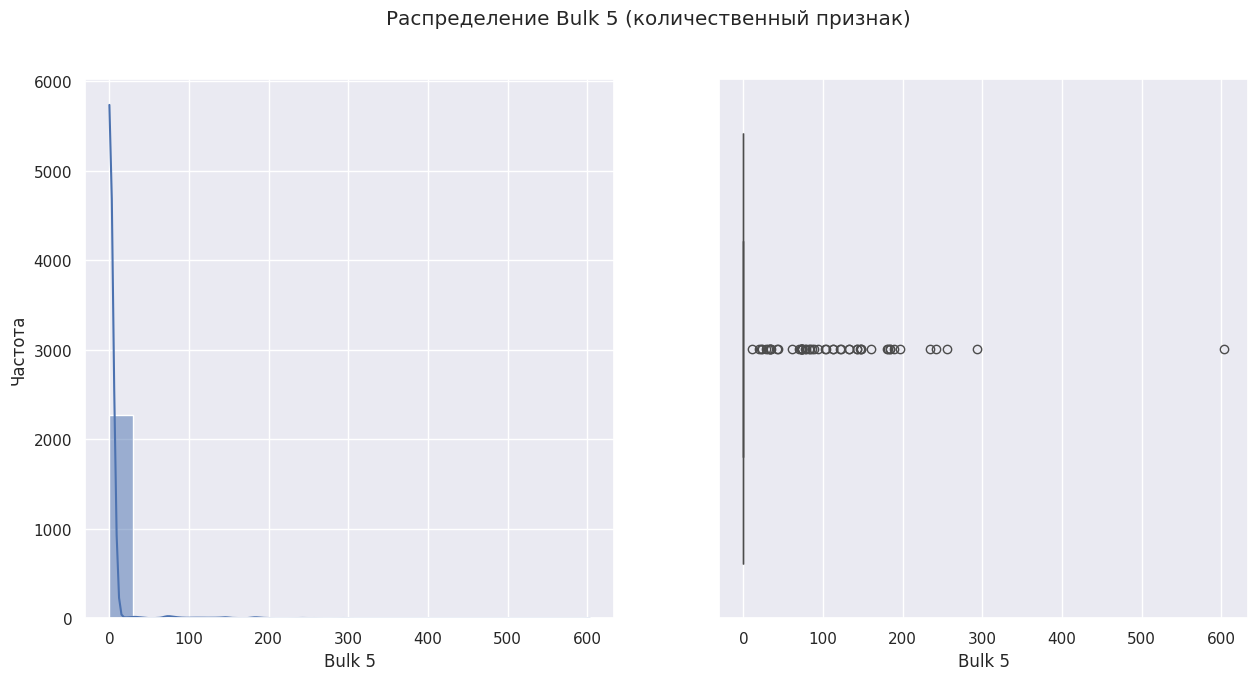

count    2323.000000
mean        2.647008
std        22.430816
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       603.000000
Name: Bulk 5, dtype: float64


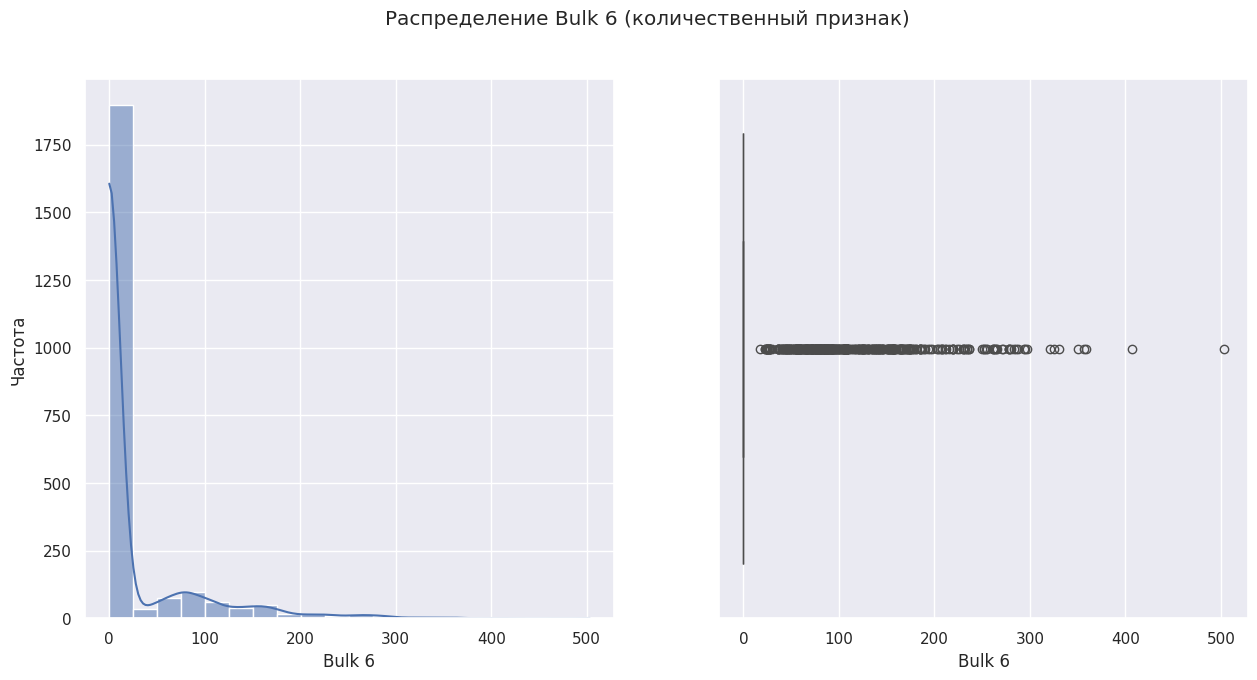

count    2323.000000
mean       22.322858
std        55.609480
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       503.000000
Name: Bulk 6, dtype: float64


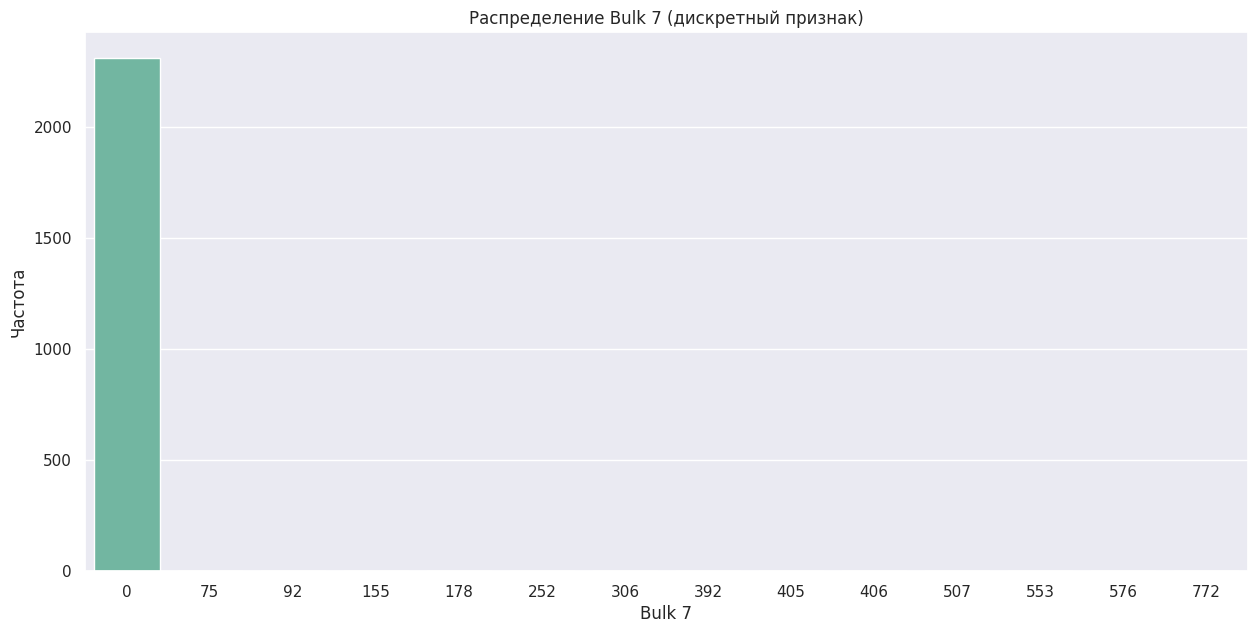

count    2323.000000
mean        2.009901
std        30.715672
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       772.000000
Name: Bulk 7, dtype: float64


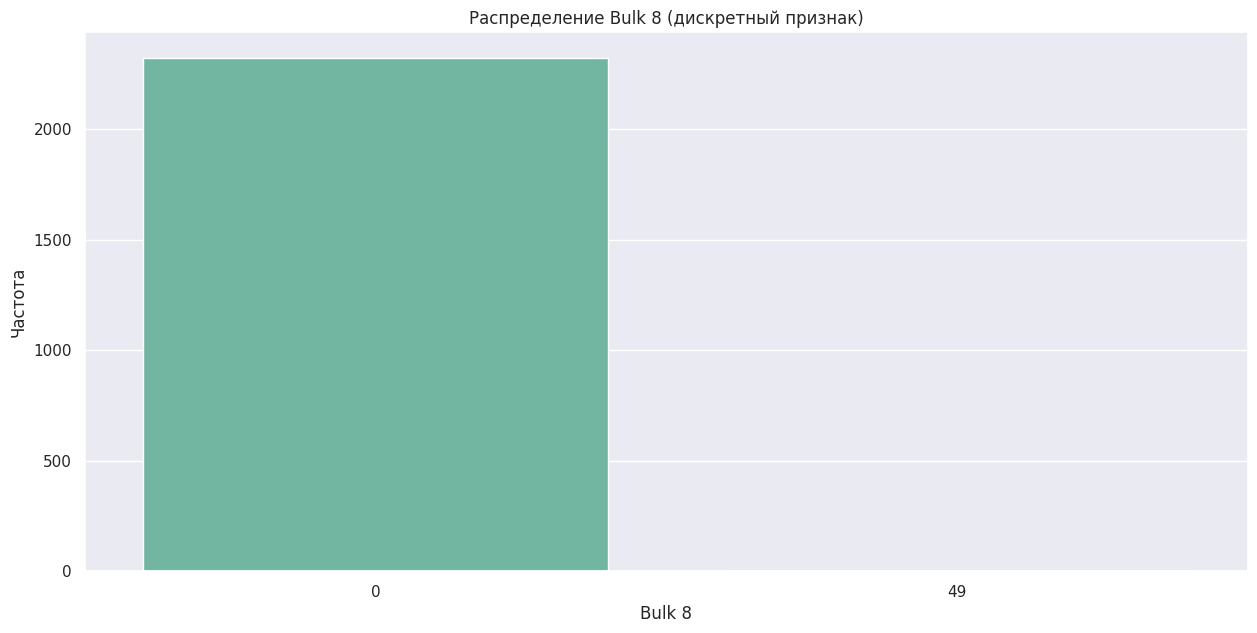

count    2323.000000
mean        0.021093
std         1.016650
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        49.000000
Name: Bulk 8, dtype: float64


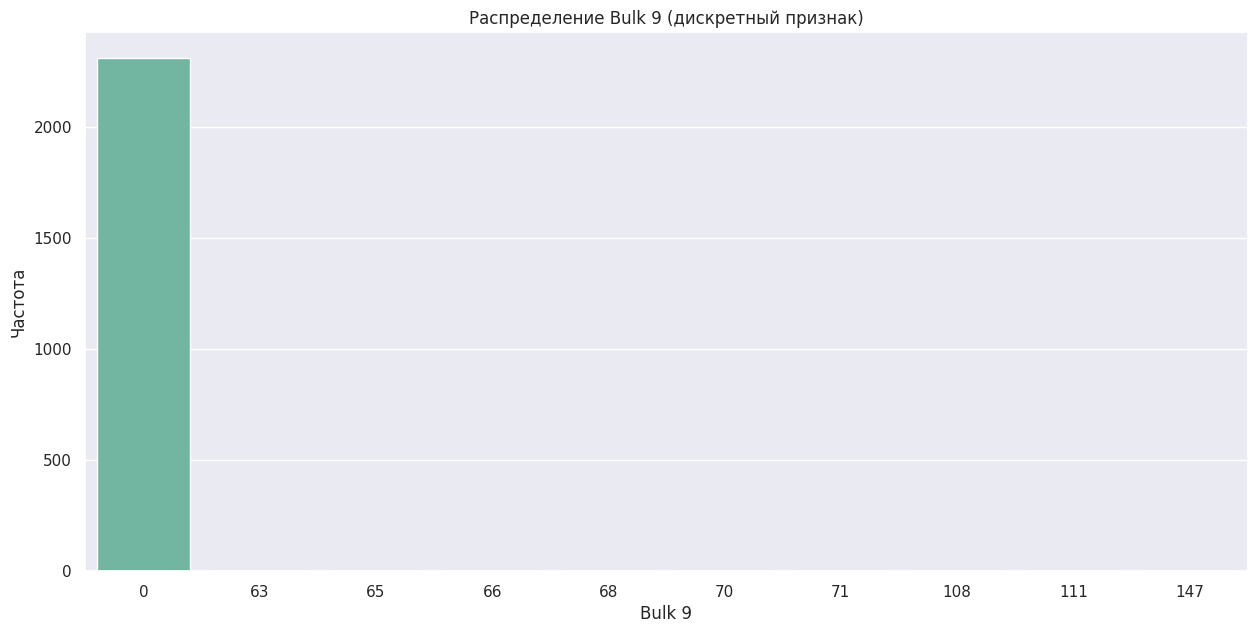

count    2323.000000
mean        0.445975
std         6.228632
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       147.000000
Name: Bulk 9, dtype: float64


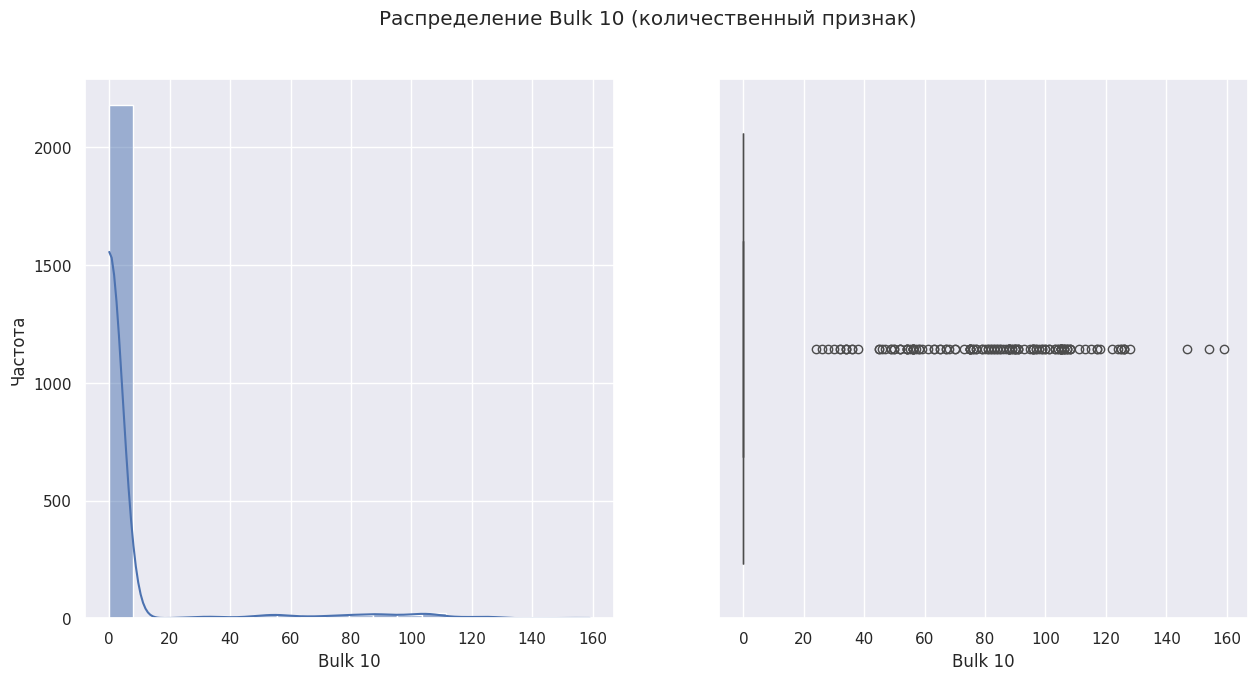

count    2323.000000
mean        5.065863
std        20.943229
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       159.000000
Name: Bulk 10, dtype: float64


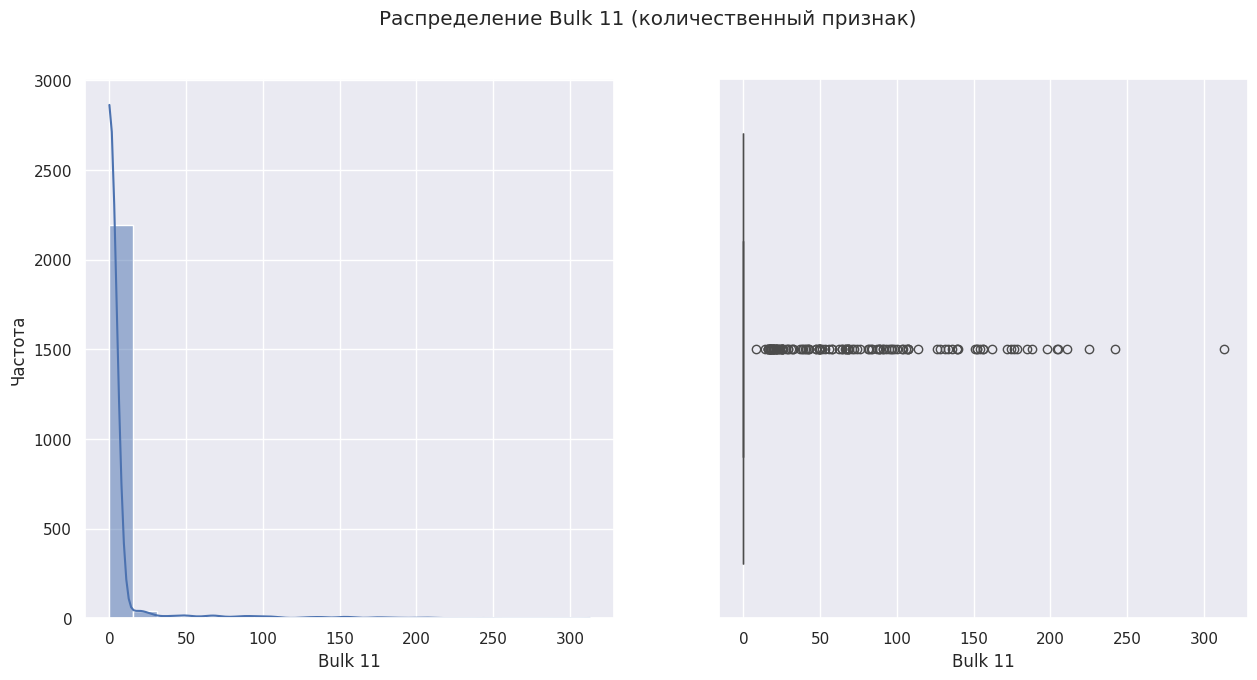

count    2323.000000
mean        4.256134
std        22.543523
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       313.000000
Name: Bulk 11, dtype: float64


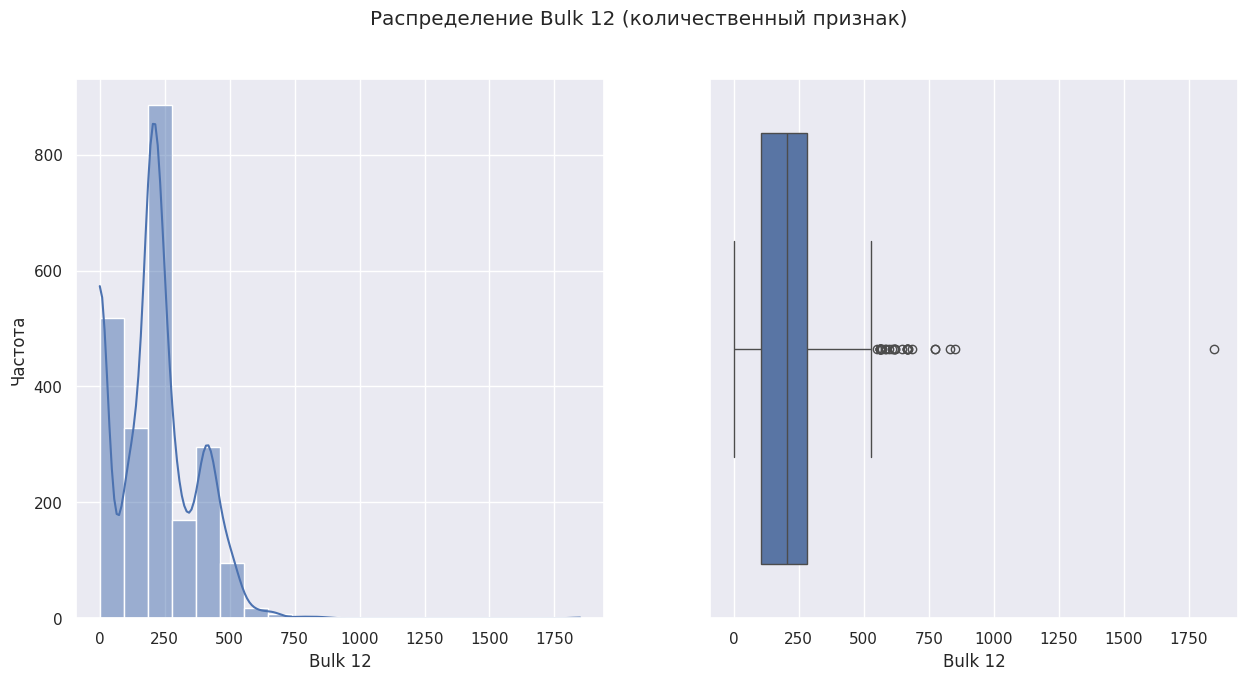

count    2323.000000
mean      208.371933
std       156.768509
min         0.000000
25%       105.000000
50%       206.000000
75%       282.500000
max      1849.000000
Name: Bulk 12, dtype: float64


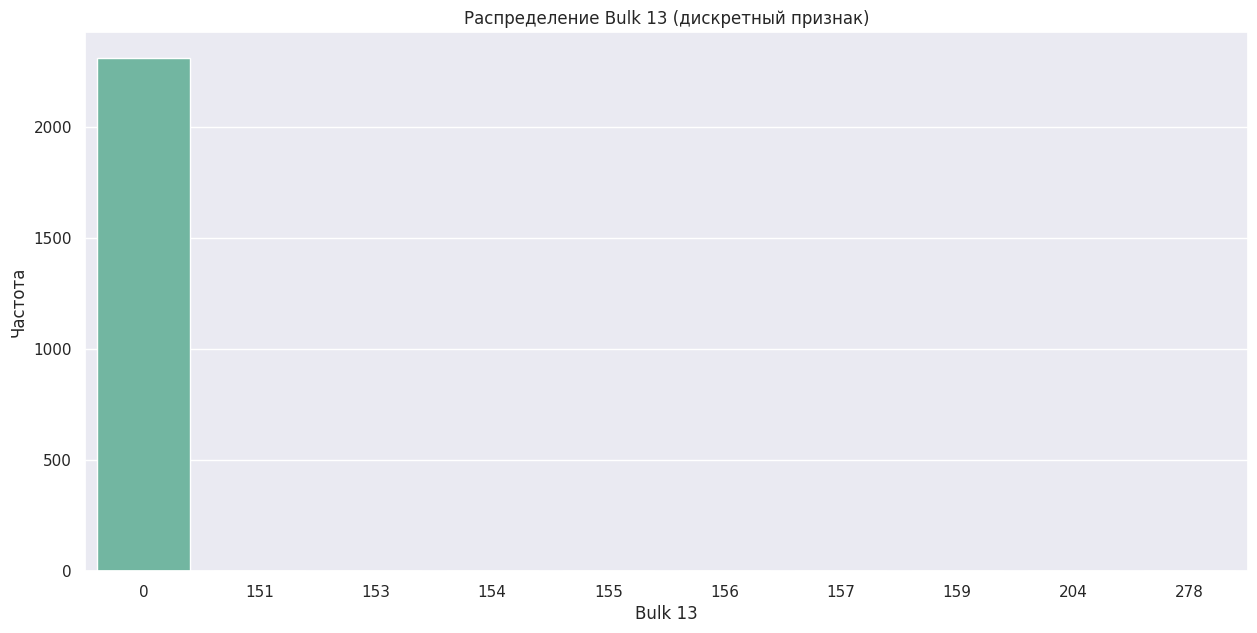

count    2323.000000
mean        0.938872
std        12.781192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       278.000000
Name: Bulk 13, dtype: float64


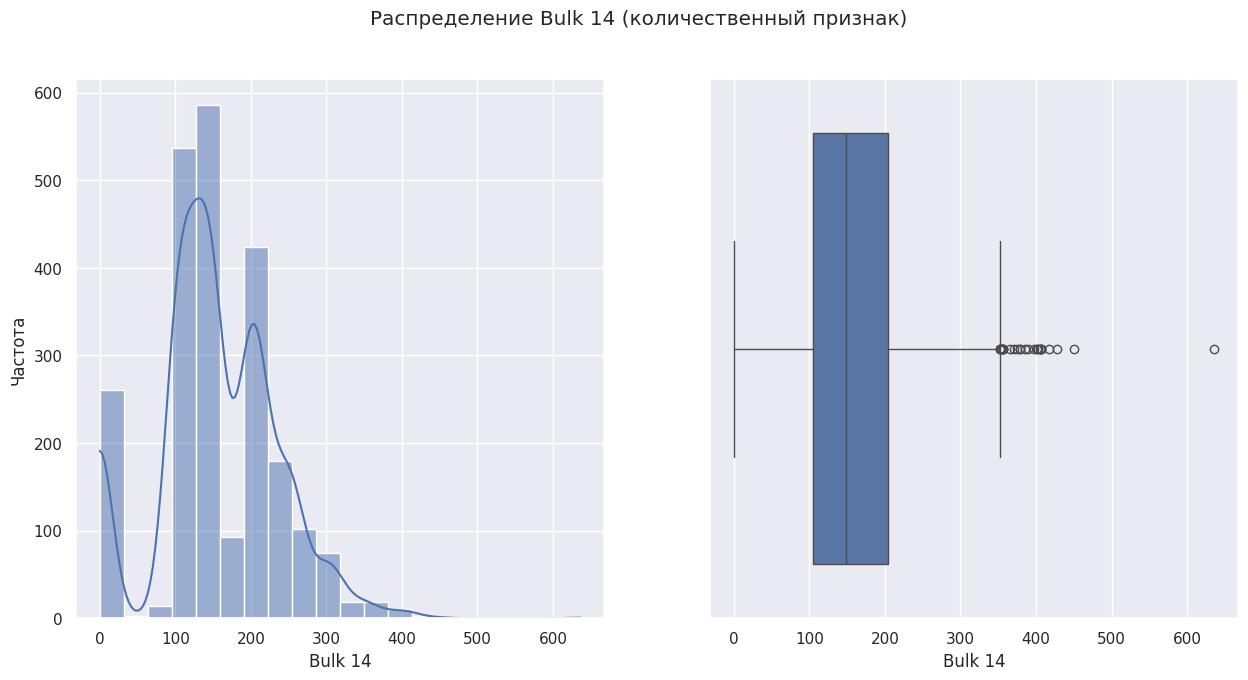

count    2323.000000
mean      153.912183
std        81.404669
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       636.000000
Name: Bulk 14, dtype: float64


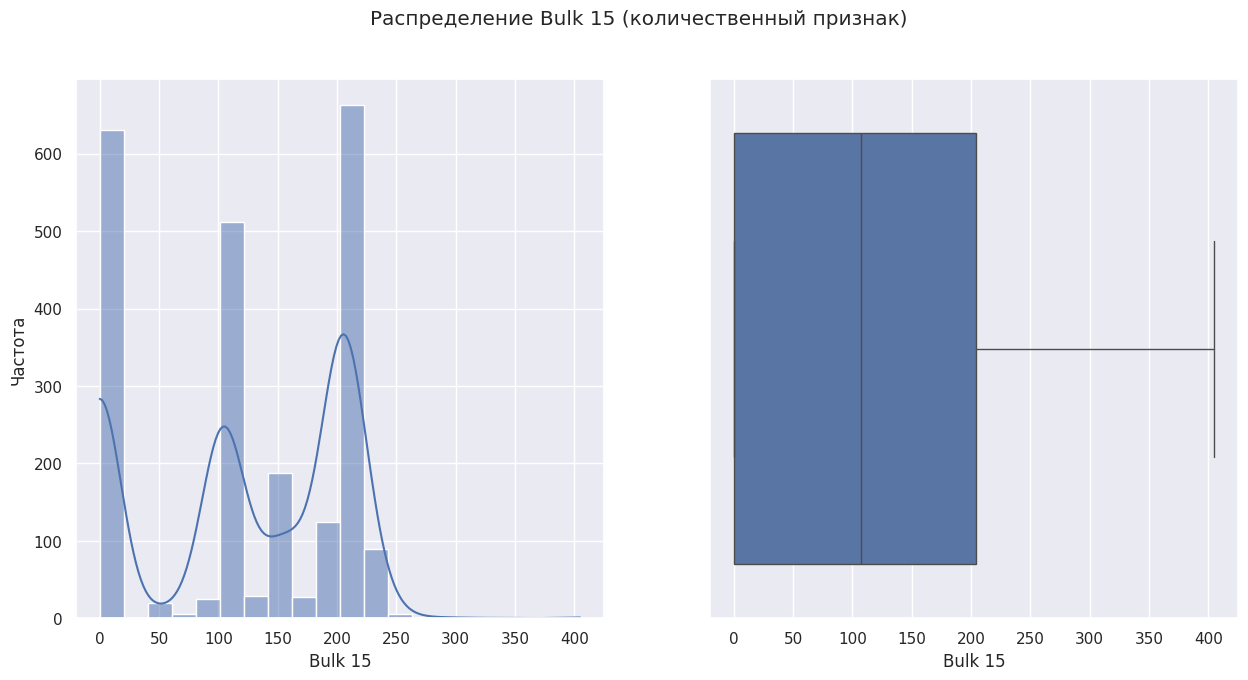

count    2323.000000
mean      120.033577
std        84.646713
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: Bulk 15, dtype: float64


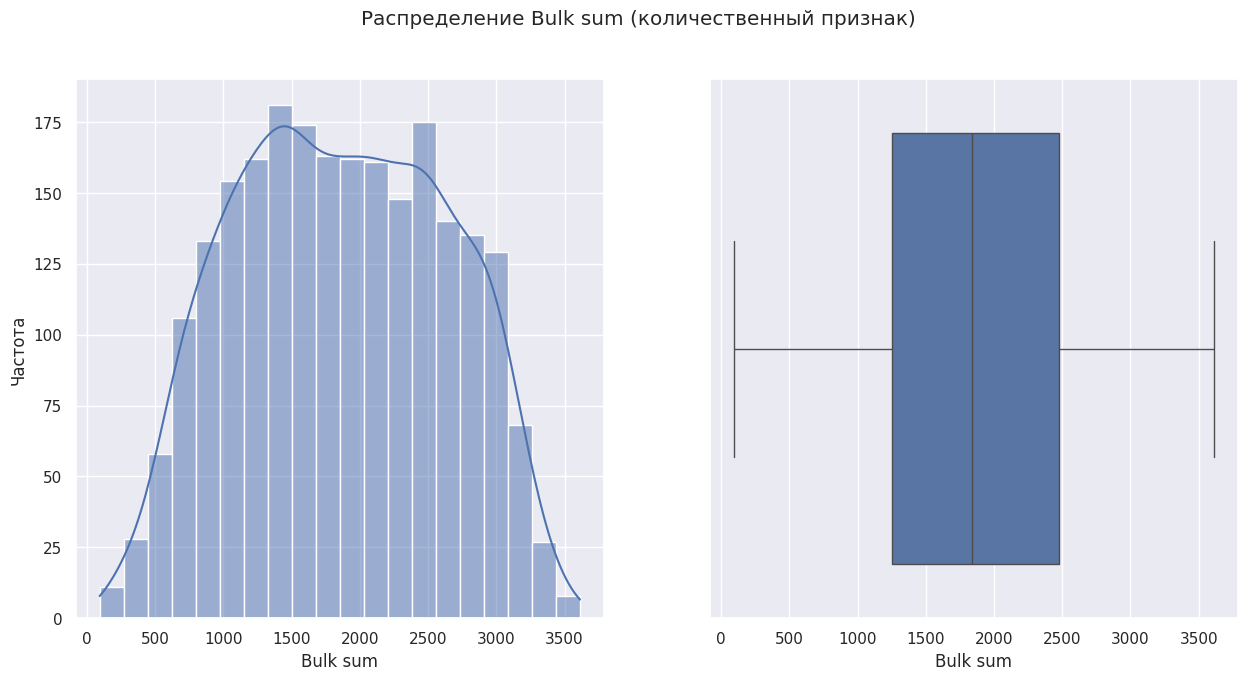

count    2323.000000
mean     1860.541111
std       763.427667
min        93.000000
25%      1254.500000
50%      1839.000000
75%      2479.000000
max      3613.000000
Name: Bulk sum, dtype: float64


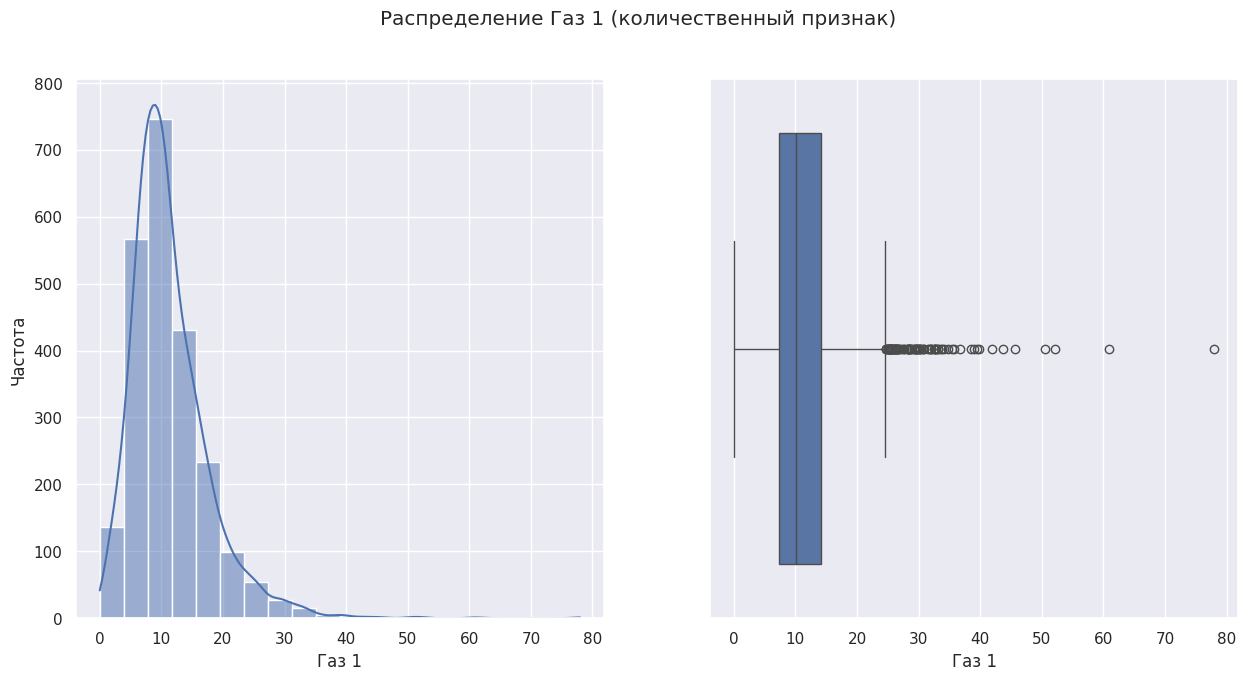

count    2323.000000
mean       11.369290
std         6.381743
min         0.008399
25%         7.282120
50%        10.100423
75%        14.217189
max        77.995040
Name: Газ 1, dtype: float64


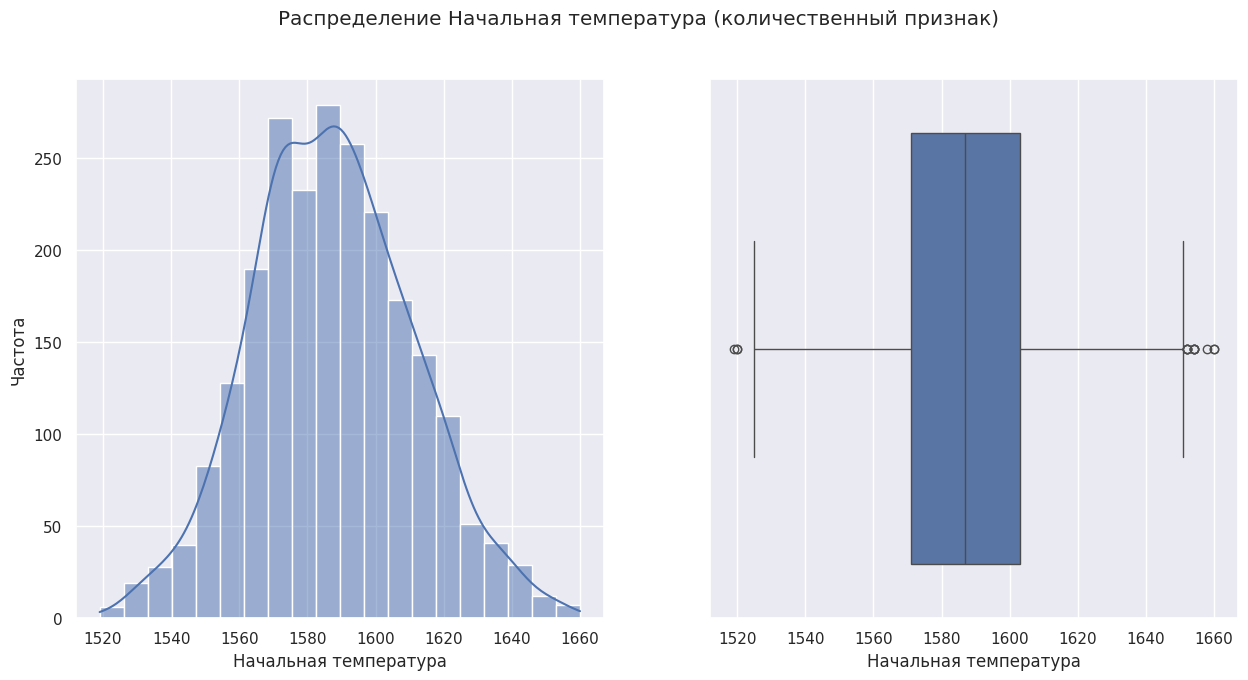

count    2323.000000
mean     1587.370641
std        23.632503
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: Начальная температура, dtype: float64


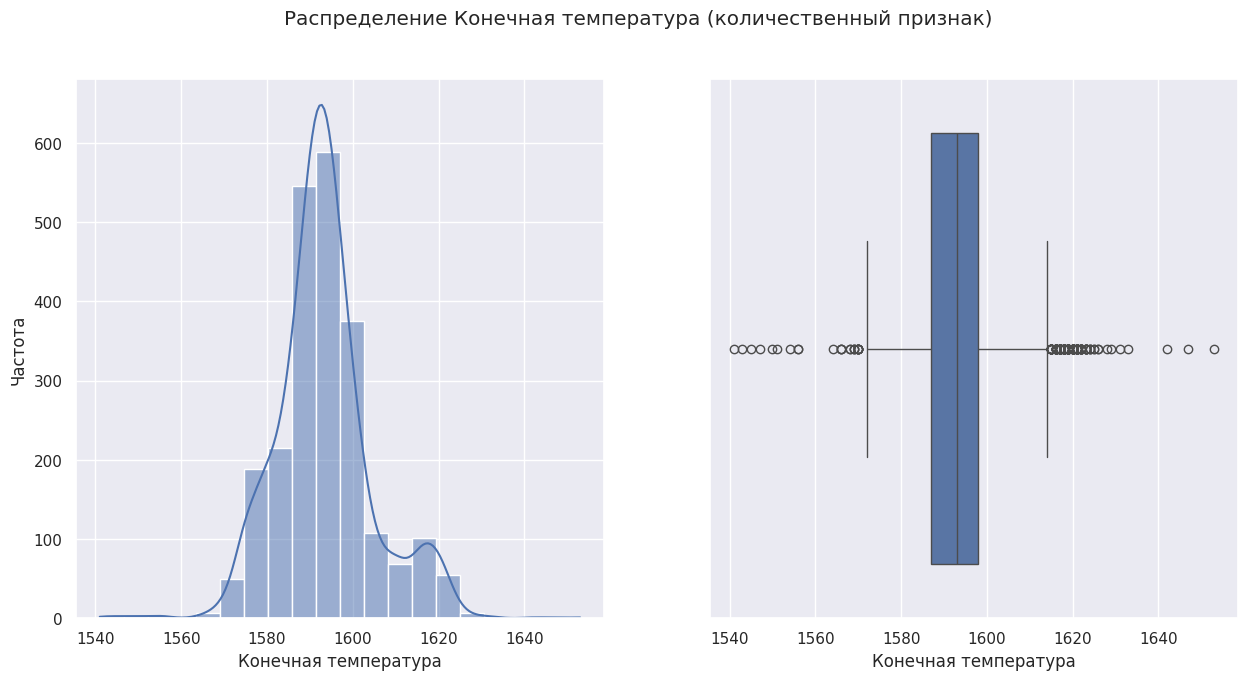

count    2323.000000
mean     1593.367198
std        11.206806
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: Конечная температура, dtype: float64


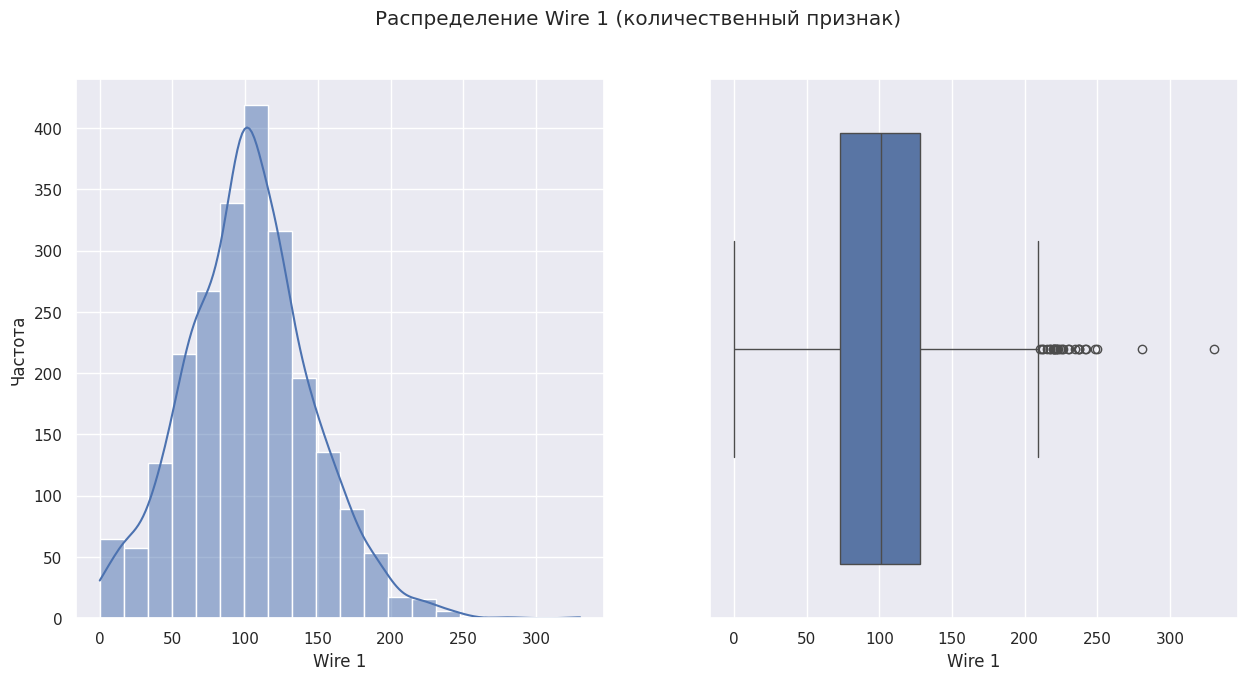

count    2323.000000
mean      102.387426
std        43.514823
min         0.000000
25%        73.201438
50%       101.087998
75%       127.916880
max       330.314424
Name: Wire 1, dtype: float64


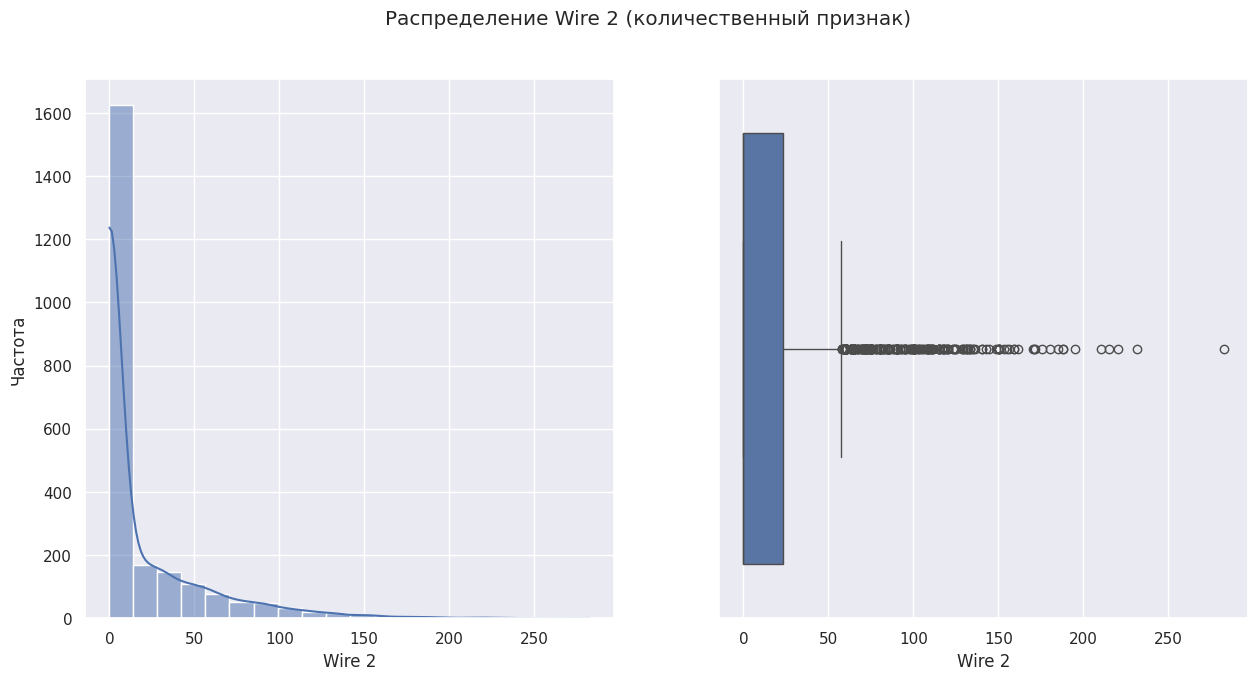

count    2323.000000
mean       17.620795
std        33.653435
min         0.000000
25%         0.000000
50%         0.000000
75%        23.102560
max       282.780152
Name: Wire 2, dtype: float64


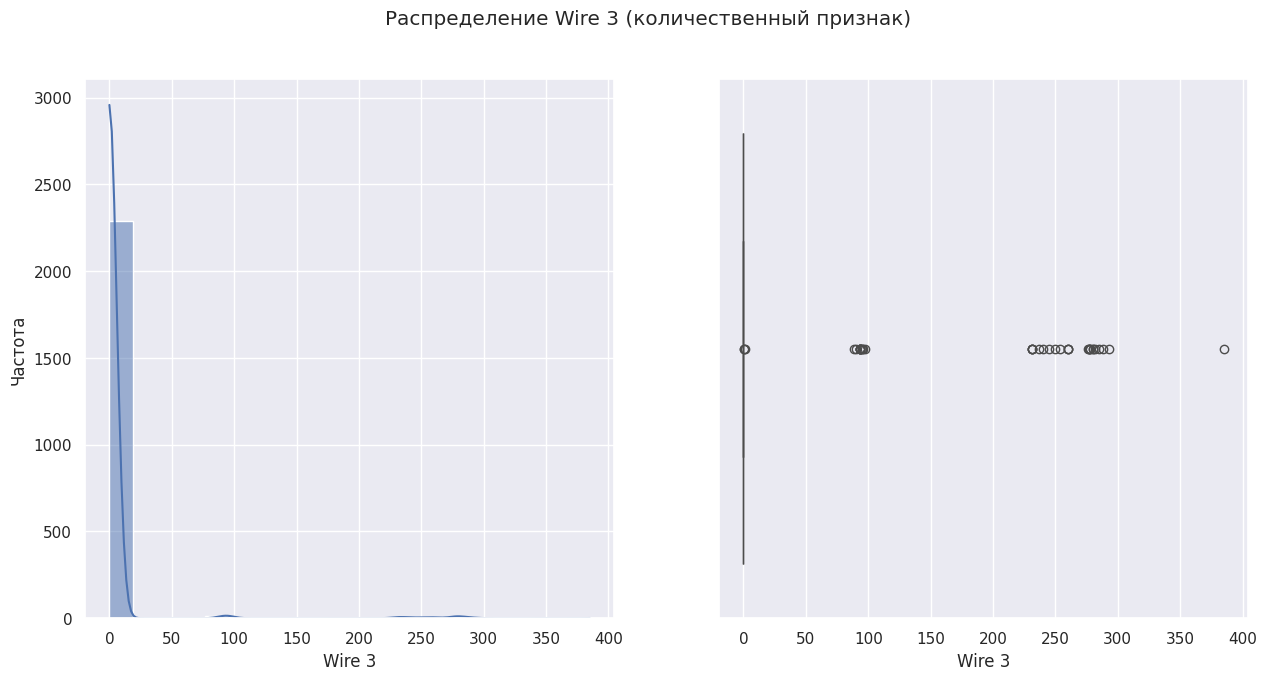

count    2323.000000
mean        3.243271
std        27.978465
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       385.008668
Name: Wire 3, dtype: float64


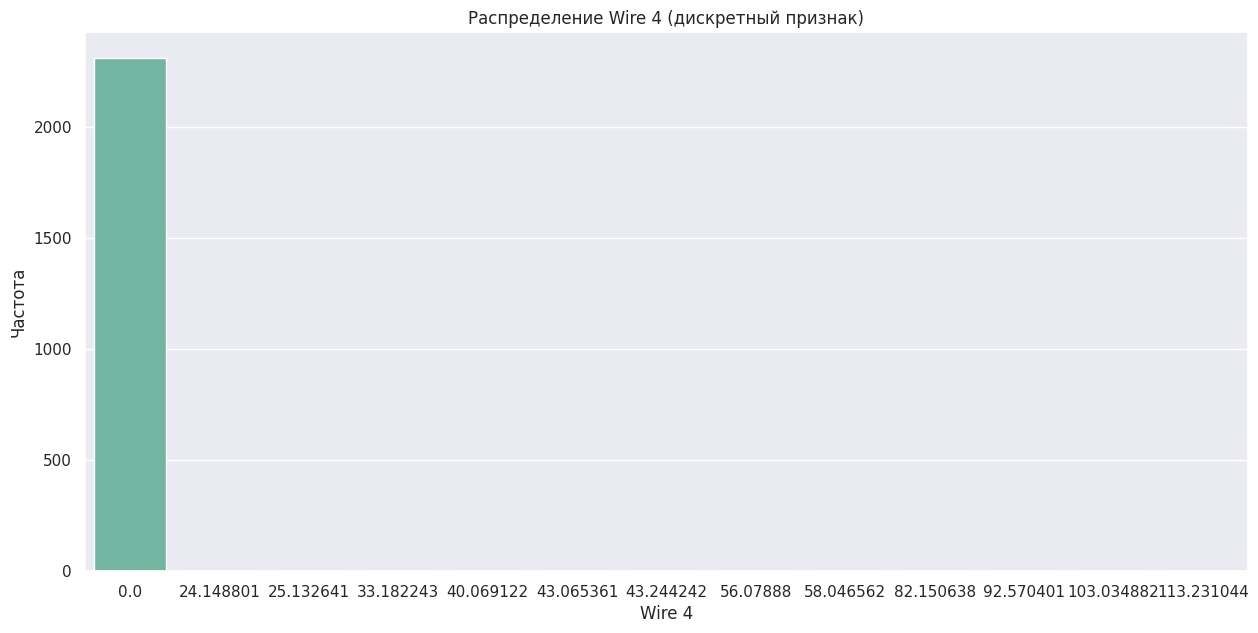

count    2323.000000
mean        0.307342
std         4.763863
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       113.231044
Name: Wire 4, dtype: float64


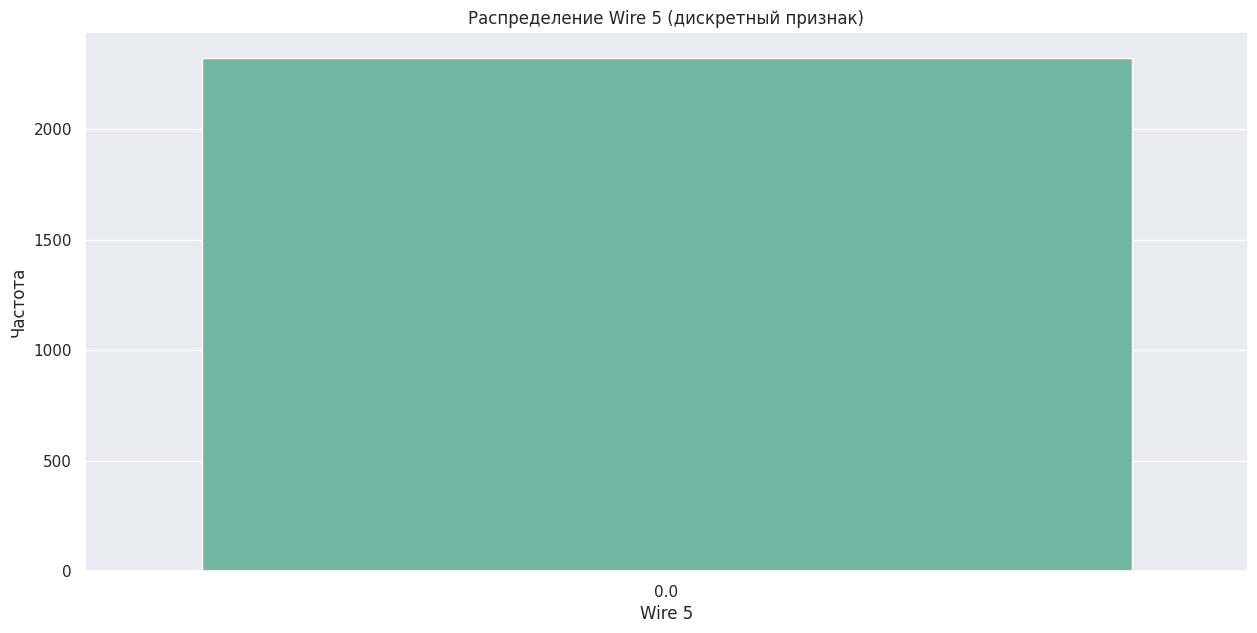

count    2323.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Wire 5, dtype: float64


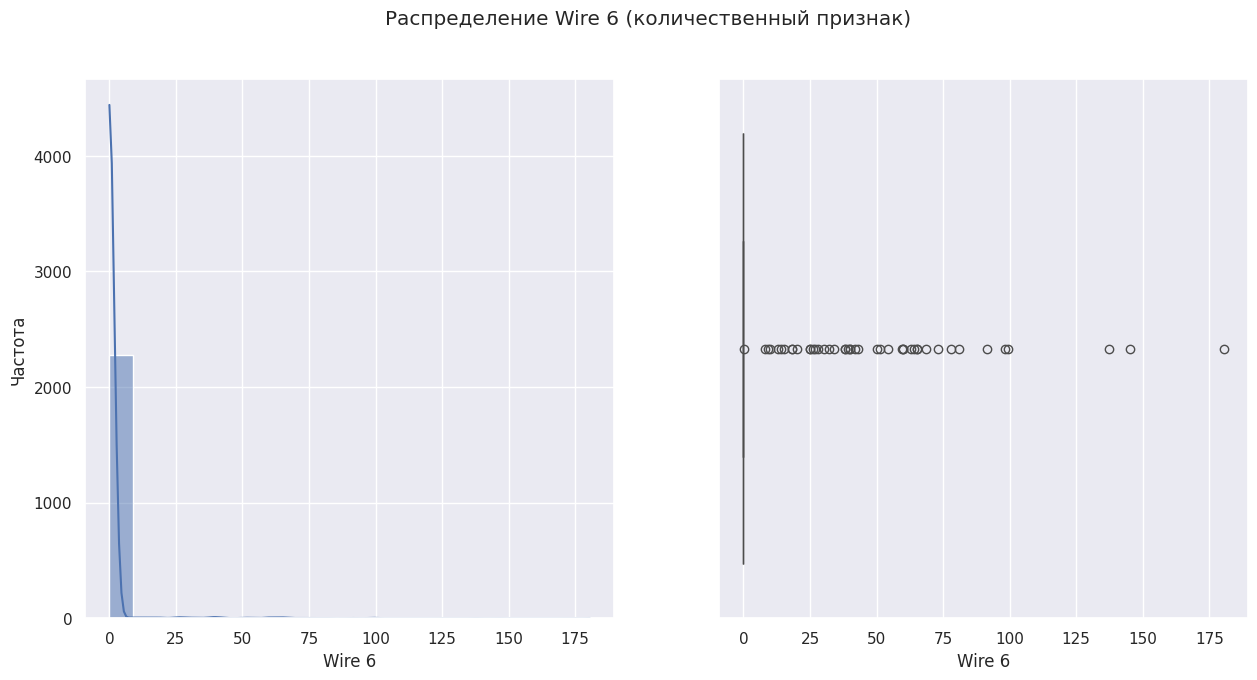

count    2323.000000
mean        0.981348
std         8.704381
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       180.454575
Name: Wire 6, dtype: float64


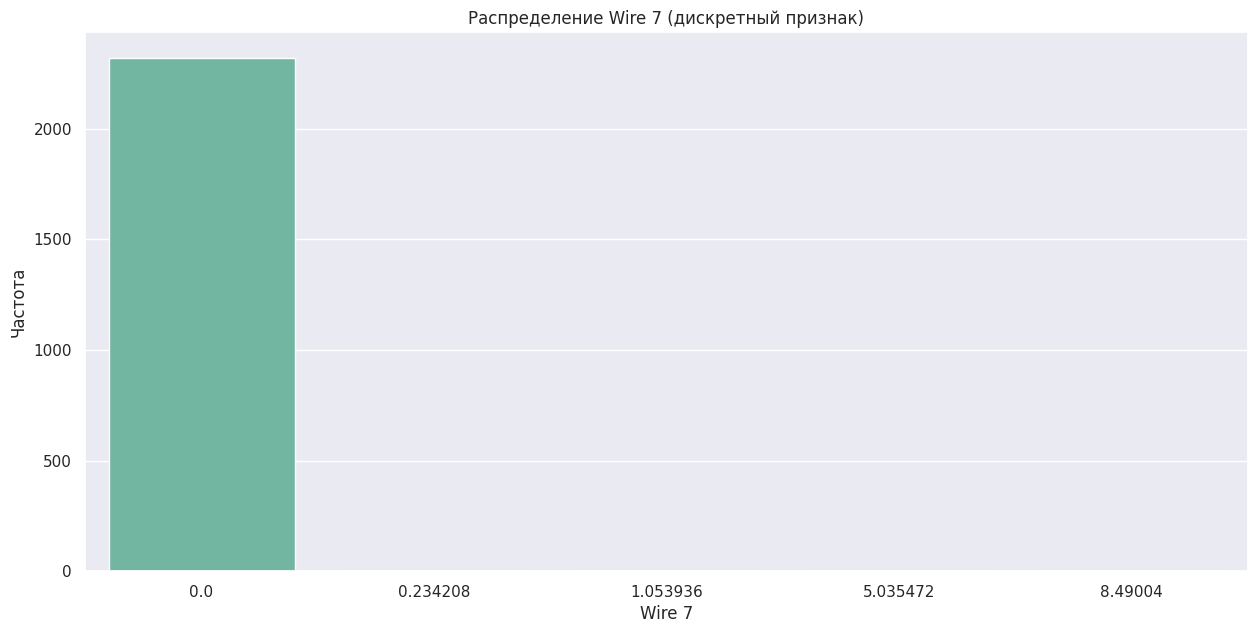

count    2323.000000
mean        0.006377
std         0.205970
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.490040
Name: Wire 7, dtype: float64


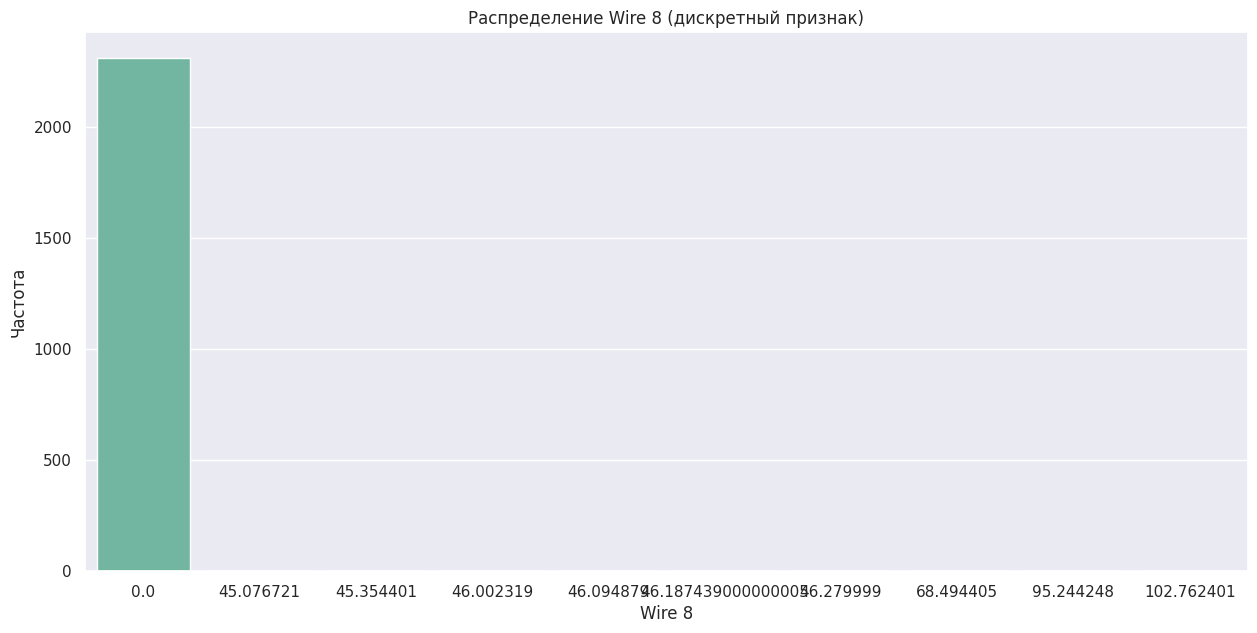

count    2323.000000
mean        0.312115
std         4.408363
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       102.762401
Name: Wire 8, dtype: float64


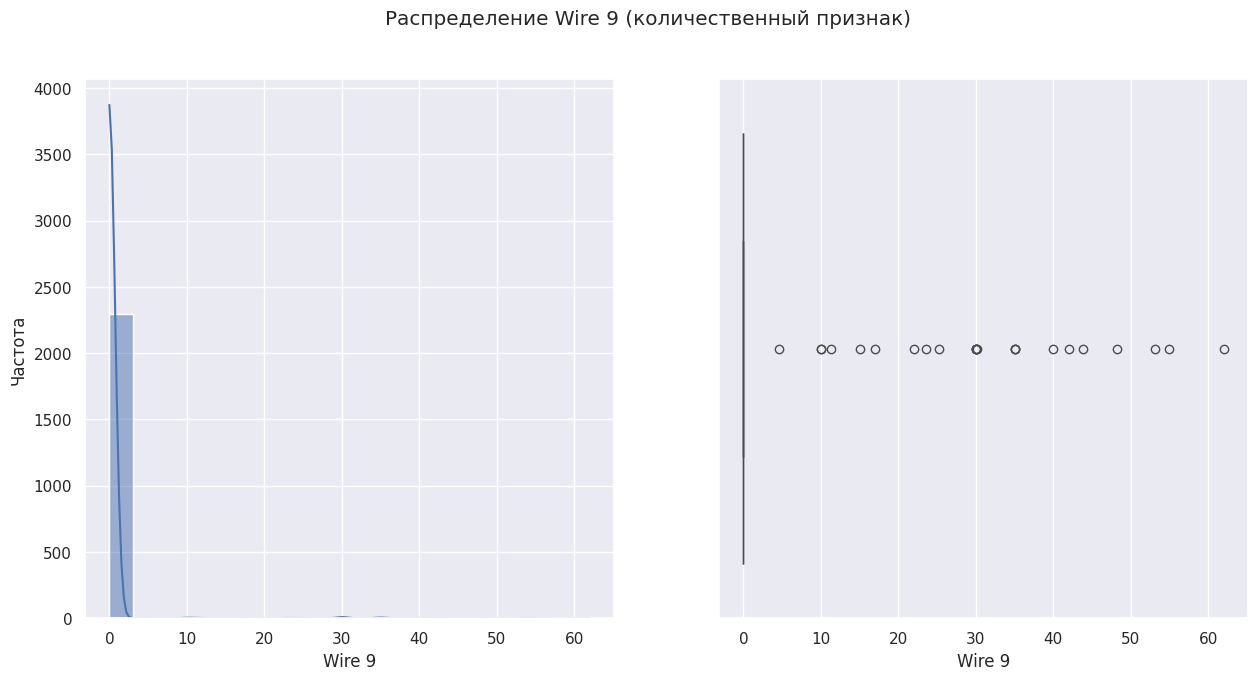

count    2323.000000
mean        0.317932
std         3.460987
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        62.025600
Name: Wire 9, dtype: float64


In [59]:
# Изучение данных о измерении температуры
for name in data_all.columns.tolist():
    if name != 'key':
        viz_num_variable(data_all, name)
        print(data_all[name].describe())

In [60]:
# Проверка ключей
data_all.tail()

key  Количество циклов нагрева  Активная мощность  Реактивная мощность  \
2318  2495                          4           0.792033             0.552734   
2319  2496                          6           0.695820             0.478672   
2320  2497                          3           1.201746             0.817364   
2321  2498                          5           0.640462             0.447964   
2322  2499                          4           0.434271             0.324209   

      Полная мощность  Время нагрева дугой  Затраты электроэнергии  Bulk 1  \
2318         0.967180                  723              694.177326       0   
2319         0.845053                  940              815.818538       0   
2320         1.453639                  569              823.020520       0   
2321         0.781983                  750              581.810739       0   
2322         0.542313                  883              532.386183       0   

      Bulk 2  Bulk 3  ...  Конечная температура      Wire 1    Wire 2  Wire 3  \
2318       0      21  ...                  1591   89.150879   0.00000     0.0   
2319       0       0  ...                  1591  114.179527   0.00000     0.0   
2320       0       0  ...                  1589   94.086723   9.04800     0.0   
2321       0      90  ...                  1594  118.110717   0.00000     0.0   
2322       0      47  ...                  1603  110.160958  50.00528     0.0   

      Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9  
2318     0.0     0.0     0.0     0.0     0.0     0.0  
2319     0.0     0.0     0.0     0.0     0.0     0.0  
2320     0.0     0.0     0.0     0.0     0.0     0.0  
2321     0.0     0.0     0.0     0.0     0.0     0.0  
2322     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 35 columns]

## Исследовательский анализ и предобработка данных объединённого датафрейма

interval columns not set, guessing: ['key', 'Количество циклов нагрева', 'Активная мощность', 'Реактивная мощность', 'Полная мощность', 'Время нагрева дугой', 'Затраты электроэнергии', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Bulk sum', 'Газ 1', 'Начальная температура', 'Конечная температура', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']


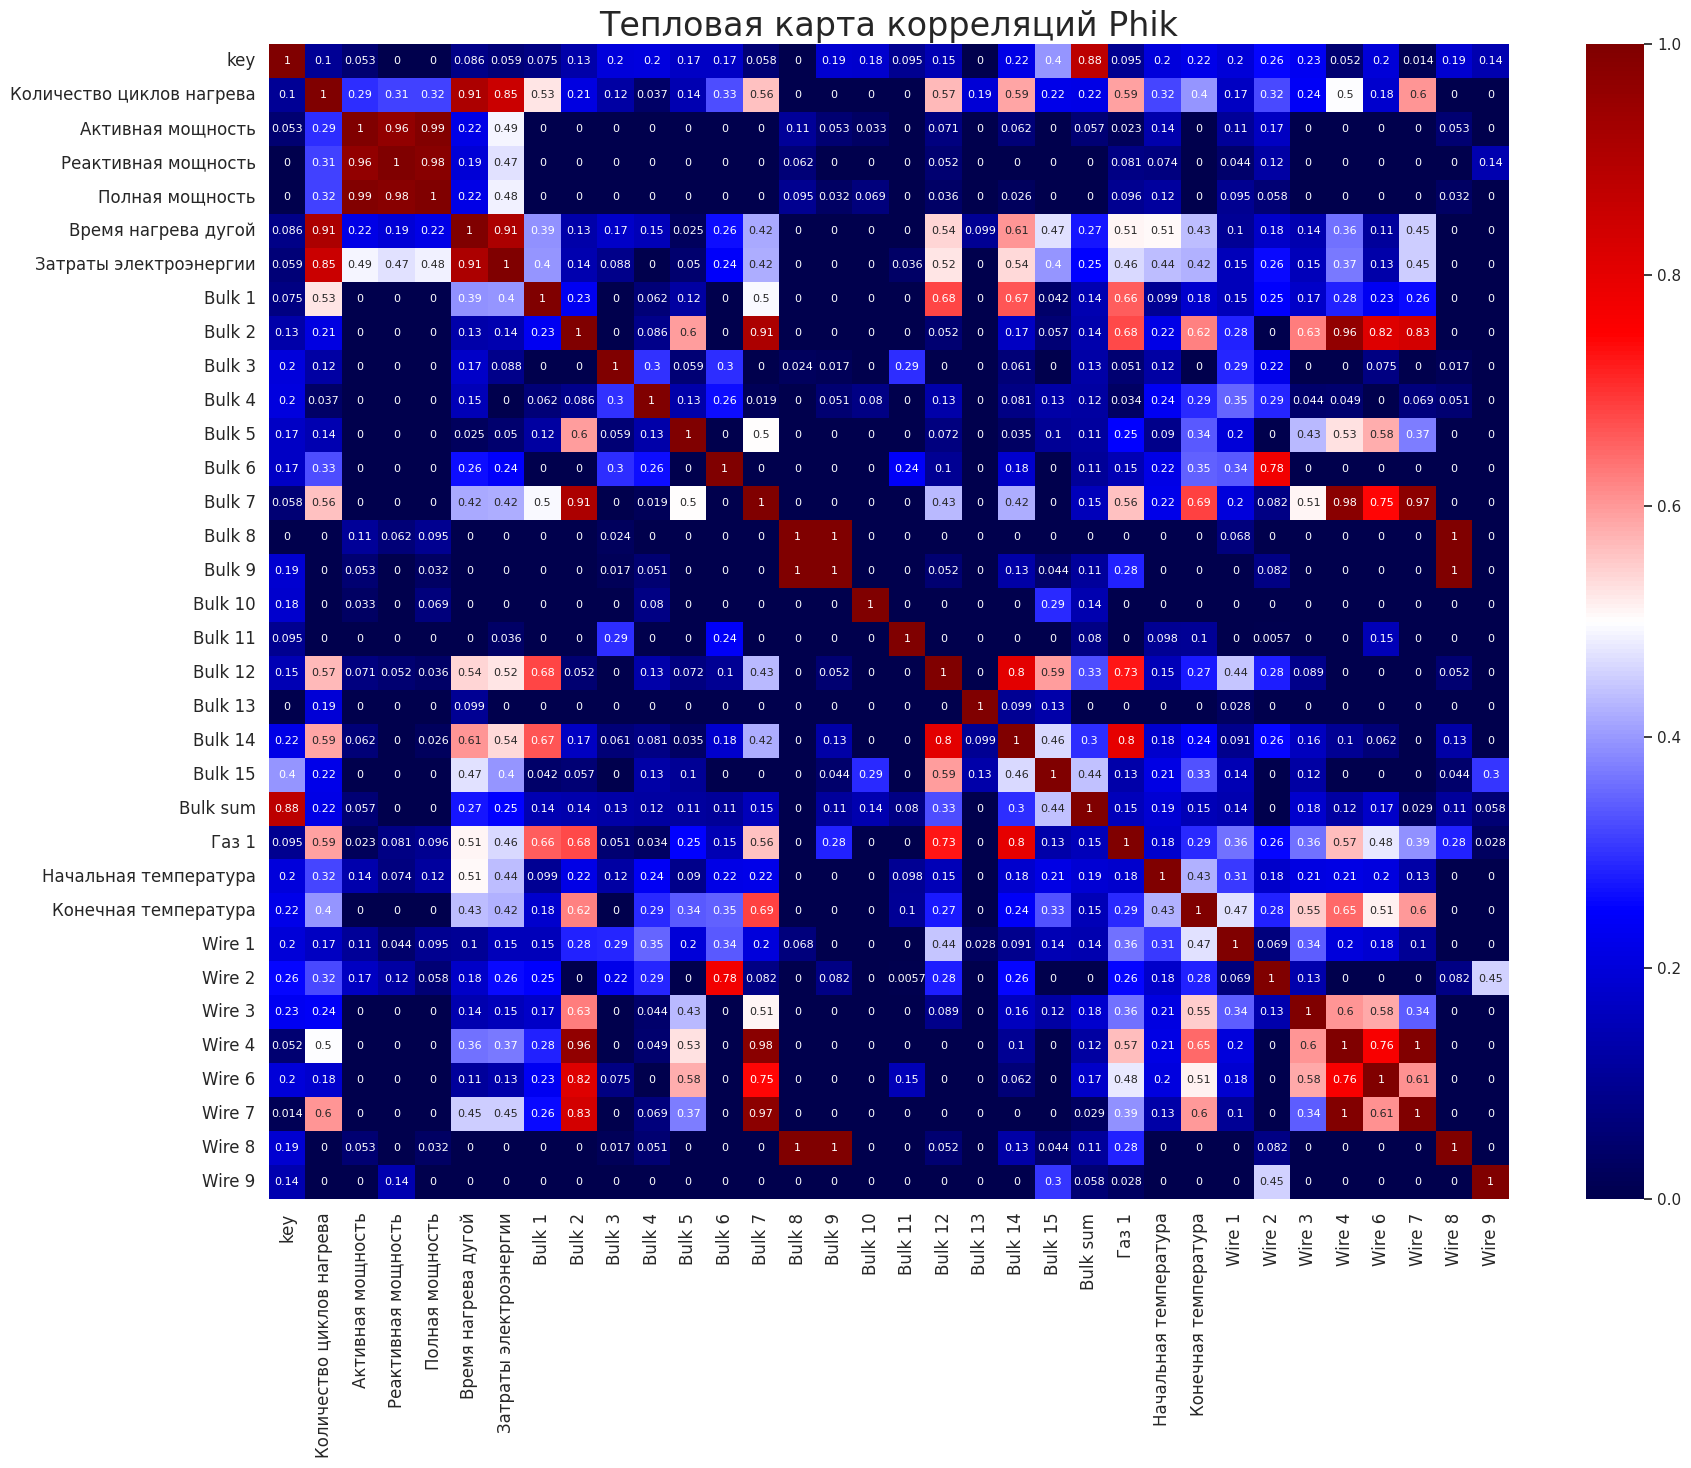

In [61]:
# Вычисляем матрицу корреляций Phik
phik_corr_matrix = data_all.phik_matrix()

# Увеличиваем размер шрифта для аннотаций на графике
plt.figure(figsize=(20, 15))
sns.heatmap(phik_corr_matrix, annot=True, cmap='seismic', annot_kws={"size": 8})

plt.title('Тепловая карта корреляций Phik', fontsize=24)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [62]:
data_all = data_all.drop(columns=['Реактивная мощность', 'Полная мощность', 'key'])

interval columns not set, guessing: ['Количество циклов нагрева', 'Активная мощность', 'Время нагрева дугой', 'Затраты электроэнергии', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Bulk sum', 'Газ 1', 'Начальная температура', 'Конечная температура', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']


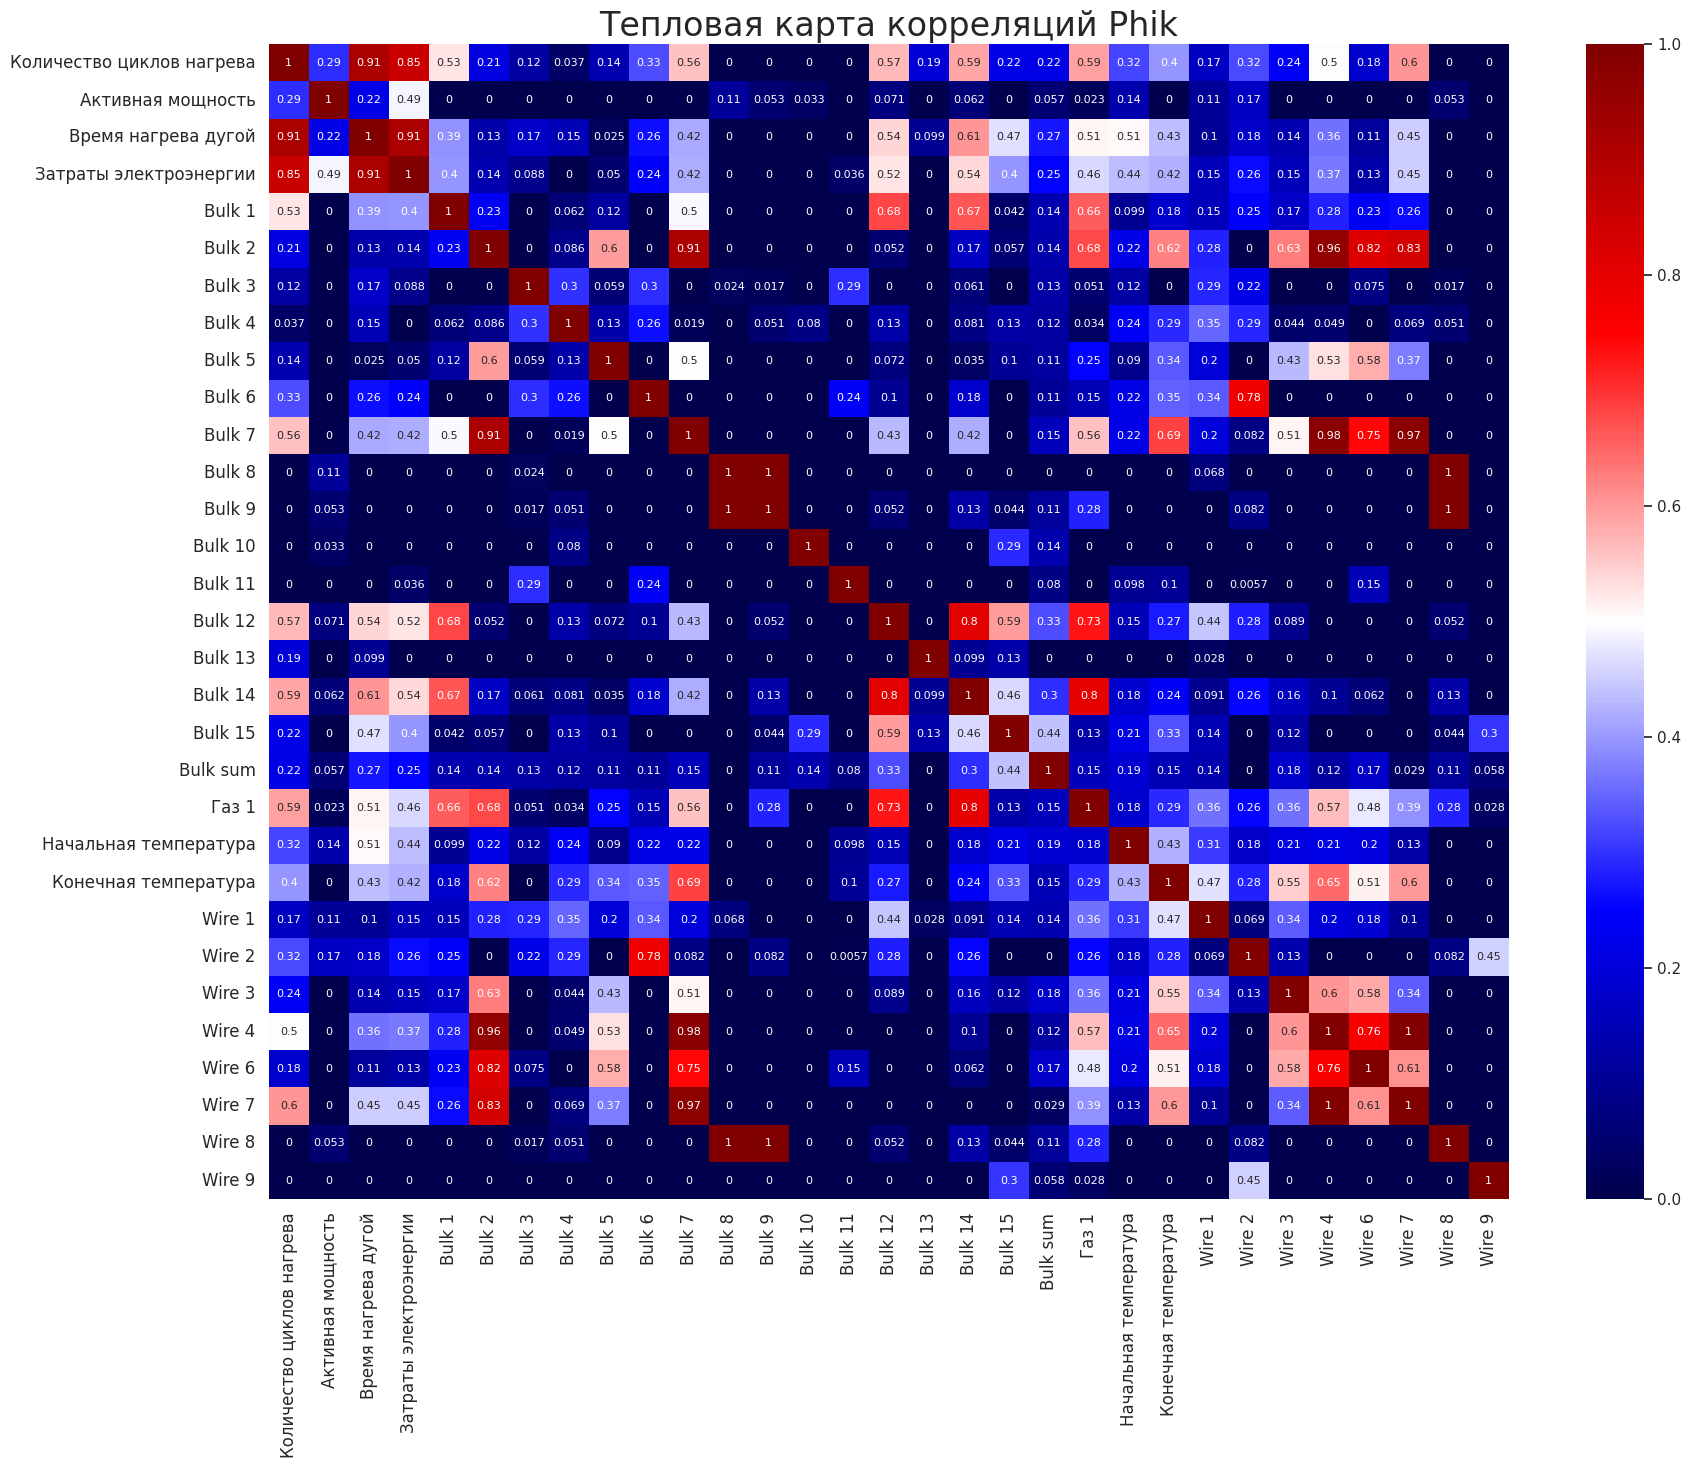

In [63]:
# Вычисляем матрицу корреляций Phik для проверки
phik_corr_matrix = data_all.phik_matrix()

# Увеличиваем размер шрифта для аннотаций на графике
plt.figure(figsize=(20, 15))
sns.heatmap(phik_corr_matrix, annot=True, cmap='seismic', annot_kws={"size": 8})

plt.title('Тепловая карта корреляций Phik', fontsize=24)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [64]:
# Удаление высокоскоррелированных признаков
data_all = data_all.drop(columns=['Время нагрева дугой', 'Bulk 2', 'Bulk 7', 'Bulk 8', 'Bulk 9'])

interval columns not set, guessing: ['Количество циклов нагрева', 'Активная мощность', 'Затраты электроэнергии', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Bulk sum', 'Газ 1', 'Начальная температура', 'Конечная температура', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']


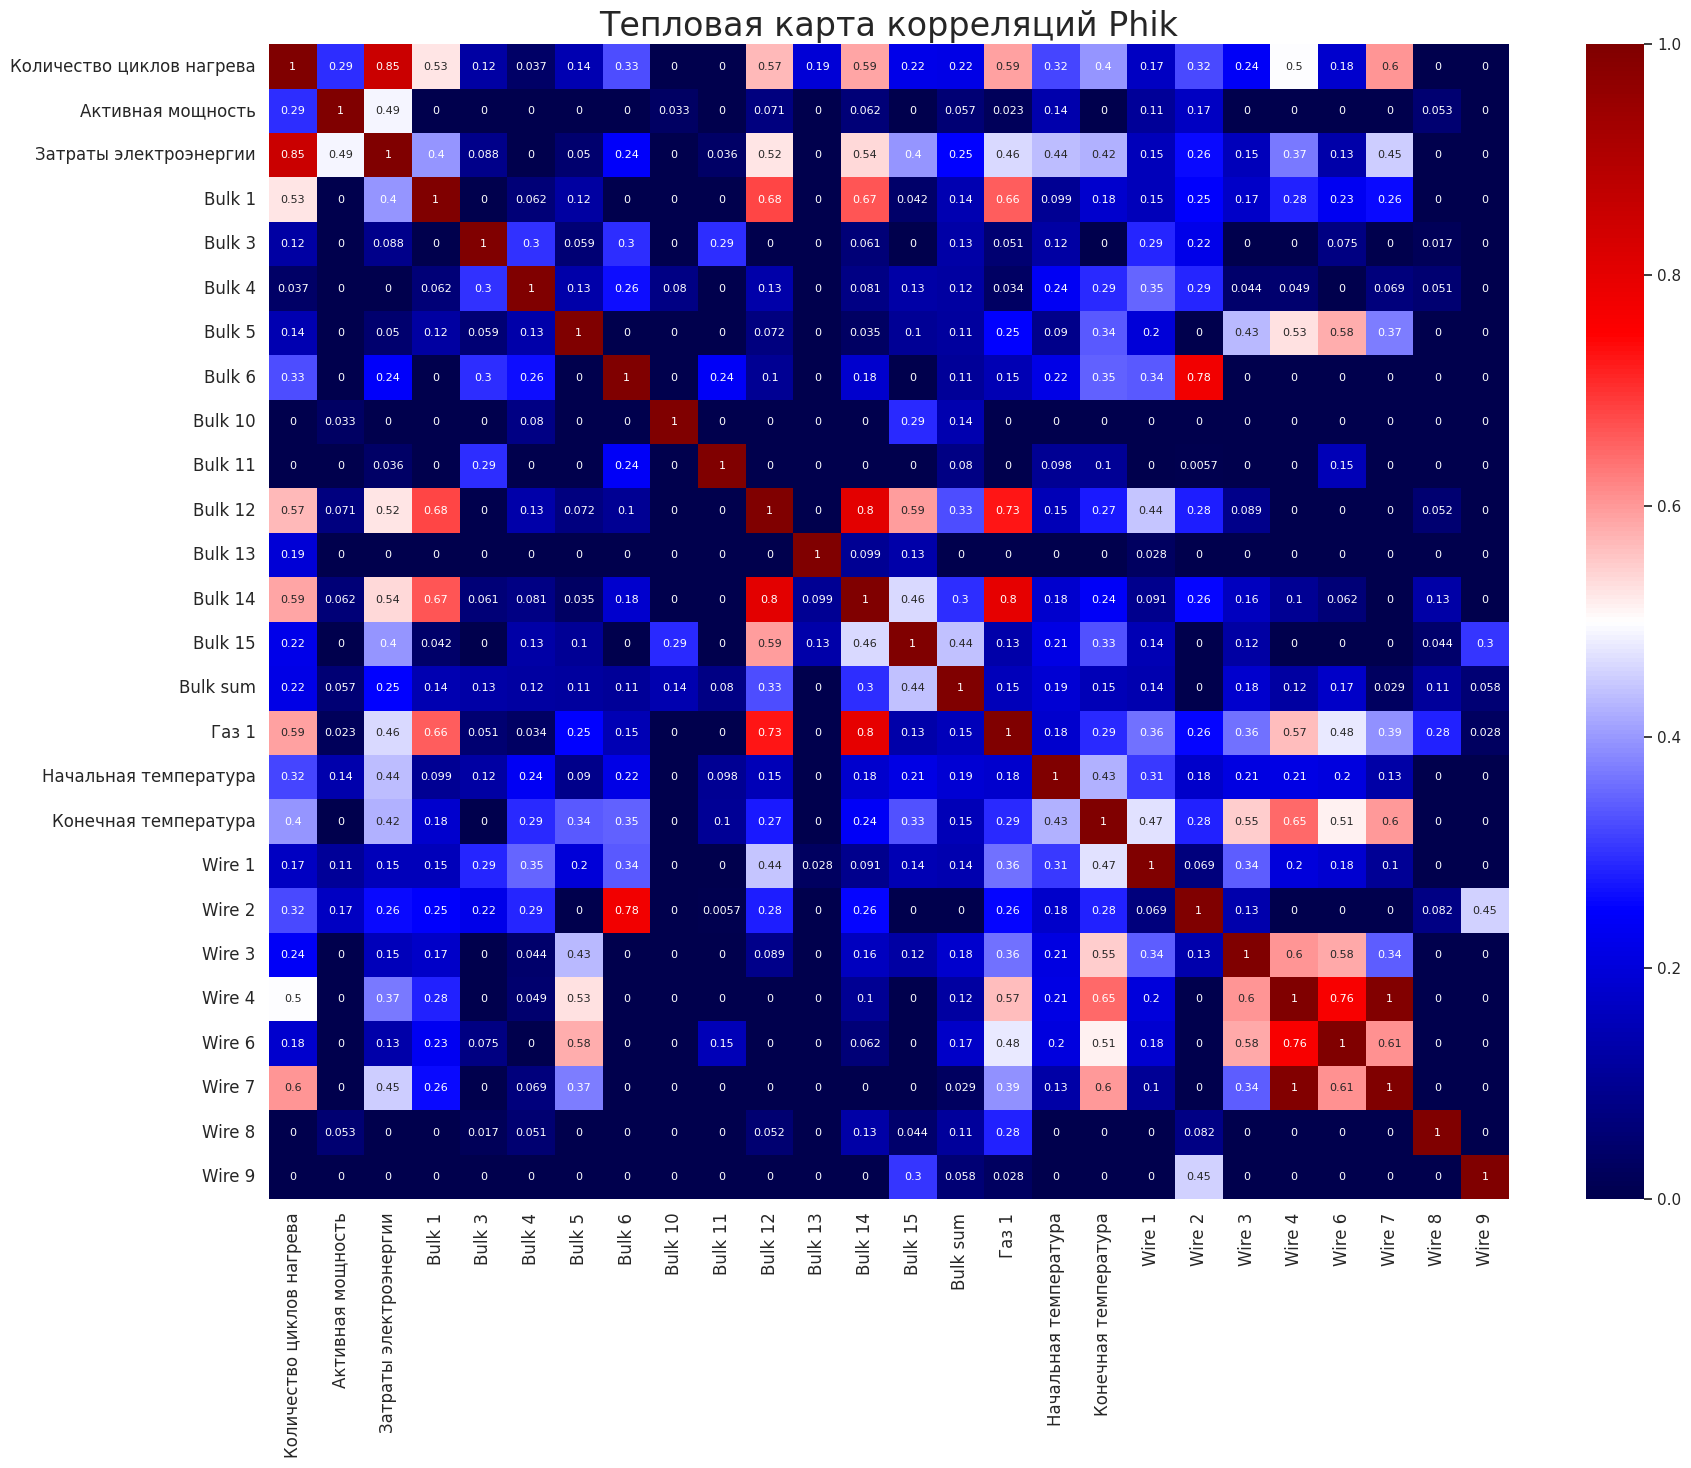

In [65]:
# Вычисляем матрицу корреляций Phik для проверки 2
phik_corr_matrix = data_all.phik_matrix()

# Увеличиваем размер шрифта для аннотаций на графике
plt.figure(figsize=(20, 15))
sns.heatmap(phik_corr_matrix, annot=True, cmap='seismic', annot_kws={"size": 8})

plt.title('Тепловая карта корреляций Phik', fontsize=24)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

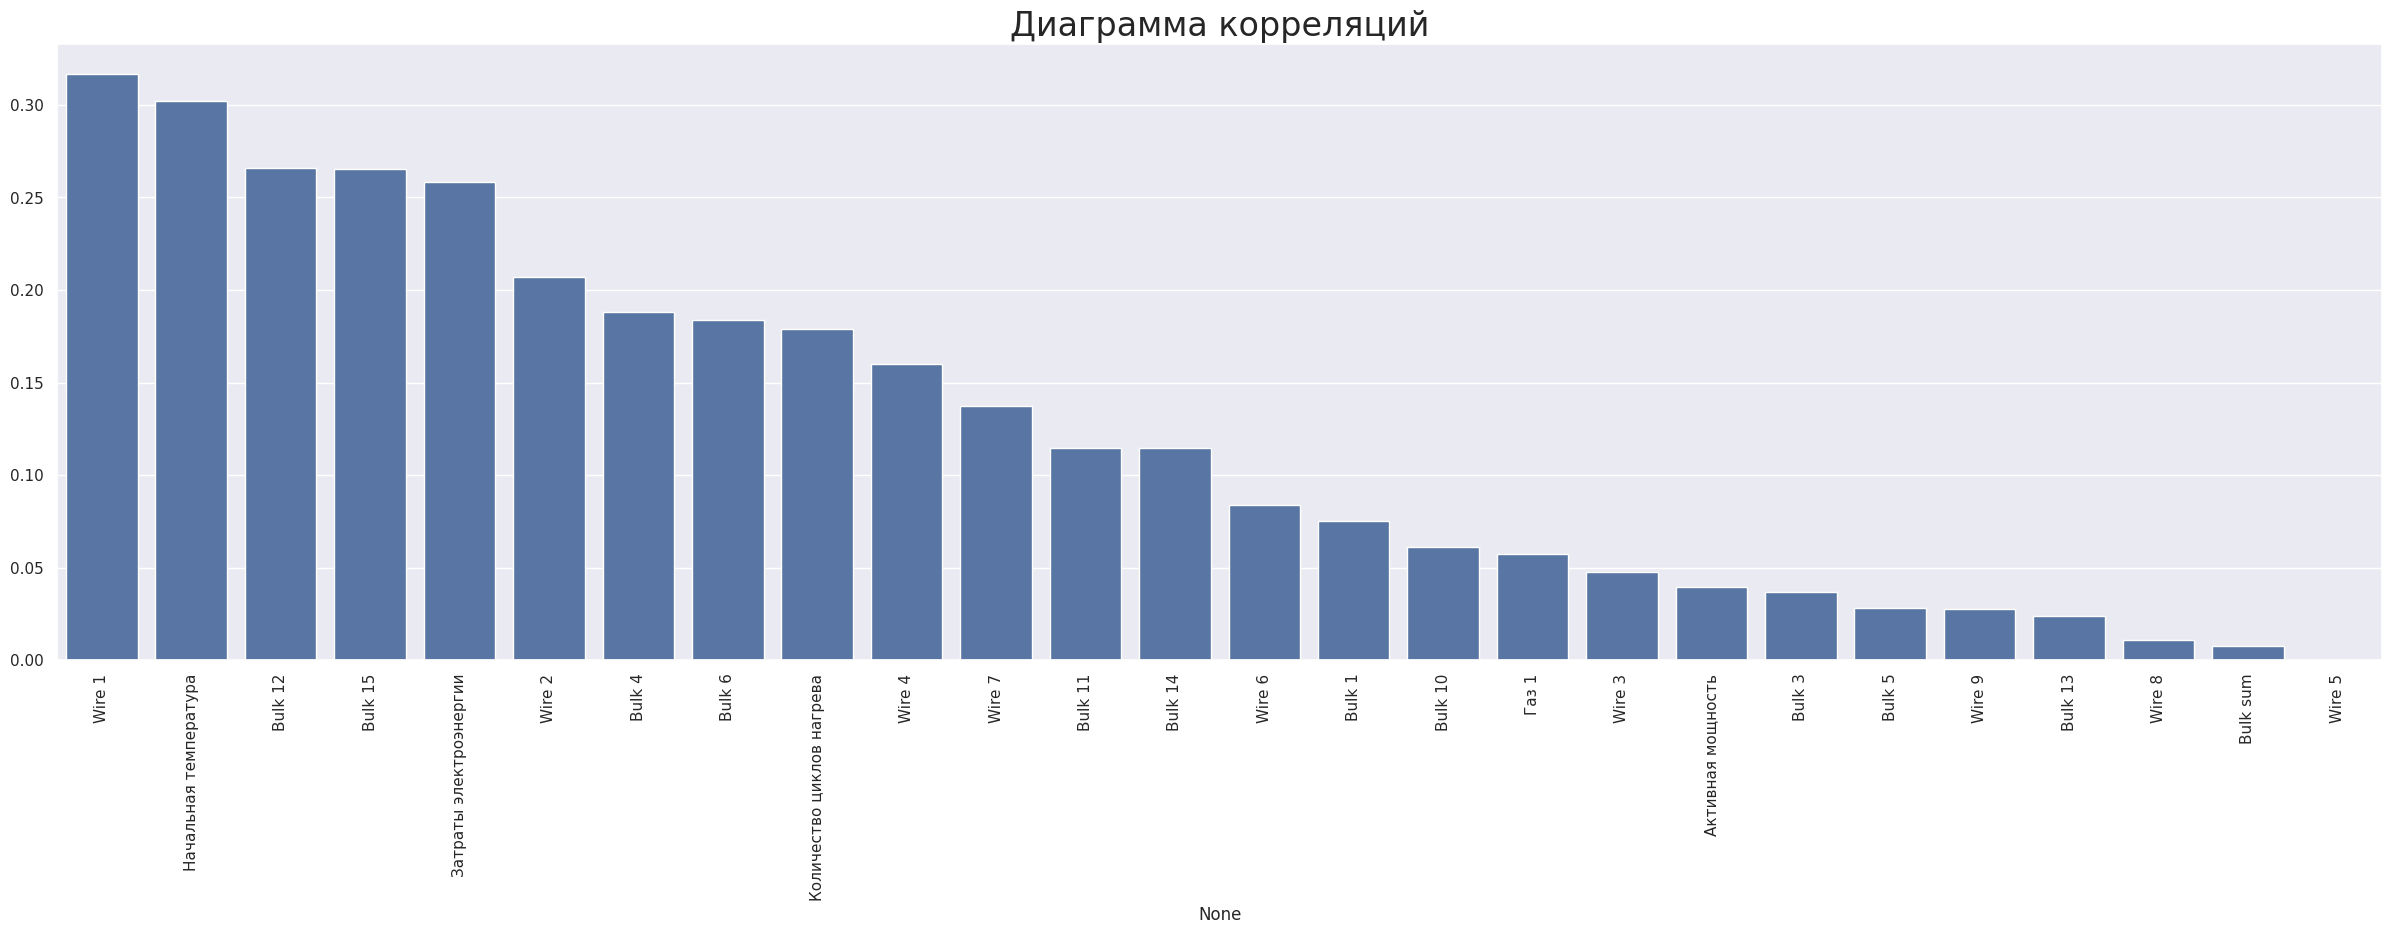

In [66]:
# Построении диаграммы корреляции
corr_data_all=pd.Series()
for i in data_all.columns:
    corr_data_all[i] = abs(data_all['Конечная температура'].corr(data_all[i]))
corr_data_all= corr_data_all.sort_values(ascending=False)[1:]

plt.figure(figsize=(30,8))
sns.barplot(x=corr_data_all.index, y=corr_data_all.values)
plt.title('Диаграмма корреляций', fontsize=24)

plt.xticks(rotation=90)
plt.show()

### Выводы:
- Наблюдается высокая корреляция активной, реактивной, полной мощности, подачи нескольких сыпучих материалов и газа;
- Высокоскоррелированные признаки удалены для устранения мультиколлинеарности.

## Подготовка данных

In [67]:
# Разделение признаков
y = data_all['Конечная температура']
X = data_all.drop(columns=['Конечная температура'])

In [68]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [69]:
print(f'Размер обучающей выборки: {X_train.shape[0]}')

Размер обучающей выборки: 1742


In [70]:
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер тестовой выборки: 581



## Обучение моделей машинного обучения

### LinearRegression

In [71]:
pipeline_lr = Pipeline([
    ('preprocessor', StandardScaler()),
    ('model', LinearRegression())
])

# Оценка модели с кросс-валидацией
mae_lr = (cross_val_score(pipeline_lr,
                                X_train,
                                y_train,
                                cv=5,
                                scoring='neg_mean_absolute_error').mean()
                                )
print('Mean MAE from CV of LinearRegression =', abs(mae_lr).round(2))

Mean MAE from CV of LinearRegression = 6.48


### RandomForestRegressor

In [72]:
# Пайплайн для случайного леса
pipeline_rf = Pipeline([
    ('preprocessor', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=10,
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE))
])

# Оценка модели с кросс-валидацией
mae_rf = (cross_val_score(pipeline_rf,
                                X_train,
                                y_train,
                                cv=5,
                                scoring='neg_mean_absolute_error').mean())
print('Mean MAE from CV of RandomForest =', abs(mae_rf).round(2))

Mean MAE from CV of RandomForest = 6.78


### CatBoostRegressor

In [73]:
# Модель CatBoostRegressor
model_cbr = CatBoostRegressor(learning_rate=0.06,
                              iterations=300,
                              depth=10,
                              l2_leaf_reg=3,
                              subsample=0.8,
                              colsample_bylevel=0.8,
                              bagging_temperature=1.0,
                              random_state=RANDOM_STATE,
                              early_stopping_rounds=50,
                              verbose=False)

# Оценка модели с кросс-валидацией
mae_cbr = (cross_val_score(model_cbr,
                                X_train,
                                y_train,
                                cv=5,
                                scoring='neg_mean_absolute_error').mean())
print('Mean MAE from CV of CatBoostRegressor =', abs(mae_cbr).round(2))

Mean MAE from CV of CatBoostRegressor = 6.45


### LightGBM

In [74]:
# Инициализация модели с фиксированными параметрами
model_lgbm = LGBMRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0,
    reg_lambda=0.1,
    min_child_samples=5,
    min_child_weight=1
)

# Гиперпараметры для поиска
hyperparams = {
    'num_leaves': [31, 50],
    'max_depth': [5, 10],
}

# Поиск лучших параметров с помощью GridSearchCV
clf = GridSearchCV(
    model_lgbm,
    hyperparams,
    scoring='neg_mean_absolute_error',
    cv=5
)

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)

model_lgbm = clf.best_estimator_
mae_lgbm = (clf.best_score_)
print('Mean MAE from CV of LightGBM =', abs(mae_lgbm).round(2))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

### DummyRegressor

In [75]:
model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(X_train, y_train)

mae_dummy = mean_absolute_error(y_test, model_dummy.predict(X_test))

print('Mean MAE from CV of LightGBM =', abs(mae_dummy).round(2))

Mean MAE from CV of LightGBM = 7.95


## Выбор лучшей модели

In [76]:
# Функция для измерения времени выполнения кода
def measure_time(func):
    start = time.time()
    result = func()
    end = time.time()
    return result, (end - start) / 60  # возвращаем результат и время в минутах

# Оценка моделей
models_results = {}

### LinearRegression

In [77]:
train_time_lr = measure_time(lambda: pipeline_lr.fit(X_train, y_train))
pred_time_lr = measure_time(lambda: pipeline_lr.predict(X_train))
models_results['LinearRegression'] = {
    'model': pipeline_lr,
    'MAE': mae_lr,
    'train_time': train_time_lr[1],
    'pred_time': pred_time_lr[1]}

### RandomForestRegressor

In [78]:
train_time_rf = measure_time(lambda: pipeline_rf.fit(X_train, y_train))
pred_time_rf = measure_time(lambda: pipeline_rf.predict(X_train))
models_results['RandomForestRegressor'] = {
    'model': pipeline_rf,
    'MAE': mae_lr,
    'train_time': train_time_rf[1],
    'pred_time': pred_time_rf[1]}

### CatBoostRegressor

In [79]:
train_time_cbr = measure_time(lambda: model_cbr.fit(X_train, y_train))
pred_time_cbr = measure_time(lambda: model_cbr.predict(X_train))
models_results['CatBoostRegressor'] = {
    'model': model_cbr,
    'MAE': mae_cbr,
    'train_time': train_time_cbr[1],
    'pred_time': pred_time_cbr[1]}

### LGBM

In [80]:
train_time_lgbm = measure_time(lambda: model_lgbm.fit(X_train, y_train))
pred_time_lgbm = measure_time(lambda: model_lgbm.predict(X_train))
models_results['LGBMRegressor'] = {
    'model': model_lgbm,
    'MAE': mae_lgbm,
    'train_time': train_time_lgbm[1],
    'pred_time': pred_time_lgbm[1]}

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

### DummyRegressor

In [81]:
train_time_dummy = measure_time(lambda: model_dummy.fit(X_train, y_train))
pred_time_dummy = measure_time(lambda: model_dummy.predict(X_train))
models_results['DummyRegressor'] = {
    'model': model_dummy,
    'MAE': mae_dummy,
    'train_time': train_time_dummy[1],
    'pred_time': pred_time_dummy[1]}

### Сравнение моделей

In [82]:
# Сравнение моделей
def score(model):
    return (
        (model['MAE'] / min(m['MAE'] for m in models_results.values())) +
        (model['train_time'] / min(m['train_time'] for m in models_results.values())) +
        (model['pred_time'] / min(m['pred_time'] for m in models_results.values()))
    ) / 3

scores = {k: score(v) for k, v in models_results.items()}

for model, score in scores.items():
    print(f'{model}: {score}')

LinearRegression: 21.778221683015555
RandomForestRegressor: 53.117621890266584
CatBoostRegressor: 1776.886443660221
LGBMRegressor: 387.81186601373514
DummyRegressor: 0.25786661984357345


### Тестирование лучшей модели

In [83]:
# Выбор лучшей модели и тестирование её на тестовой выборке
best_model_name = max(scores, key=scores.get)
best_model = models_results[best_model_name]['model']

# Окончательная оценка на тестовой выборке
predictions, test_time = measure_time(lambda: best_model.predict(X_test))
final_mae_test = mean_absolute_error(y_test, predictions)
final_r2_test = r2_score(y_test, predictions)

print(f'Лучшей моделью оказалась {best_model_name}')
print(f'MAE на тестовой выборке = {final_mae_test.round(1)}')
print(f'r2 на тестовой выборке = {final_r2_test}')
print(f'Время предсказания на тестовой выборке = {test_time} минут')

Лучшей моделью оказалась CatBoostRegressor
MAE на тестовой выборке = 6.4
r2 на тестовой выборке = 0.3621762616424856
Время предсказания на тестовой выборке = 0.00011665026346842448 минут


Коэффициент R2 на тестовой выборке равный 0.4 означает, что модель объясняет 40% вариации целевой переменной на тестовых данных.

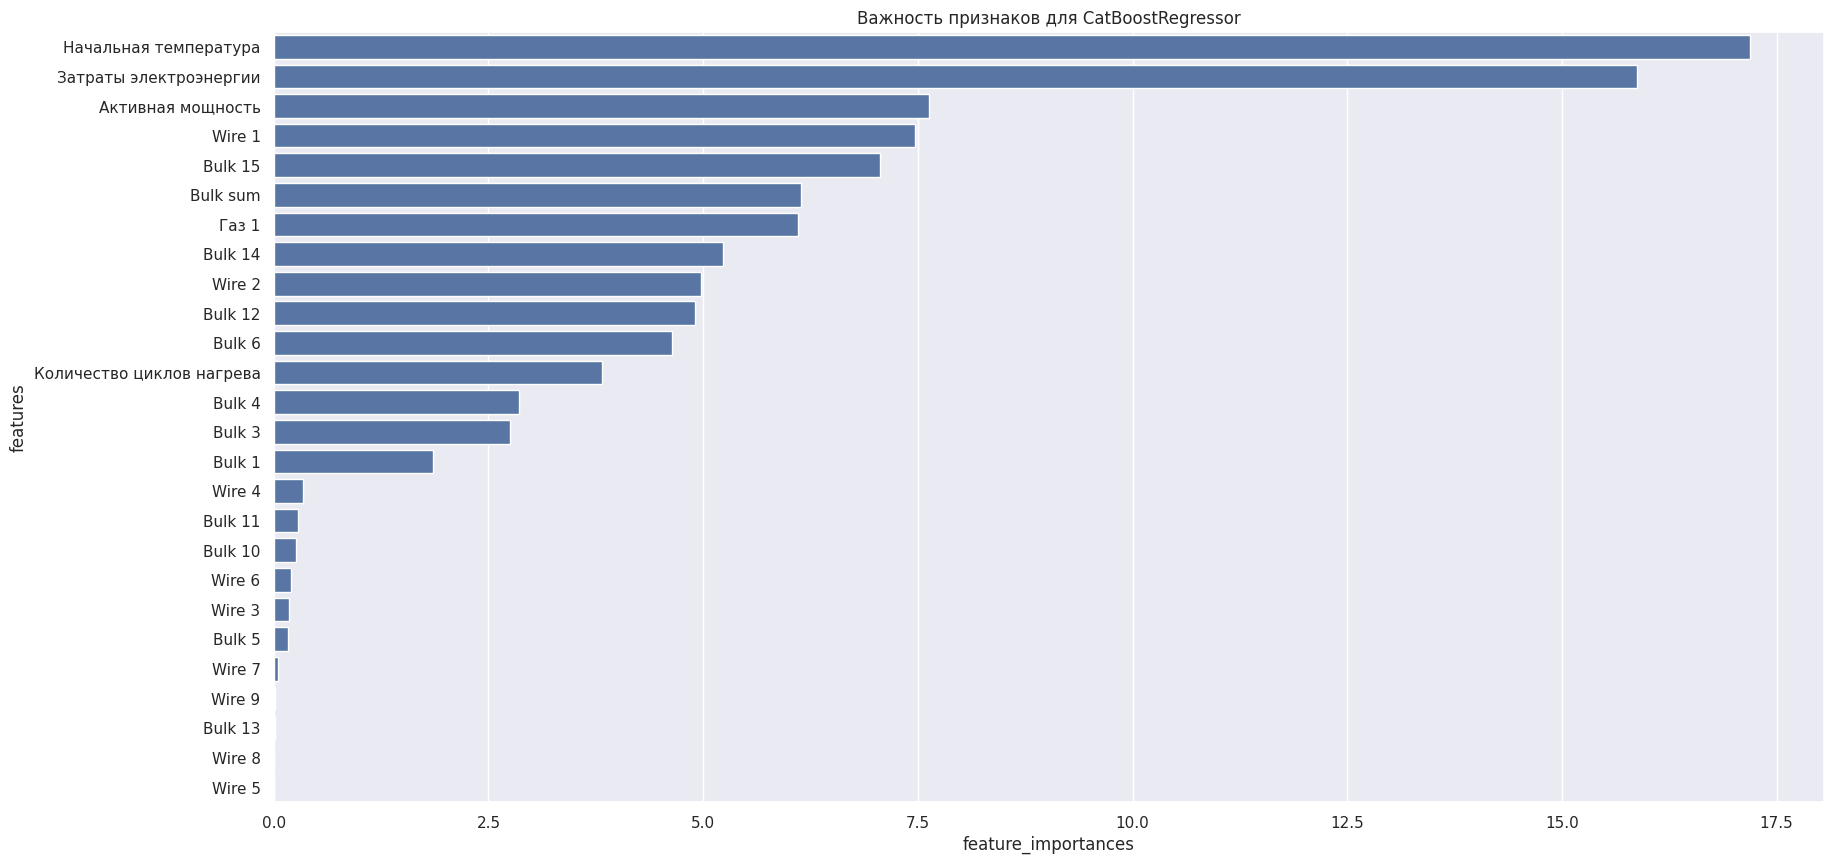

In [84]:
plot_data = {
    'features': X_test.columns,
    'feature_importances': model_cbr.feature_importances_,
}

plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)

sns.set(rc={"figure.figsize": (20, 10)})
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])

plt.title('Важность признаков для CatBoostRegressor')
plt.show()

### Выводы:
- Выбрана лучшая модель - CatBoostRegressor;
- MAE на тестовой выборке = 6.4;
- Наиболее важными признаками оказались: начальная температура, время нагрева дугой, подача 1 газа, сумма добаленных сыпучих веществ, объем подаваемого газа.

## Общий вывод и рекомендации заказчику

1. Данные загружены и проведена первичная оценка данных.
2. Проведен исследовательский анализ данных:
    - Исследованы данные, необходимые для обучения модели;
    - Обработаны пропуски и аномалии в данных;
    - Созданы новые признаки в данных о электродах и изменении температуры;
    - Удалены партии с температурой ниже 1400°С и пропусками в замерах;
    - Данные объеденены в группы по партиям;
    - Получено целевое значение - Конечная температура.
3. Данные объеденены в один датафрейм.
4. Проведен корреляционный анализ:
    - Выявлены признаки сильно корректирующие друг с другом;
    - Признаки реактивной и полной мощности удалены.
5. Данные были подготовлены для обучения модели.
6. Обучены модели:
    - LinearRegression. MAE = 6.48;
    - RandomForestRegressor. MAE = 6.78;
    - CatBoostRegressor. MAE = 6.45;
    - LGBMRegressor. MAE = 6.47;
    - DummyRegressor = 7.95.
7. Выбрана наилучшая модель:
    - CatBoostRegressor. learning_rate=0.06, iterations=300, depth=10, l2_leaf_reg=3, subsample=0.8, colsample_bylevel=0.8, bagging_temperature=1.0, random_state=141024, early_stopping_rounds=50, verbose=False;
    - MAE на тестовой выборке = 6.4;
    - Наиболее важными признаками оказались: начальная температура, время нагрева дугой, подача 1 газа, сумма добаленных сыпучих веществ, объем подаваемого газа.